# Adventures in mosaic density!

Let's see what happens to optimal filters (a la Atick and Redlich) when we change the density of the mosaic.

In [1]:
#This version uses the Cx estimated from natural movies 
import numpy as np
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib 
import pickle
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

import seaborn as sns
import scipy.optimize as opt
import scipy.signal as ssig
from scipy.interpolate import interp1d
from scipy.special import softmax
from scipy.interpolate import RectBivariateSpline, BivariateSpline
import scipy

def softplus(x, beta=1): return np.log1p(np.exp(-np.abs(beta * x)))/beta + np.maximum(x, 0)

plt.rcParams.update({
    "text.usetex": True,
})

sns.set_context('talk')

%config InlineBackend.figure_format = 'retina'

np.random.seed(12346)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

# First, let's set up some problem dimensions:

In [2]:
L = 10  # linear size of space in one dimension
T = 5 # size of time
N = 1001 # number of points
M = 1001
zz = np.linspace(-L/2, L/2, N)
tt = np.linspace(-T/2, T/2, M)
dz = zz[1] - zz[0]
dt = tt[1] - tt[0]

# Now assuming $C_x = \frac{A}{k^\alpha\omega^2}$, let's calculate the Atick and Redlich filter.

In [69]:
sigout = 1.25
nu = 1e-3
#A = np.array([100])

def soft_bandpass(lo, hi, freqs, stiffness=10):
    if lo <= 0:
        return scipy.special.expit(stiffness * (hi - freqs))
    else:
        return scipy.special.expit(stiffness * (freqs - lo)) * scipy.special.expit(stiffness * (hi - freqs))

#Original version of the code
#def C_prev(k, o):
#    return A/(np.abs(k)**alpha * np.abs(o)**2)

#def C(k,o,i):
#    eigval = A[i]/(np.abs(k)**alpha * np.abs(o)**2)  
#    return eigval

def import_C():
    with open(os.getcwd() + "/../../Cx.pkl", 'rb') as f:
        x = pickle.load(f)
    return x
hey = import_C()
n_time_freqs = hey['Cx_eigvals'].shape[1]//2
n_space_freqs = hey['Cx_eigvals'].shape[0]
Cx_pre = hey['Cx_eigvals'][:,0:n_time_freqs,:]
Cx_pre = np.flip(Cx_pre, axis = 2)
U = hey['Cx_eigvects'][:,0:n_time_freqs,:]
U = np.flip(U, axis = 3)
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        for c in range(U.shape[3]):
            if U[i,j,0,c] < 0:
                U[i,j,:,c] *= -1
#Cx = scipy.ndimage.gaussian_filter(Cx_pre, sigma = (2,0,0), order = 0)
Cx = scipy.ndimage.median_filter(Cx_pre, size = 5, axes = 0)
n_channels = Cx.shape[2]

def C_interpolate(k, o, i):
    func = RectBivariateSpline(np.arange(Cx.shape[0]), np.arange(Cx.shape[1]), np.log10(Cx[:,:,i]), s = 0)
    return 10**func(k,o)/1000000000 #November 7th, 2024
    #return 10**func(k,o)/10000000

def C(kk, oo, c):
    size1 = kk.shape[0]
    size2 = kk.shape[1]
    Cx_broad = np.zeros(kk.shape)
    for i in range(size1):
        for j in range(size2):
            Cx_broad[i,j] = Cx[int(kk[i,j]), int(oo[i,j]),c]
    return Cx_broad

def C_fix_k(C, k, i):
    def C(o):
        return RectBivariateSpline(np.arange(Cx.shape[0]), np.arange(Cx.shape[1]), Cx[:,:,i])

def filter(Cx, sigout, nu, k_lims=None, o_lims=None):
    def v_opt(k, omega, i):
        sqrt_piece = np.sqrt(1 + (4/(nu*C(kk,oo,i)*sigout**2)))
        v2 = 0.5 * (sqrt_piece + 1) * C(k, oo, i) / (C(kk, oo, i) + 1) - 1
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2)
        
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        if o_lims:
            unit_cell_o = soft_bandpass(o_lims[0], o_lims[1], omega)
            v2 *= unit_cell_o
            
        return v2
    return v_opt

In [53]:
hey['Cx_eigvals'].shape[0]

98

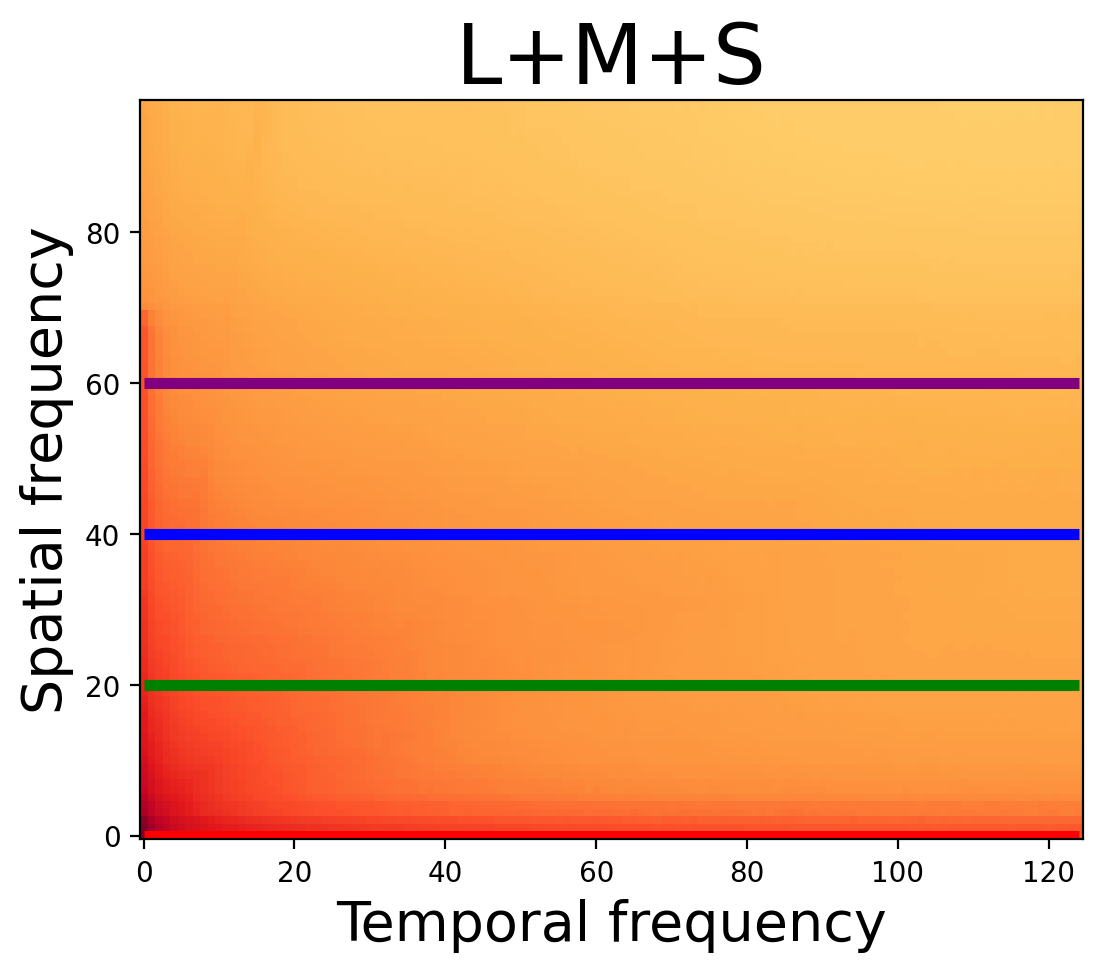

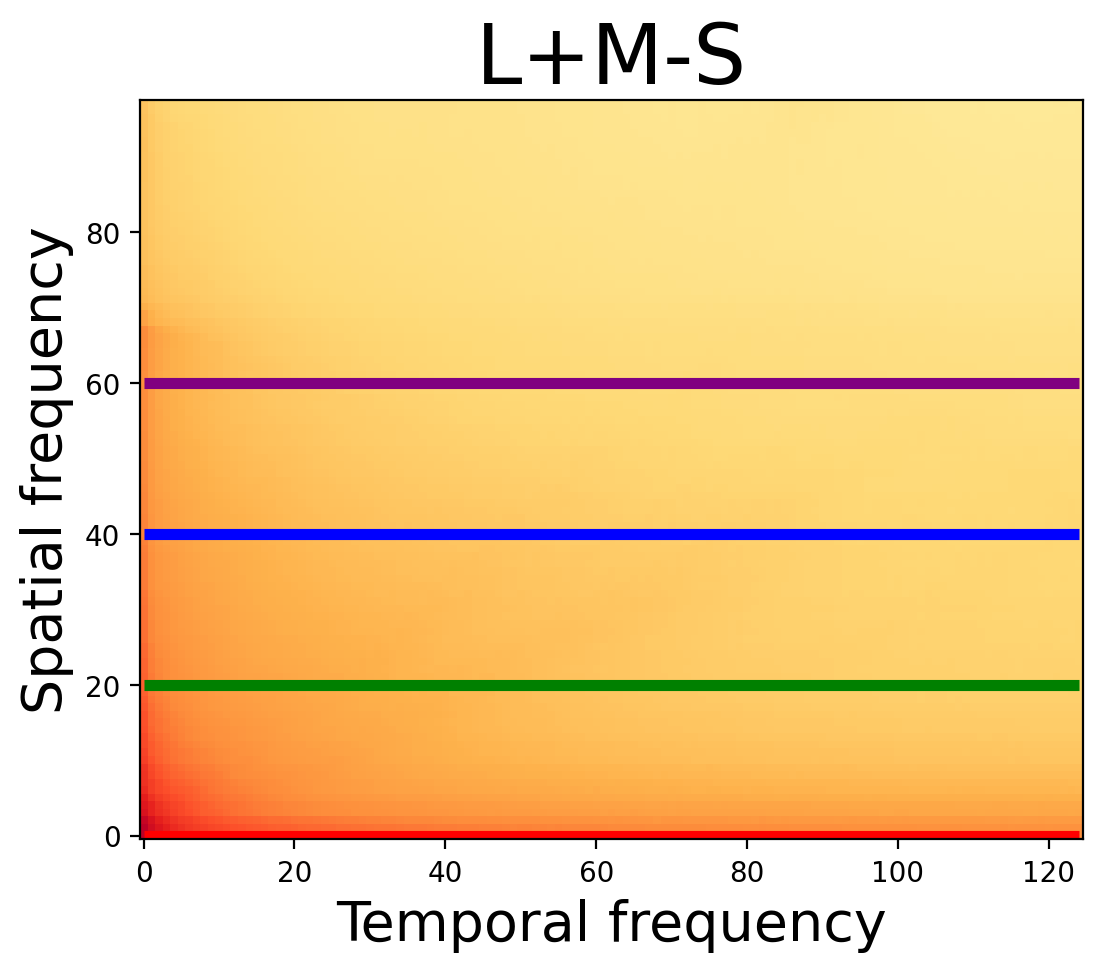

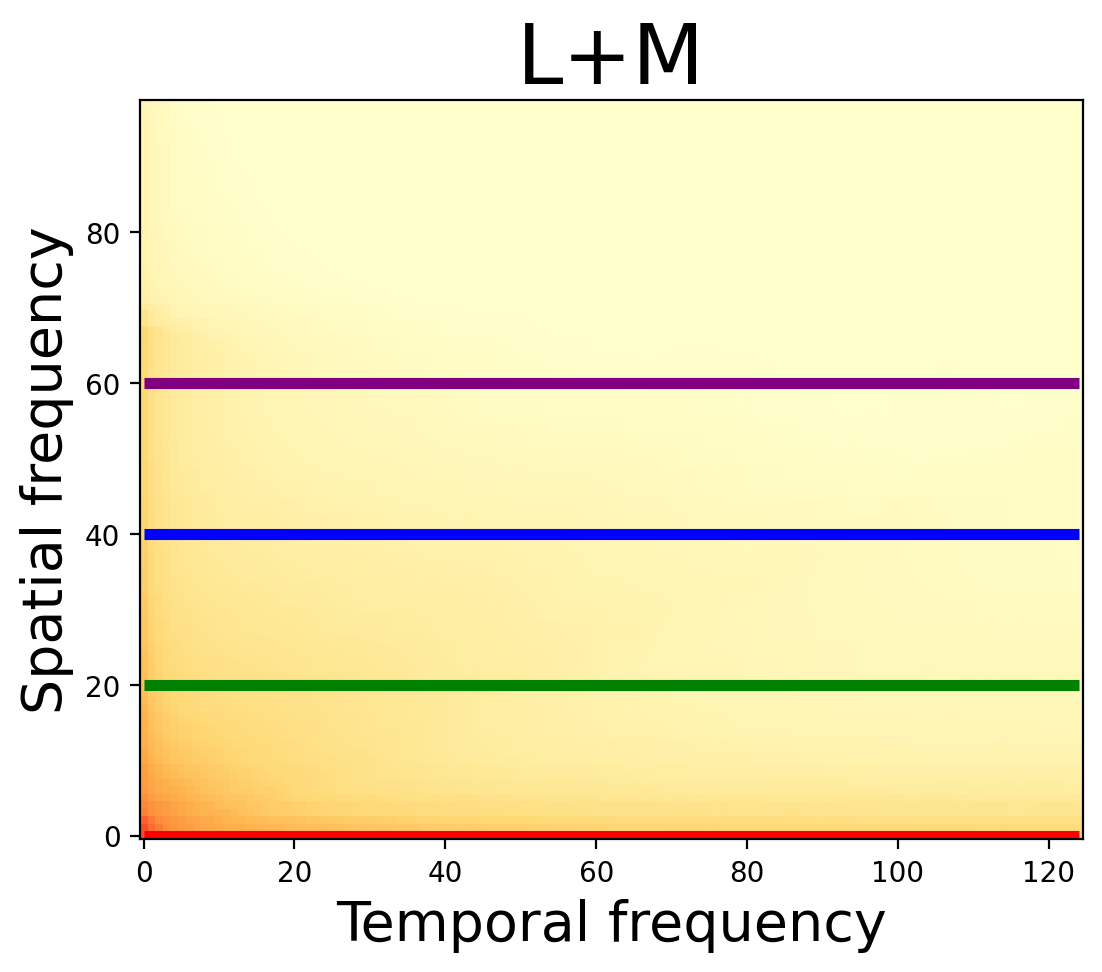

In [54]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'yellow', 'pink', 'darkred', 'olive']
omega_indices = np.array([0,20,40,60])
titles = ["L+M+S", "L+M-S", "L+M"]
for i in range(3):
    plt.figure()
    plt.imshow(np.log(Cx[:,:,i]), origin = 'lower', cmap = 'YlOrRd', vmin = 0, vmax = np.max(np.log(Cx)))
    #plt.vlines(omega_indices, ymin = 0, ymax = Cx.shape[0]-1, colors = colors[0:len(omega_indices)], linewidth = 4)
    plt.hlines(omega_indices, xmin = 0, xmax = Cx.shape[1]-1, colors = colors[0:len(omega_indices)], linewidth = 4)
    plt.xlabel("Temporal frequency", size = 20); plt.ylabel("Spatial frequency", size = 20)
    plt.title(titles[i], size = 30)


#Cx_smooth = scipy.ndimage.gaussian_filter(Cx, sigma = (2,0,0), order = 0)
#plt.figure();plt.imshow(np.log(Cx_smooth[:,:,0]))

Text(0.5, 1.0, 'Log(L+M+S) - Log(L-M)')

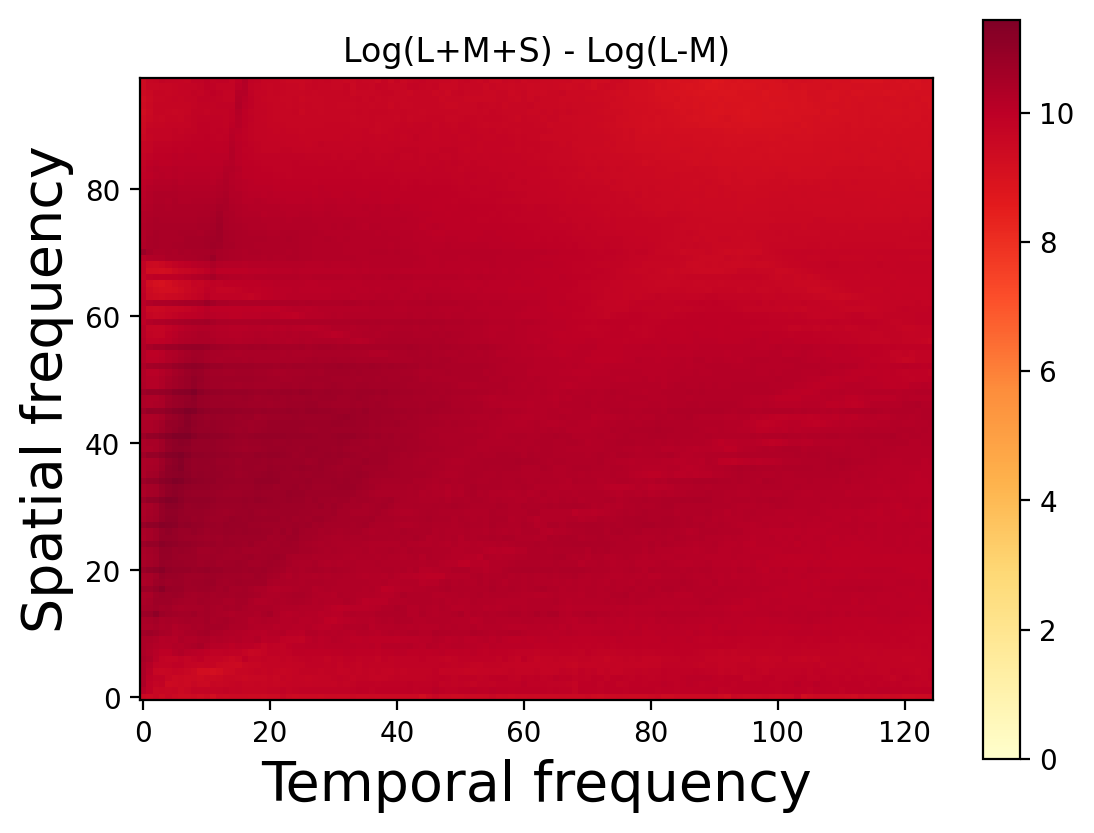

In [55]:
plt.figure()
plt.imshow(np.log(Cx_pre[:,:,0]) - np.log(Cx_pre[:,:,2]), origin = 'lower', cmap = 'YlOrRd', vmin = 0)
#plt.vlines(omega_indices, ymin = 0, ymax = Cx.shape[0]-1, colors = colors[0:len(omega_indices)])
plt.xlabel("Temporal frequency", size = 20); plt.ylabel("Spatial frequency", size = 20)
plt.colorbar()
plt.title("Log(L+M+S) - Log(L-M)")

Text(0.5, 1.0, '$\\omega = $0, median filtering')

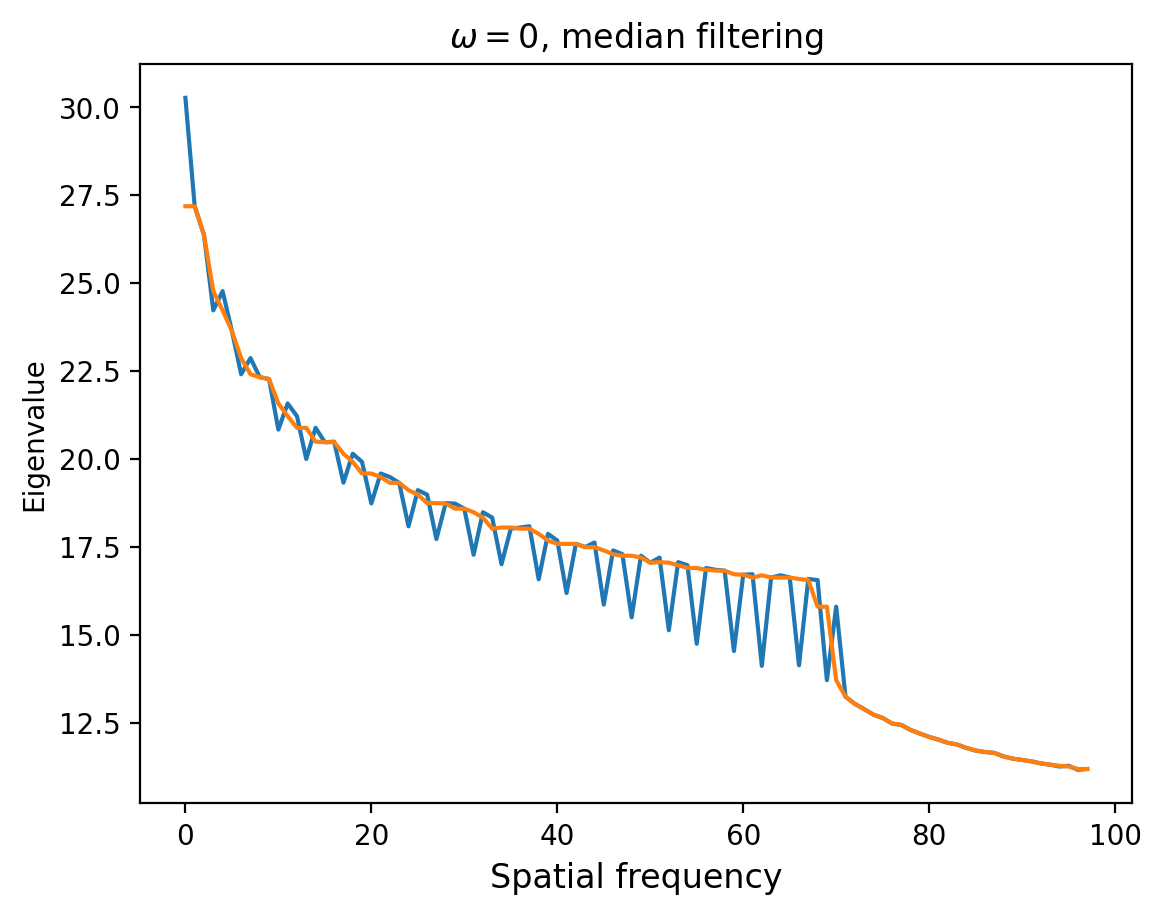

In [56]:
omega = 0
#fig, ax = plt.subplots(1,2)
plt.plot(np.log(Cx_pre[:,omega,0]))
plt.plot(np.log(Cx[:,omega,0]))
plt.xlabel("Spatial frequency", size = 12)
plt.ylabel("Eigenvalue", size = 10)
plt.title(r"$\omega = $" + str(omega) + ", median filtering")

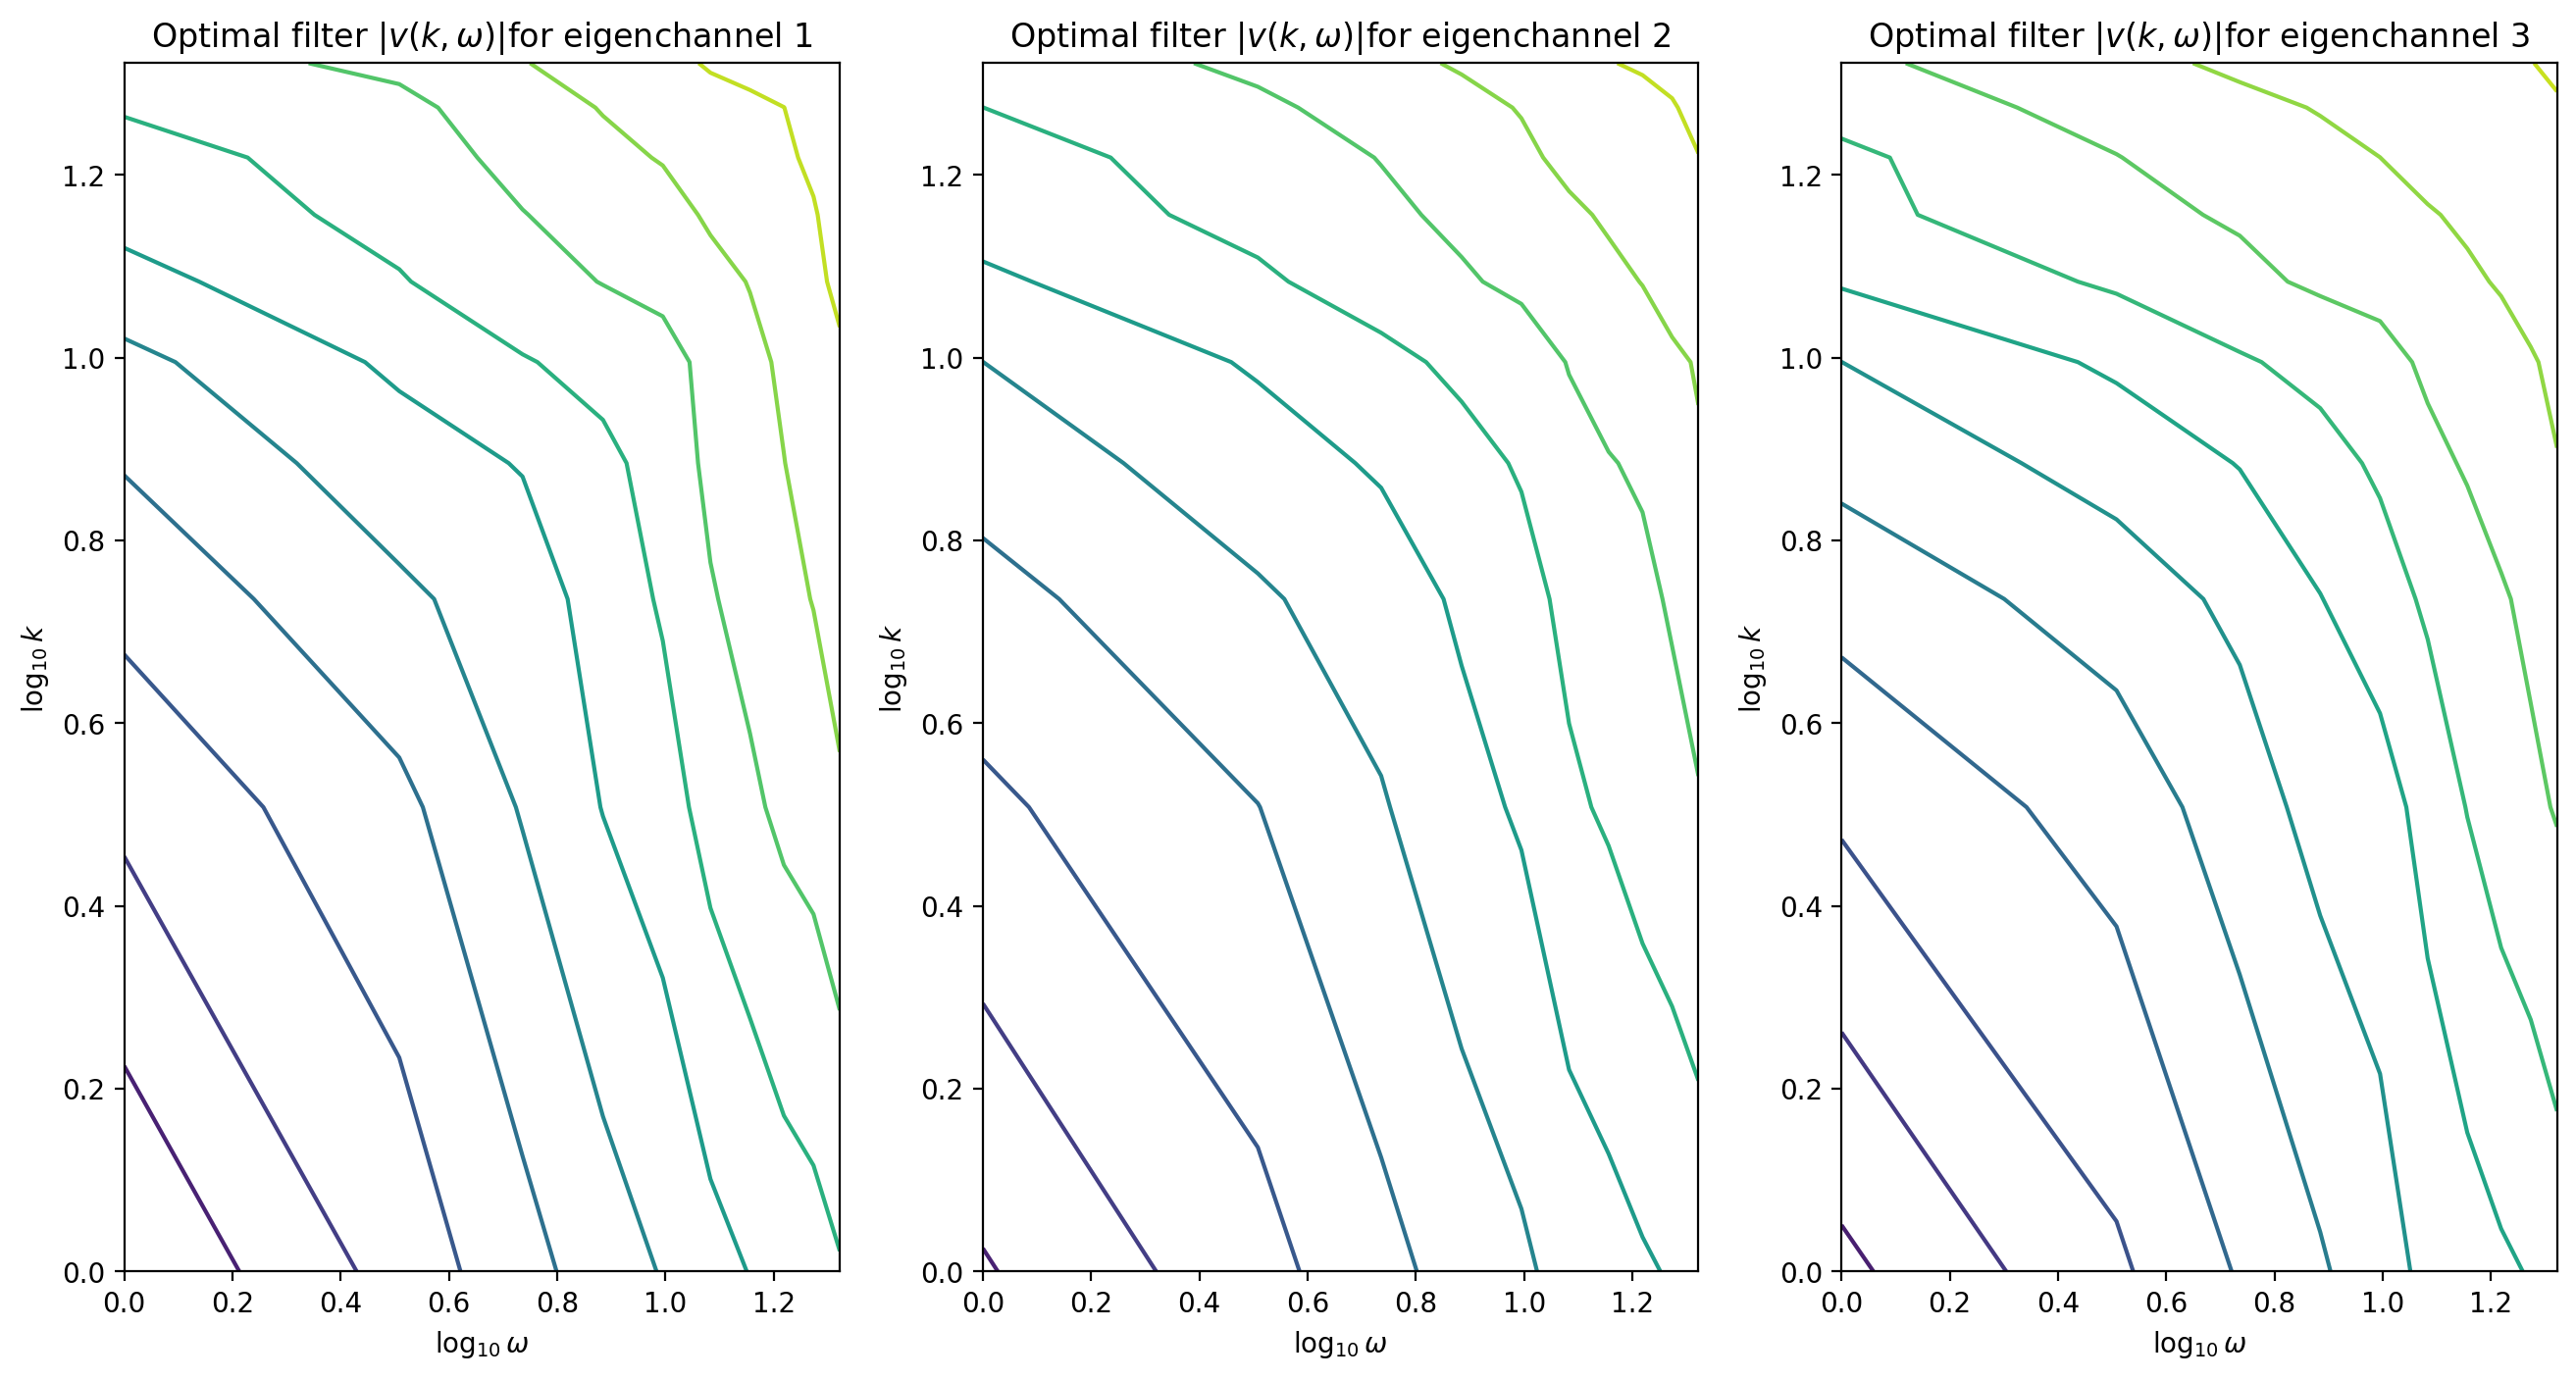

In [57]:
#Bug 1: needed to multiply kf by A**(1/alpha) instead of just A
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

omega_range_mul = 4
k_range_mul = 1
A = np.array([100,10,1])
if A.shape[0] > 1:
    n_plots = A.shape[0]
else: 
    n_plots = 2
fig, ax = plt.subplots(1, n_plots, figsize=(16, 8))
k0_list = [k0 for k0 in np.linspace(0, 100, 5)]
o0_list = [o0 for o0 in np.linspace(0, 250, 5)]

#freqs_k_small = np.linspace(50,60,10)
#freqs_omega_small = np.linspace(50,60,10)
freqs_k_small = np.linspace(1,21,10)
freqs_omega_small = np.linspace(1,21,10)

oo, kk = np.meshgrid(freqs_omega_small, freqs_k_small)

vfun = filter(Cx, sigout, nu)
for i in range(A.shape[0]):
    v = vfun(kk, oo, i)
    #Ck = Cx[kk, oo, i]
    ax[i].contour(np.log10(oo), np.log10(kk), np.log10(v), levels=10)
    ax[i].set_title(r"Optimal filter $|v(k, \omega)|$" + "for eigenchannel " + str(i+1))
    ax[i].set_ylabel(r"$\log_{10} k$")
    ax[i].set_xlabel(r"$\log_{10} \omega$");
    #ax[i].text(*label_loc, r'\textbf{A}', transform=ax[i].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
    #for k0, o0 in zip(k0_list, o0_list):
    #    ax[i].scatter(np.log10(o0), np.log10(k0))

In [58]:
L = 100  # linear size of space in one dimension
T = 50 # size of time

zz = np.linspace(-L/2, L/2, N)
tt = np.linspace(-T/2, T/2, M)
dz = zz[1] - zz[0]
dt = tt[1] - tt[0]

#First frequencies are positive, I shouldn't use fftshift!!!
#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
#freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)

k_low = 0 
o_low = 0 
freqs_k_small = np.linspace(50,60,10)
freqs_omega_small = np.linspace(50,60,10)

oo, kk = np.meshgrid(freqs_omega_small, freqs_k_small)
vfun = filter(Cx, sigout, nu)

def create_information_eps(fixed_freq, freqs, fixed_type):
    def information_eps(log_eps):
        infos = []
        for i in range(n_channels):
            eps_eigenchannel = np.exp(log_eps[i])
            if fixed_type == 'spatial':
                ktilde = 1/Cx[int(fixed_freq),:, i]
            elif fixed_type == 'temporal':
                ktilde = 1/Cx[:,int(fixed_freq), i]
            numer = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-32)) * (np.sqrt(1 + 4 * ktilde/(eps_eigenchannel * sigout**2)) - 1) - sigout**2) + sigout**2
            denom = np.maximum(0, sigout**2 /(2 * (ktilde + 1)) * (np.sqrt(1 + 4 * ktilde/(eps_eigenchannel * sigout**2)) + 1) - sigout**2) + sigout**2
            info = np.sum(np.log(numer) - np.log(denom))
            infos.append(info)
        return np.sum(infos)*-1
    return information_eps

def filter_k(fixed_freq, indices, eps, fixed_type, channel, k_lims=None, return_ktilde = False):
    def v_opt(indices):
        #print("This is k", k)
        #print("eps:",eps)
        if fixed_type == 'spatial':
            inter = np.clip(C_interpolate(int(fixed_freq),indices, channel), 1e-32, np.inf).T
            ktilde = 1/inter
        elif fixed_type == 'temporal':
            inter = np.clip(C_interpolate(indices, int(fixed_freq), channel), 1e-32, np.inf)
            ktilde = 1/inter
        #print(ktilde.shape, len(indices))
        ktilde = pad_and_reflect(ktilde[:,0],ktilde.shape[0]*2 - 2)
        #plt.plot(ktilde)
        #print("hello", fixed_freq, freqs)
        #print("sqrt_piece,", np.min(1 + (4/eps) * ktilde), np.argmin(ktilde))
        sqrt_piece = np.sqrt(1 + (4/eps) * ktilde)
        
        v2 = 0.5 * (sqrt_piece + 1) / (1 + ktilde) - 1
        #print("v2 v1", np.mean(v2))
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2)
        #print("v2 mean", np.mean(v2), np.abs(k/kf)**power)
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        if not return_ktilde:
            return v2
        else:
            return ktilde
    return v_opt

def filter(C, nu, k_lims=None):
    def v_opt(k, o, i):
        CC = np.minimum(C_interpolate(k, o, i), 1e32)
        sqrt_piece = np.sqrt(CC**2 + (4/nu) * (1/sigout**2) * CC)
        v2 = 0.5 * (sqrt_piece + CC) / (1 + CC) - 1
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2)
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        #print("Hello there!!!")
        return v2 #- np.min(v2)
    return v_opt

def pad_and_reflect(filter, N, padval=0):
    """
    Zero-pad to length N//2 and reflect about origin to make length N. 
    """
    #print(N//2 + 1, len(filter), 'debug this plz')
    #print(len(filter), N//2+1)
    expanded = np.pad(filter, (0, N//2 + 1 - len(filter)), constant_values=(0, padval))
    return np.concatenate([expanded[::-1], expanded[1:]])

def extrap_and_reflect(filter, N, return_log=False):
    """
    Linearly extrapolate the log filter to better approximate tails and reflect 
    about origin to make length N.
    """
    extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')
    expanded = extrap_fun(range(0, N//2 + 1))
    if not return_log:
        expanded = np.exp(expanded)
    return np.concatenate([expanded[::-1], expanded[1:]])

def filter_power(eps, fixed_freq, indices, klims, channel, fixed_type):
    vfun = filter_k(fixed_freq, indices, eps, fixed_type, channel, klims)
    v2 = vfun(indices)
    if fixed_type == 'spatial':
        ktilde = 1/C_interpolate(int(fixed_freq), indices, channel)
    elif fixed_type == 'temporal':
        ktilde = 1/C_interpolate(indices, int(fixed_freq), channel)
    
    ktilde = pad_and_reflect(ktilde[:,0],ktilde.shape[0]*2 - 2)
    #dk = freqs[1] - freqs[0]
    dk = 2*np.pi/len(indices)
    #print("subset of power", np.sum(v2**2))
    #print(v2.shape, freqs.shape, ktilde.shape, dk.shape)
    #print(np.sum(np.isnan(v2)), np.sum(np.isnan(np.array(freqs))), np.sum(np.isnan(np.array(ktilde))))
    freqs = indices*2*np.pi/len(indices)
    freqs = pad_and_reflect(freqs, len(freqs)*2 - 2)
    #print('hi', freqs.shape, v2.shape, ktilde.shape)
    return np.sum(v2**2 * np.abs(freqs) * (ktilde + 1) * dk)/(2 * np.pi)**2
    #John: Needs to make sure I do the conversion from integral to sum correctly
    #Need to make srue dk is the correct value. dk = 2*pi/L
    #By convention, frequencies discrete are -pi to pi. My frequencies are from 0 to L. 

def excess_power(log_eps, fixed_freq, indices, klims, P, fixed_type):
    total_power = 0
    for i in range(n_channels):
        #print(kf_noA*(A[i]**(1/alpha)))
        #if A_type == 'kf':
        #    Af = A[i]**(1/alpha)
        #elif A_type == 'of':
        #    Af = np.sqrt(A[i])
        eig_power = filter_power(10**log_eps[i], fixed_freq, indices, klims, i, fixed_type)
        total_power += eig_power
        #print("eig_power", eig_power, i)
        #print("loss", P-total_power)
    return P - total_power

def optimal_logeps(fixed_freq, indices, klims, P, fixed_type):
    power_constraint = {'type': 'ineq', 'fun': excess_power, 'args': (fixed_freq, indices, klims, P, fixed_type)}
    eps_fun = create_information_eps(fixed_freq, indices, fixed_type)
    res = opt.minimize(eps_fun, np.array([-2,-2,-2]), bounds=[(-16, np.inf)], constraints=[power_constraint])
    if res.success:
        #print("Excess power: ", excess_power(res.x, fixed_freq, indices, klims, P, fixed_type))
        return res.x
    else:
        print("Optimizer failed to converge!")
        return None

In [59]:
U.shape

(98, 125, 3, 3)

[-1.16046608 -1.68007618 -2.96232301]
Hello Sir (195,) 97
(98,)
Hello Sir (195,) 97
(98,)
Hello Sir (195,) 97
(98,)


/tmp/ipykernel_1384805/2188914047.py:25: RuntimeWarning: overflow encountered in exp
  eps_eigenchannel = np.exp(log_eps[i])
/tmp/ipykernel_1384805/2188914047.py:130: RuntimeWarning: overflow encountered in scalar power
  eig_power = filter_power(10**log_eps[i], fixed_freq, indices, klims, i, fixed_type)


[  -1.92183298   -2.86720563 1510.91958874]
Hello Sir (195,) 97
(98,)
Hello Sir (195,) 97
(98,)
Hello Sir (195,) 97
(98,)
Zero vspace for kf:  15 0
Zero vspace for kf:  15 1
Zero vspace for kf:  15 2


/tmp/ipykernel_1384805/1295420234.py:50: RuntimeWarning: overflow encountered in scalar power
  vv = filter_k(fixed_omega, k_indices, 10**log_eps[i], 'temporal', i)(k_indices)


[-2.71575753 -3.36255508 13.2328201 ]
Hello Sir (195,) 97
(98,)
Hello Sir (195,) 97
(98,)
Hello Sir (195,) 97
(98,)
Zero vspace for kf:  45 0
Zero vspace for kf:  45 1
Zero vspace for kf:  45 2
[-2.91009158 -3.44745936 -5.96201977]
Hello Sir (195,) 97
(98,)
Hello Sir (195,) 97
(98,)
Hello Sir (195,) 97
(98,)
Zero vspace for kf:  65 0
Zero vspace for kf:  65 1
Zero vspace for kf:  65 2


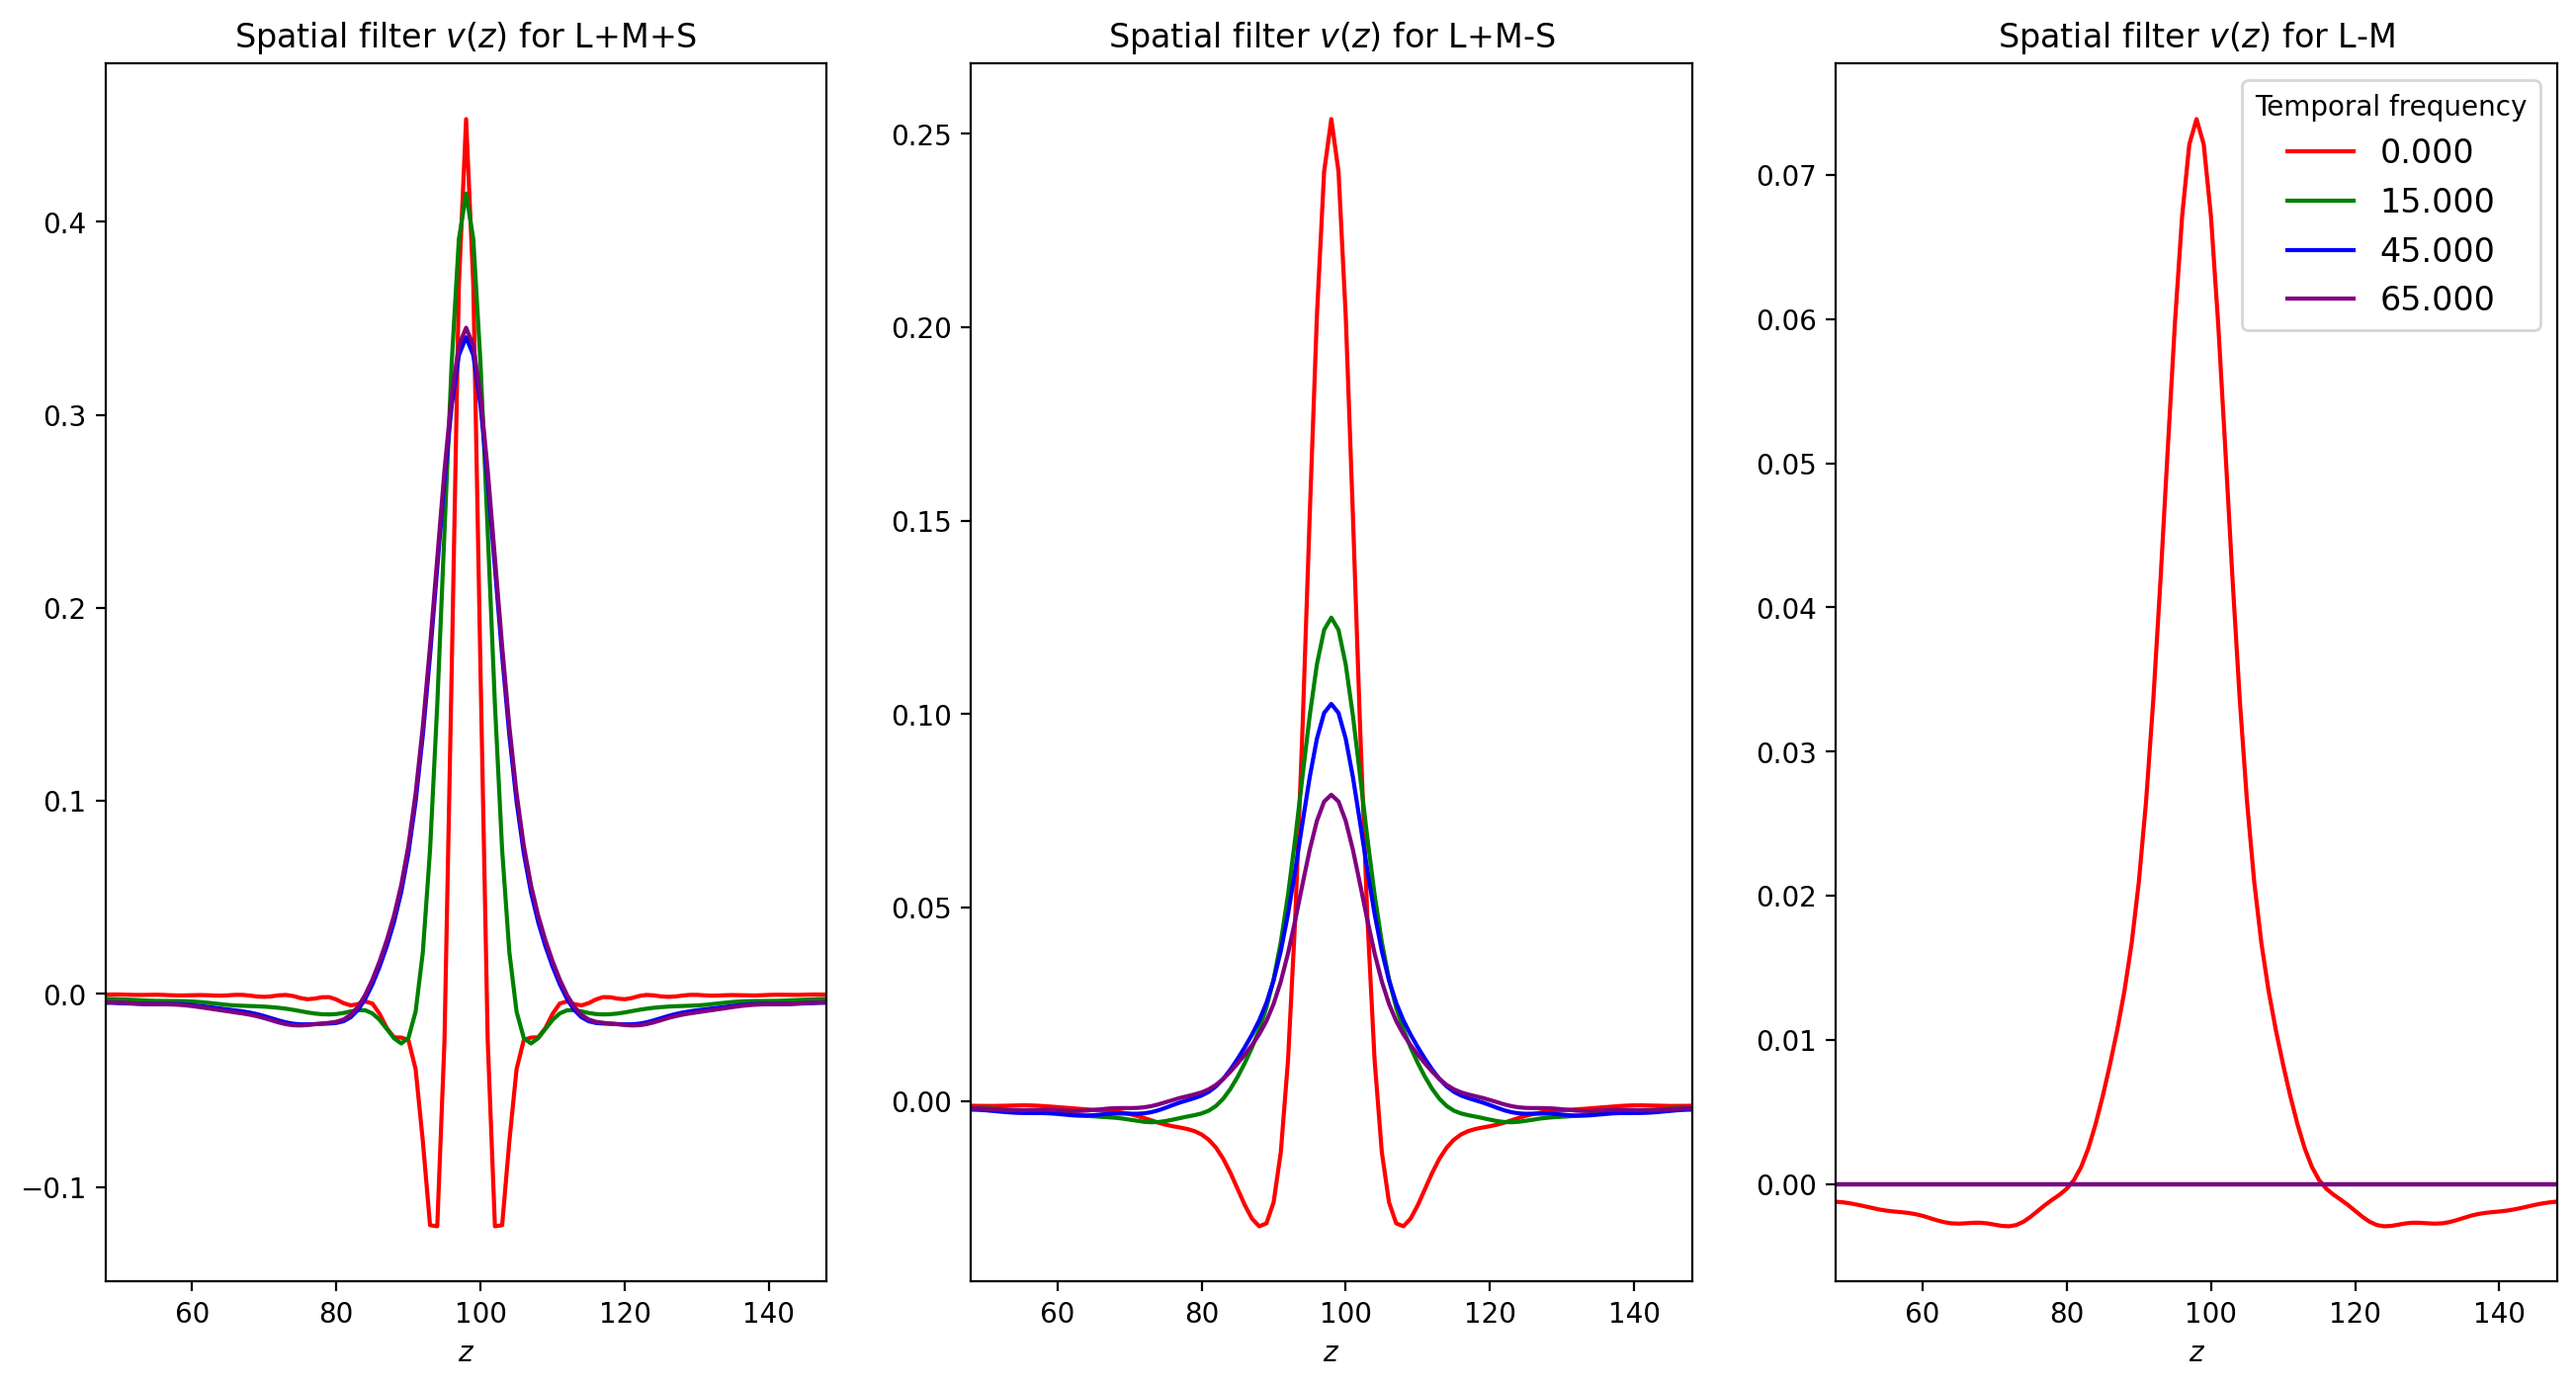

In [86]:


fig, ax = plt.subplots(1, 3, figsize=(16, 8))
P = 1
#dz = 1e-4
N = Cx.shape[0]
dz = 1#Cx.shape[0]/N

#In hindsight, these should be indices instead of frequencies!!! *IMPORTANT
#John: dz = 1/n_pixels 
#Lower frequency is 2*pi/L

#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
#freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)

k_min = 0
k_max = 98
k_indices = np.linspace(k_min, k_max -1, k_max - k_min)
#omega_indices = np.array([0,10,20,30])
omega_indices = np.array([0,15,45,65])

#freqs_k = (scipy.fft.fftfreq(N, d=dz) * np.pi)[0:N//2+1

#freqs_k = Cx.shape[0]*freqs_k[0:int(N/2)]/np.max(freqs_k[0:int(N/2)])


#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
L = (len(k_indices)//2) * dz
zz = np.linspace(-L/2, L/2, N)

# make a double exponential smoothing filter
fz = np.arange(-.2,.2, 0.01)
ff = np.exp(-20 * np.abs(fz))
ff /= np.sum(ff)
vv_all = []
vf_all = []
vvf_all = []
vspace_all = []


colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'yellow', 'pink', 'darkred', 'olive']
c = 0
lines = []
channel_labels = ['L+M+S', 'L+M-S', 'L-M']

for fixed_omega in omega_indices:
    log_eps = optimal_logeps(fixed_omega, k_indices, None, P, 'temporal')
    #log_eps = log_eps[::-1]
    print(log_eps)
    vspace_omega = []
    for i in range(n_channels):
        vv = filter_k(fixed_omega, k_indices, 10**log_eps[i], 'temporal', i)(k_indices)
        #vv = vv[:,0]
        #vv = vv[::-1]
        vv_all.append(vv)
        #if np.max(vv) > 0:
        #vf = np.convolve(vv[N//2:], ff, mode='same')
        #Remove negative frequencies from vv
        print("Hello Sir", vv.shape, vv.shape[0]//2)
        vv = vv[vv.shape[0]//2:]
        

        vf = np.convolve(vv, ff, mode = 'same')
        vf_all.append(vf)
        #The bug is here :) in the fft convention~
        print(vf.shape)
        vvf = pad_and_reflect(vf, vf.shape[0]*2)
        #vvf = vf
        
        vvf_all.append(vvf)
        vspace = np.real(scipy.fft.fft(vvf))
        vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
        vspace_omega.append(vspace)
        vspace_all.append(vspace)
    vspace_omega = np.array(vspace_omega)
    vspace_omega /= np.linalg.norm(vspace_omega)
    for i in range(n_channels):
        if np.mean(vspace) == 0:
            print("Zero vspace for kf: ", fixed_omega, i)
        #line, = ax[i].plot(zz, vspace, color = colors[c], label = str(('{:.3f}').format(fixed_omega)))
        line, = ax[i].plot(vspace_omega[i,:], color = colors[c], label = str(('{:.3f}').format(fixed_omega)))
        
        center = int(vspace.shape[0]/2)
        plot_range = 50
        ax[i].set_xlim(center - plot_range, center + plot_range)   
        #ax[i].set_yticks([])
        ax[i].set_xlabel(r"$z$")
        ax[i].set_title(r"Spatial filter $v(z)$ for " + channel_labels[i]);
        #else:
           # print("Filter was zero for channel " + str(i) + " at temporal frequency " + str(fixed_omega))
    lines.append(line)
    c += 1    
ax[i].legend(handles=lines, title = "Temporal frequency", fontsize = 12)
    #ax[0].text(*label_loc, r'\textbf{B}', transform=ax[0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    #cbar = fig.colorbar(s)
    #cbar.ax.tick_params(labelsize=50)

In [84]:
test = vv[:, np.newaxis]*U[:,0,0,:]
U[50,10,:,:]

array([[ 0.59707477,  0.3570063 ,  0.71836497],
       [ 0.59835743,  0.39824687, -0.69524655],
       [ 0.53429344, -0.844952  , -0.02416591]])

log_eps:  [-0.99914431 -2.20793191 -3.26875867]


/tmp/ipykernel_1377805/2188914047.py:94: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')
/tmp/ipykernel_1377805/2188914047.py:130: RuntimeWarning: overflow encountered in scalar power
  eig_power = filter_power(10**log_eps[i], fixed_freq, indices, klims, i, fixed_type)
/tmp/ipykernel_1377805/2188914047.py:25: RuntimeWarning: overflow encountered in exp
  eps_eigenchannel = np.exp(log_eps[i])


log_eps:  [ -2.09005284  -2.81535273 635.53854901]


/tmp/ipykernel_1377805/3885935118.py:50: RuntimeWarning: overflow encountered in scalar power
  vv = filter_k(fixed_k, w_indices, 10**log_eps[i], 'spatial', i)(w_indices)


log_eps:  [-2.20299327 -3.17821437 -5.54728144]
log_eps:  [-2.44795932 -3.40224741 -5.98787538]


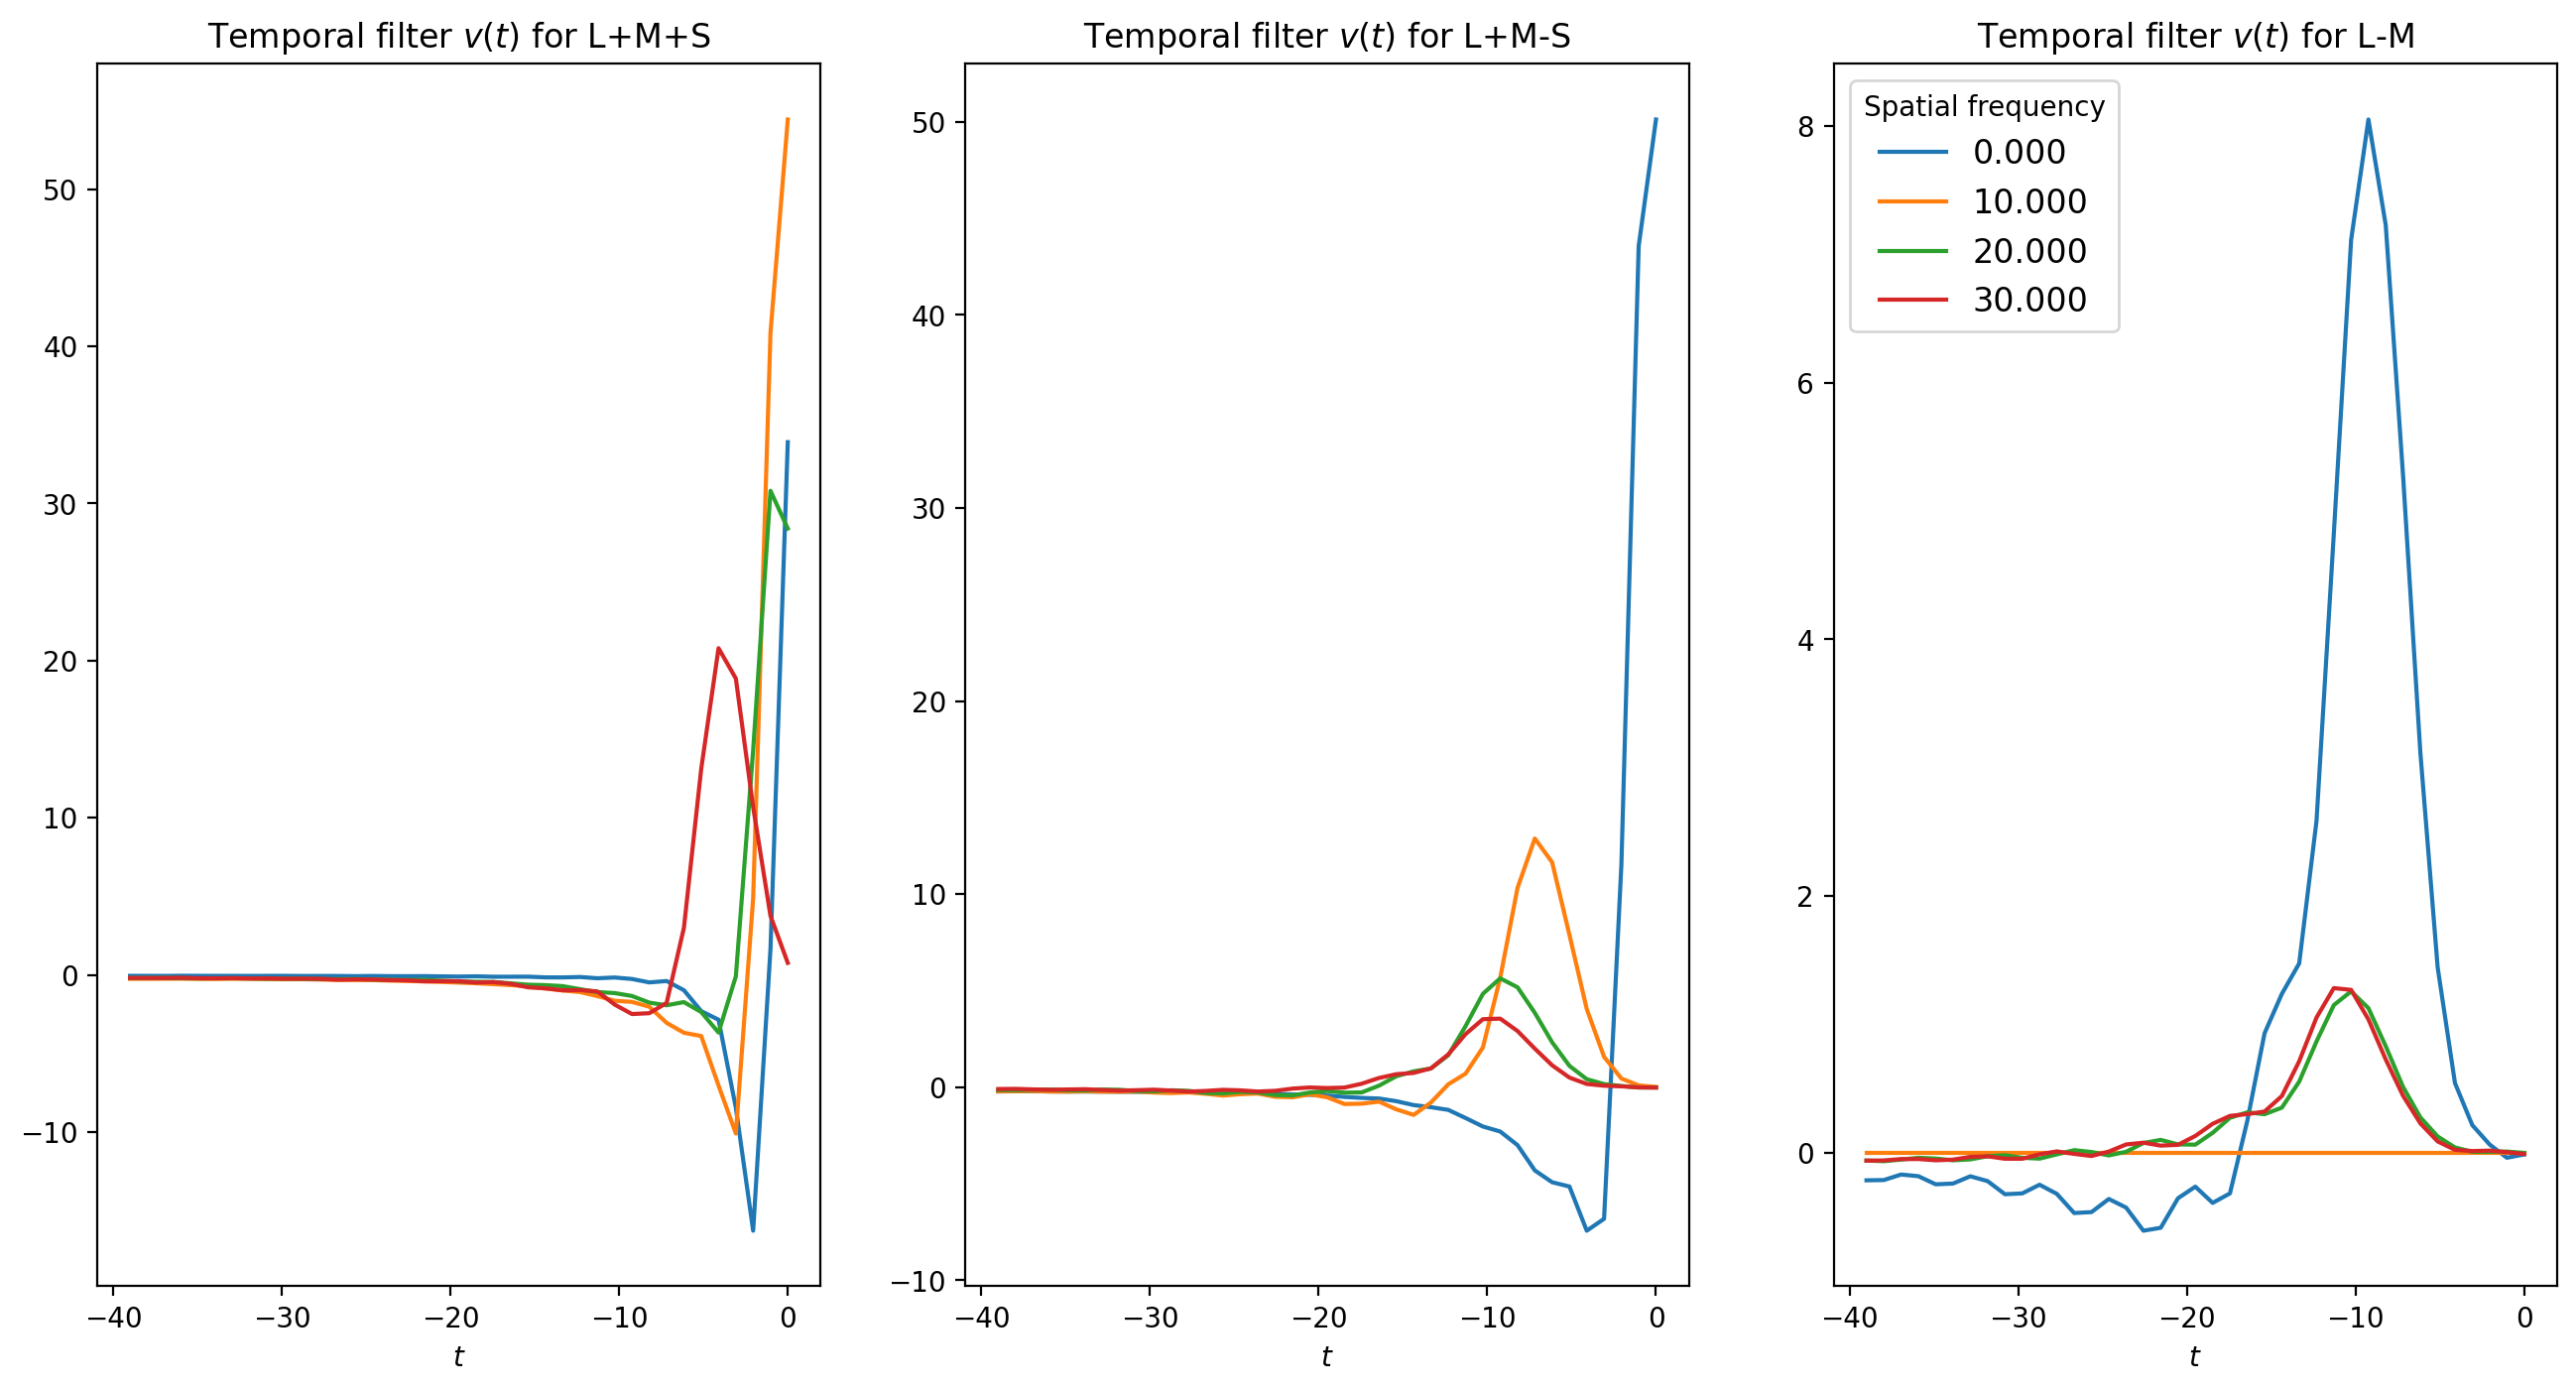

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
P = 1
#dz = 1e-4
N = Cx.shape[0]
dz = 1#Cx.shape[0]/N

#In hindsight, these should be indices instead of frequencies!!! *IMPORTANT
#John: dz = 1/n_pixels 
#Lower frequency is 2*pi/L

#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
#freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)

w_min = 0
w_max = 50
k_indices = np.array([0,10,20,30])
w_indices = np.linspace(w_min, w_max -1, w_max - w_min)

#freqs_k = (scipy.fft.fftfreq(N, d=dz) * np.pi)[0:N//2+1

#freqs_k = Cx.shape[0]*freqs_k[0:int(N/2)]/np.max(freqs_k[0:int(N/2)])


#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
L = (len(k_indices)//2) * dz
zz = np.linspace(-L/2, L/2, N)

# make a double exponential smoothing filter
fz = np.arange(-.2,.2, 0.01)
ff = np.exp(-20 * np.abs(fz))
ff /= np.sum(ff)
vv_all = []
vf_all = []
vvf_all = []
vspace_all = []
vt_all = []


colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'yellow', 'pink', 'darkred', 'olive']
c = 0
lines = []
channel_labels = ['L+M+S', 'L+M-S', 'L-M']

for fixed_k in k_indices:
    log_eps = optimal_logeps(fixed_k, w_indices, None, P, 'spatial')

    print("log_eps: ", log_eps)
    vts = []
    for i in range(n_channels):
        vv = filter_k(fixed_k, w_indices, 10**log_eps[i], 'spatial', i)(w_indices)
        #Prevents artifacts when output filter is 0 for all freqs. 
        vf = np.convolve(vv[vv.shape[0]//2:], ff, mode='same')
        
        log_v = extrap_and_reflect(vf, vv.shape[0], return_log=True)
        log_v_a = np.conj(ssig.hilbert(log_v))
        vt = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(np.exp(log_v_a)))))
        vv_all.append(vv)
        vt_all.append(vt)
        vts.append(vt)
    vts = np.array(vts)
    #vts /= np.linalg.norm(vts)
    t_length = int((vts.shape[1]-1)/2)
    for i in range(n_channels):
        line, = ax[i].plot(np.linspace(-t_length,0, t_length),vts[i,0:t_length], label = str(('{:.3f}').format(fixed_k)))
        if i == 0:
            lines.append(line)
        #ax[i].set_xlim(-0.35, 0.05)
        ax[i].set_xlabel(r"$t$")
        #ax[i].set_yticks([])
        ax[i].set_title(r"Temporal filter $v(t)$ for " + channel_labels[i]);
ax[i].legend(handles=lines, title = "Spatial frequency", fontsize = 12)


/tmp/ipykernel_1374377/2188914047.py:94: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')


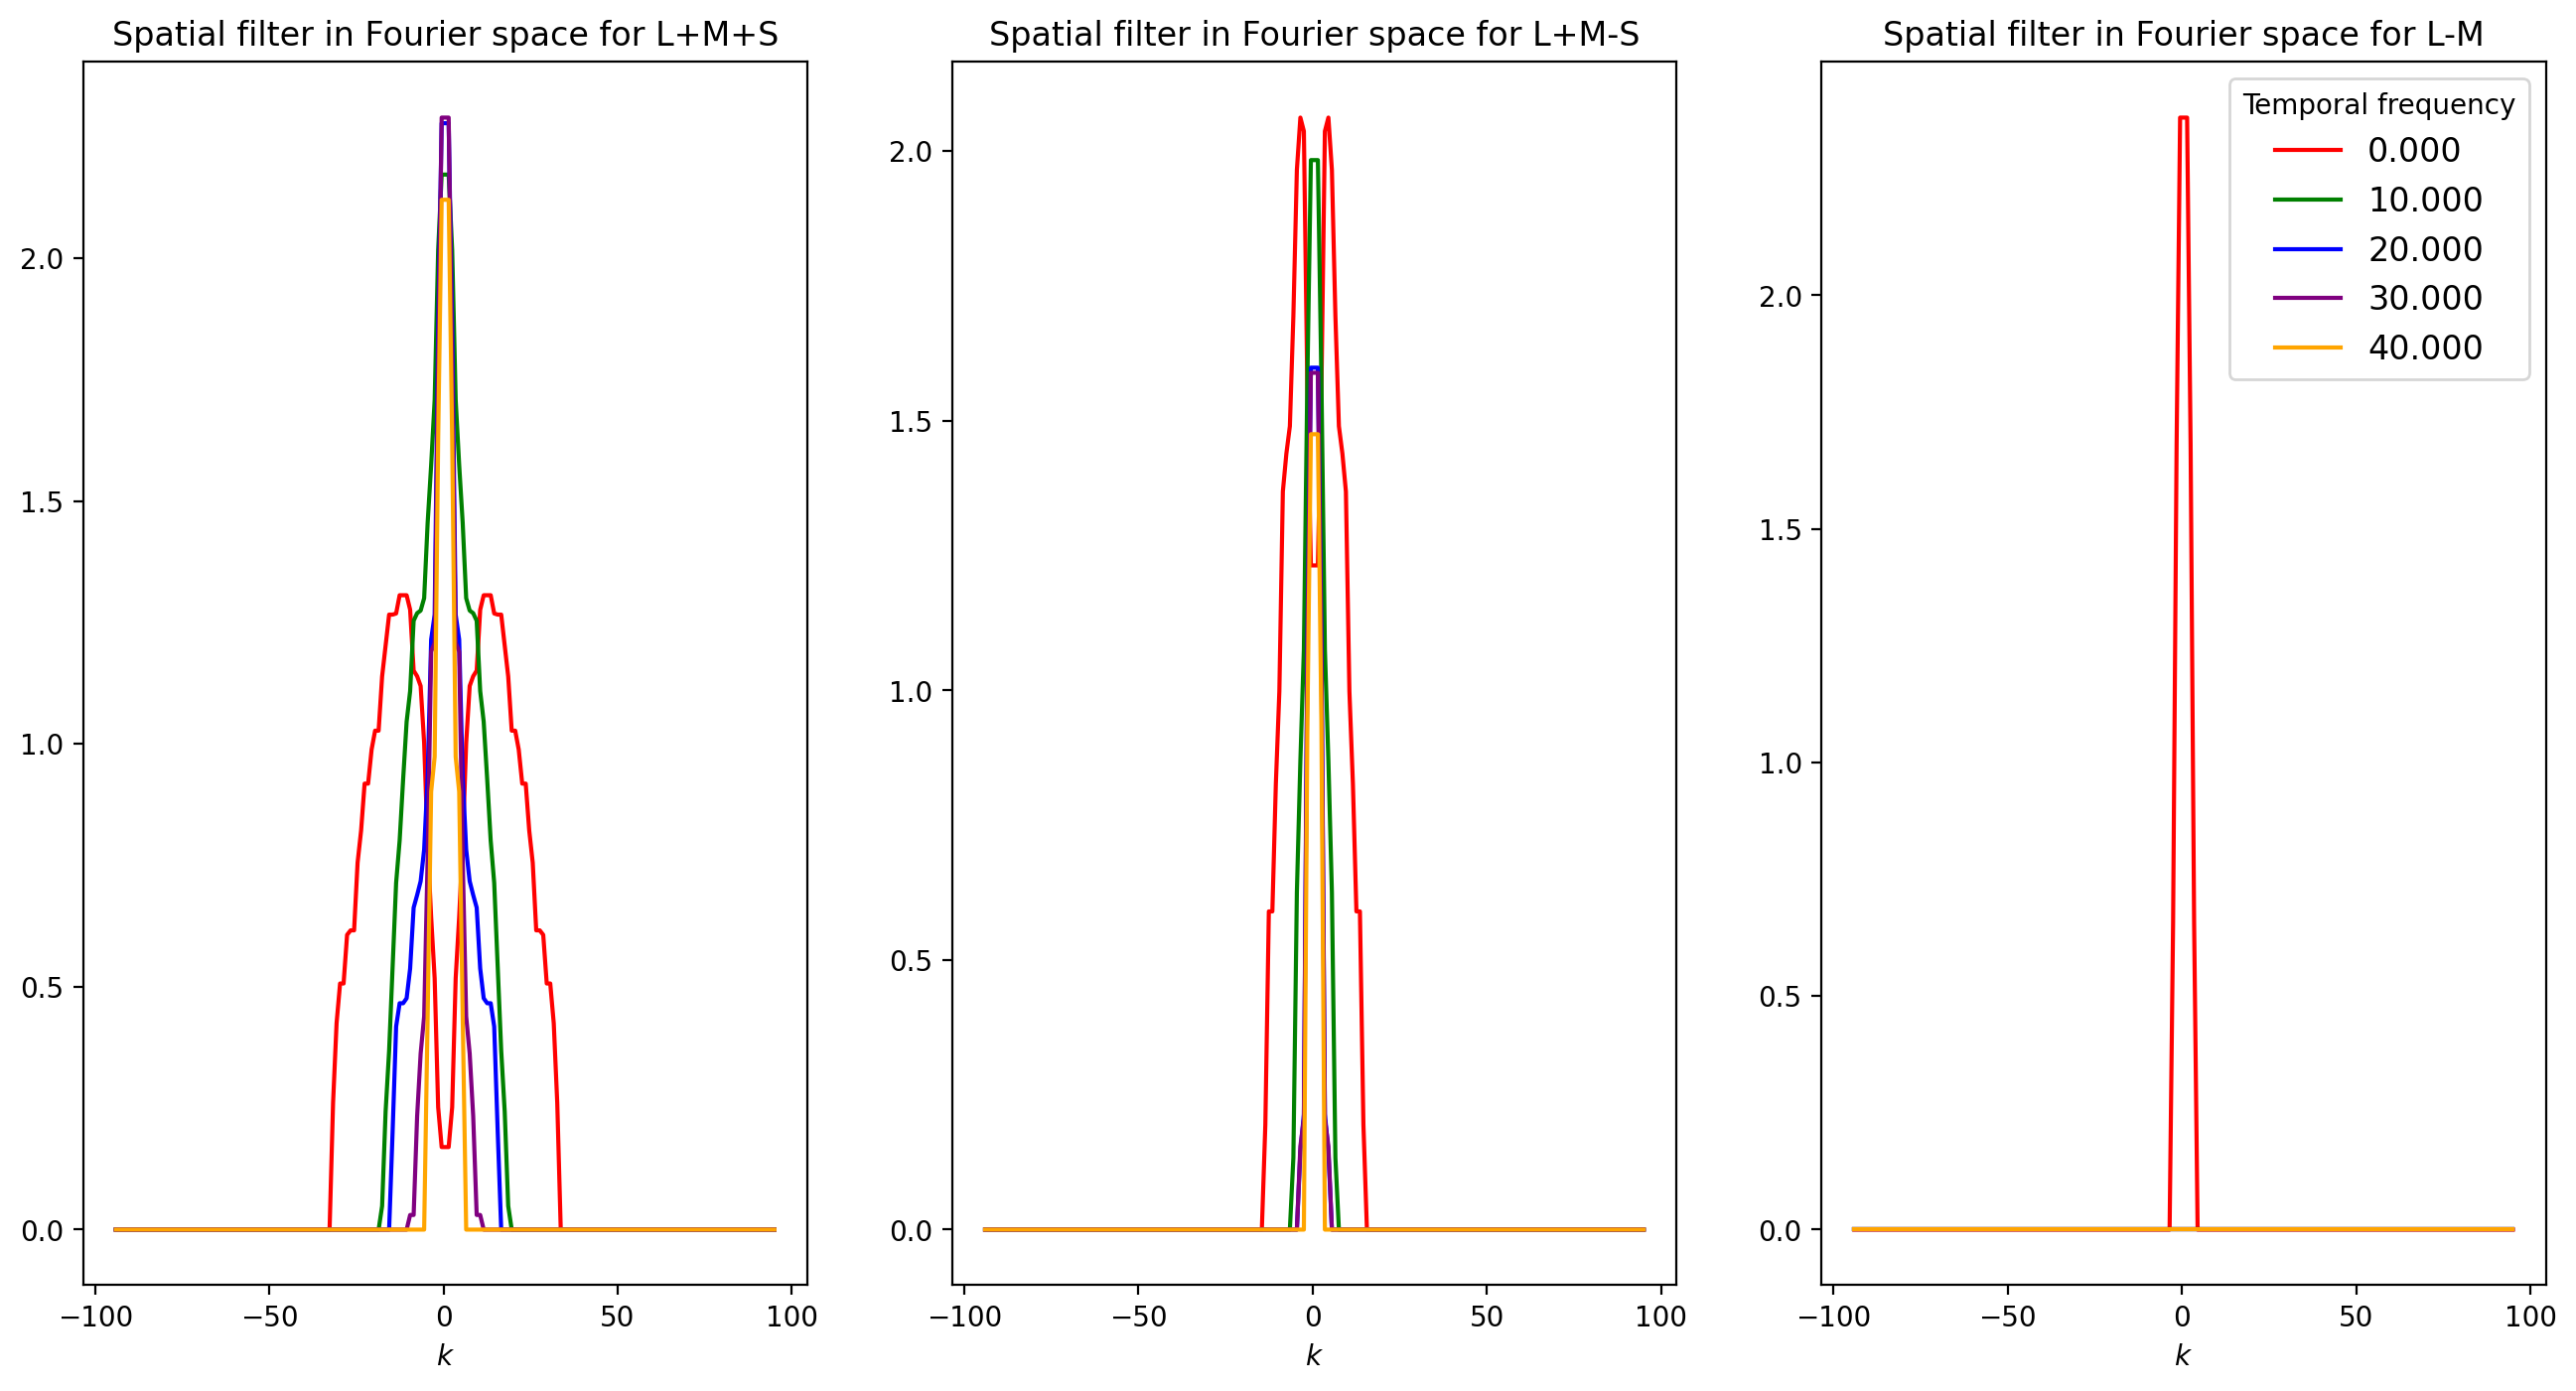

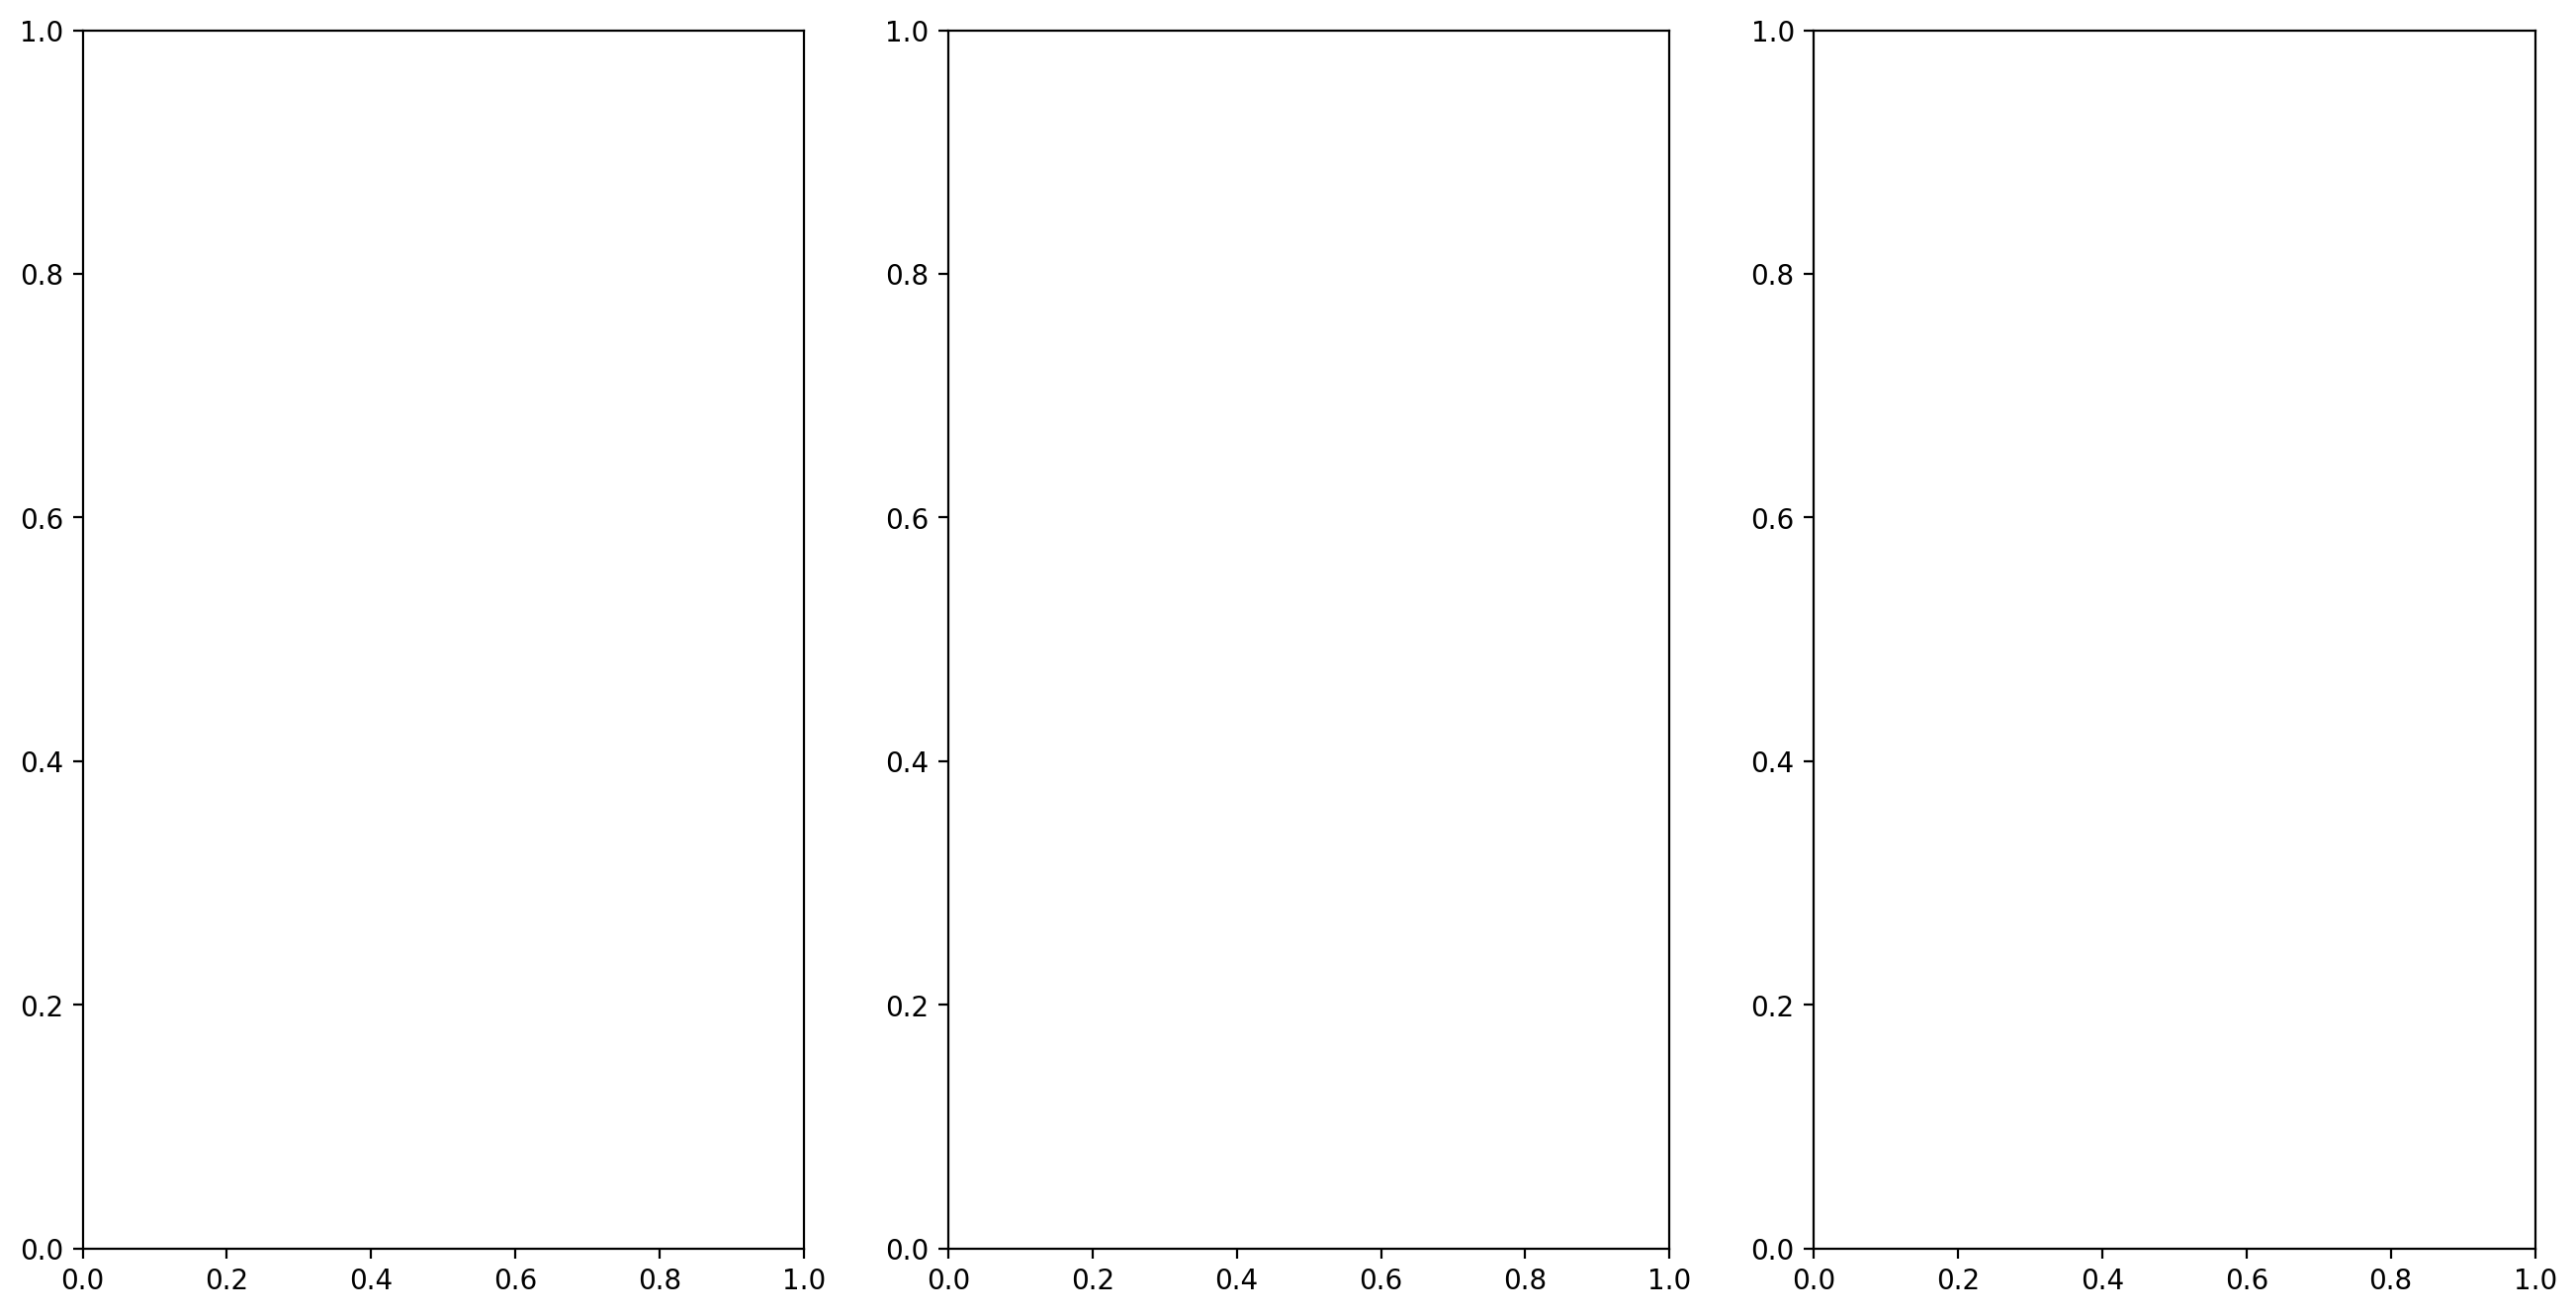

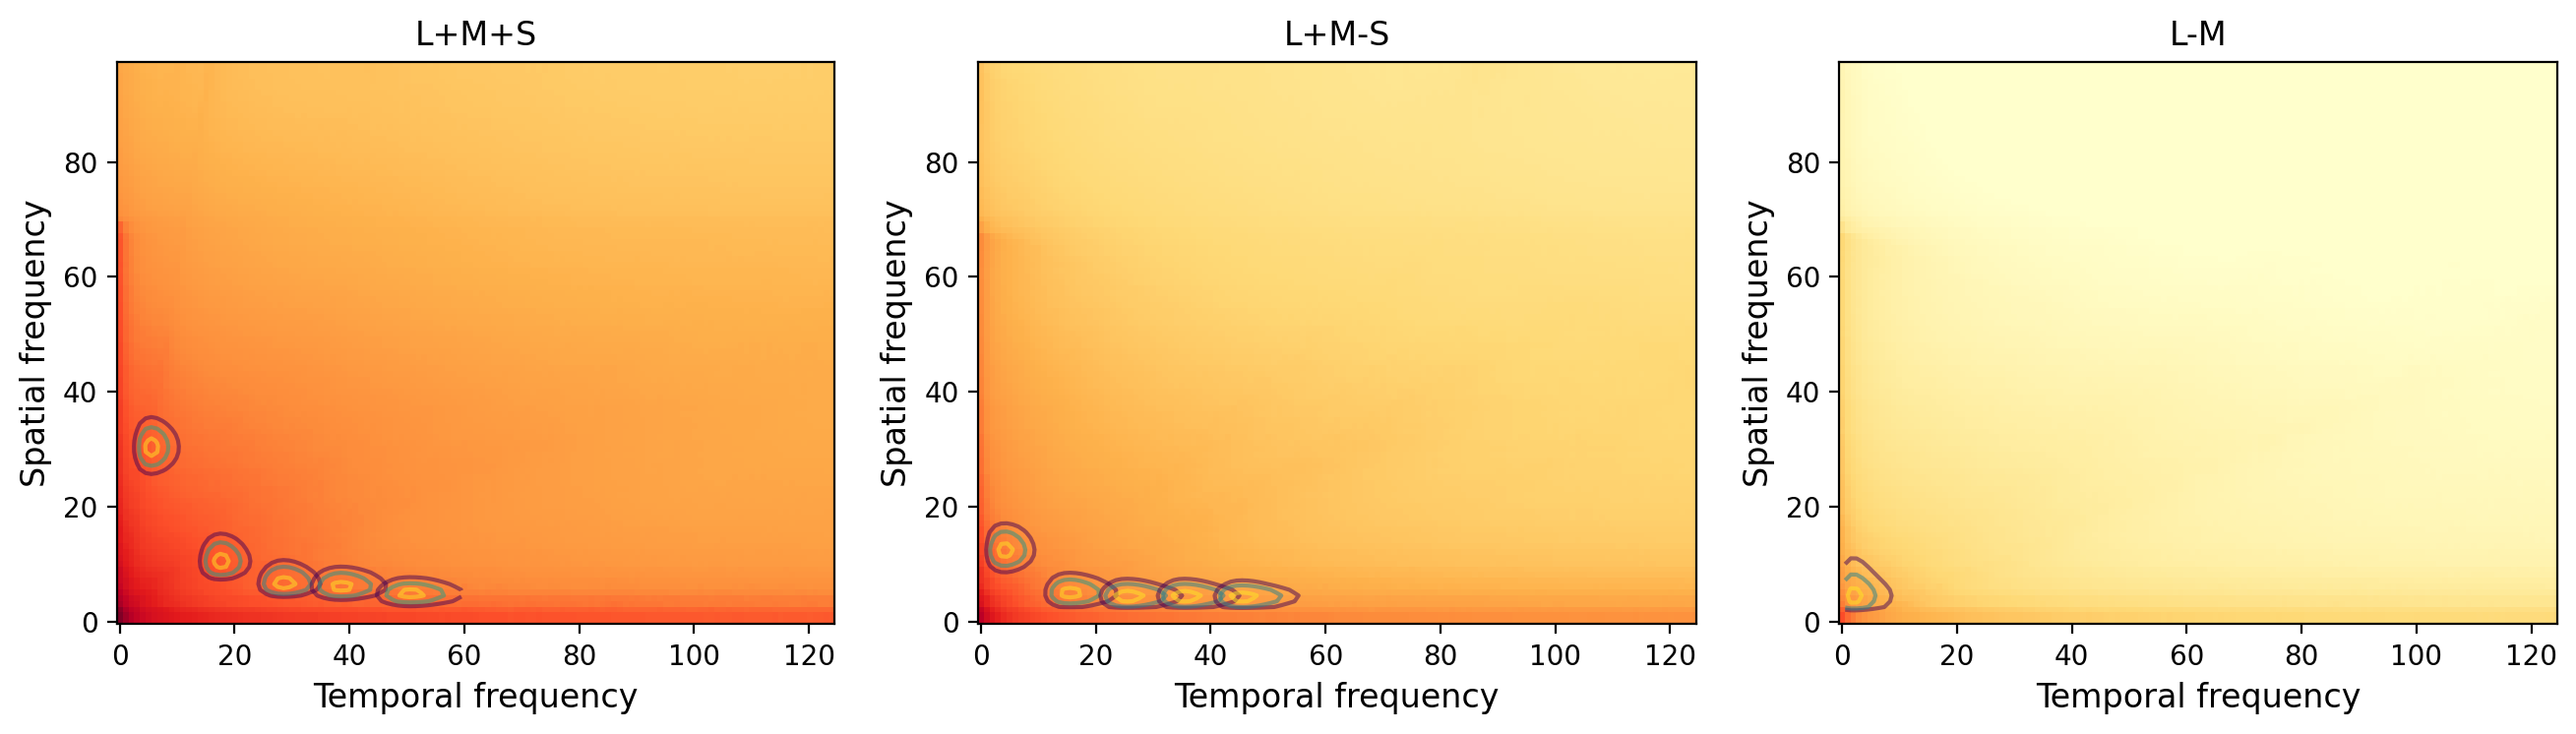

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
fig2, ax2 = plt.subplots(1,3, figsize = (16,8))
fig3, ax3 = plt.subplots(1,3,figsize = (16,8))
P = 1
#dz = 1e-4
N = Cx.shape[0]
dz = 1#Cx.shape[0]/N

#In hindsight, these should be indices instead of frequencies!!! *IMPORTANT
#John: dz = 1/n_pixels 
#Lower frequency is 2*pi/L

#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
#freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)

k_min = 0
k_max = 95
w_min = 0
w_max = 60
k_indices = np.linspace(k_min, k_max -1, k_max - k_min)
w_indices = np.linspace(w_min, w_max -1, w_max - w_min)
#omega_indices = np.array([0,10,20,30,40,50,60])
omega_indices = np.array([0,10,20,30,40])

#freqs_k = (scipy.fft.fftfreq(N, d=dz) * np.pi)[0:N//2+1

#freqs_k = Cx.shape[0]*freqs_k[0:int(N/2)]/np.max(freqs_k[0:int(N/2)])


#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
L = (len(k_indices)//2) * dz
zz = np.linspace(-L/2, L/2, N)

# make a double exponential smoothing filter
fz = np.arange(-.2,.2, 0.01)
ff = np.exp(-20 * np.abs(fz))
ff /= np.sum(ff)
vv_all = []
vf_all = []
vvf_all = []
vspace_all = []

vv2_all = []
vf2_all = []
log_v_all = []
log_v_a_all = []
RF_omega_pre_all = []
RF_omega_all = []


colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'yellow', 'pink', 'darkred', 'olive']
c = 0
lines = []
channel_labels = ['L+M+S', 'L+M-S', 'L-M']
RFs = []



for fixed_omega in omega_indices:
    log_eps = optimal_logeps(fixed_omega, k_indices, None, P, 'temporal')
    #log_eps = log_eps[::-1]
    #print(log_eps)
    vspace_omega = []
    RFs_omega = []
    for i in range(n_channels):
        vv = filter_k(fixed_omega, k_indices, 10**log_eps[i], 'temporal', i)(k_indices)
        #vv_lms = np.matmul(vv,U[:,fixed_omega,i,:])
        #if i == 0:
        #    vv_lms_sum = vv_lms
        #else:
        #    vv_lms_sum += vv_lms 
        
        
        #vv = vv[:,0]
        #vv = vv[::-1]
        vv_all.append(vv)
        #if np.max(vv) > 0:
        #vf = np.convolve(vv[N//2:], ff, mode='same')
        vf = np.convolve(vv[vv.shape[0]//2:], ff, mode = 'same')
        
        
        vf_all.append(vf)
        #The bug is here :) in the fft convention~
        #print(vf.shape)
        vvf = pad_and_reflect(vf, vf.shape[0]*2)
        #vvf = vf
        
        vvf_all.append(vvf)
        vspace = np.real(scipy.fft.fft(vvf))
        vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
        frequencies = np.linspace(0, vv.shape[0], vv.shape[0])-vv.shape[0]/2 + 0.5
        line, = ax[i].plot(frequencies, vv, color = colors[c], label = str(('{:.3f}').format(fixed_omega)))
        
        center = int(vspace.shape[0]/2)
        plot_range = 50
        #ax[i].set_xlim(center - plot_range, center + plot_range)   
        #ax[i].set_yticks([])
        ax[i].set_xlabel(r"$k$")
        ax[i].set_title(r"Spatial filter in Fourier space for " + channel_labels[i]);

        vf_argmax = np.argmax(vf)
        log_eps2 = optimal_logeps(vf_argmax, w_indices, None, P, 'spatial')
        vv2 = filter_k(vf_argmax, w_indices, 10**log_eps2[i], 'spatial', i)(w_indices)
        vv2_all.append(vv2)
        
        #Prevents artifacts when output filter is 0 for all freqs. 
        vf2 = np.convolve(vv2[vv2.shape[0]//2:], ff, mode='same')
        vf2_all.append(vf2)
        
        log_v = extrap_and_reflect(vf2, vv2.shape[0], return_log=True)
        log_v_all.append(log_v)
        
        log_v_a = np.conj(ssig.hilbert(log_v))
        log_v_a_all.append(log_v_a)
        vt = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(np.exp(log_v_a)))))
        #RF_omega = np.outer(vf,vt[0:int(vt.shape[0]/2)])
        RF_omega_pre = np.outer(vf,vf2)
        RF_omega_pre_all.append(RF_omega_pre)
        #RF_omega = np.roll(RF_omega, -fixed_omega + 40, axis = 1)
        RF_omega = np.roll(RF_omega_pre, fixed_omega, axis = 1)
        RF_omega = np.roll(RF_omega, vf_argmax, axis = 0)
        RFs_omega.append(RF_omega)
        #RFs_omega.append(RF_omega)
    RFs_omega = np.array(RFs_omega)#[:,:,::-1]
    RFs.append(RFs_omega)
    
    lines.append(line)
    c += 1    
ax[i].legend(handles=lines, title = "Temporal frequency", fontsize = 12)
RFs = np.array(RFs)
percentile_values = [99,99.5,99.9]
for i in range (3):
    ax3[i].imshow(np.log(Cx[:,:,i]), origin = 'lower', cmap = 'YlOrRd', vmin = 0, vmax = np.max(np.log(Cx)))
    for fixed_omega in range(omega_indices.shape[0]):
        contour_values = []
        for percentile in percentile_values:
            contour_values.append(np.percentile(RFs[fixed_omega,i,:,:], percentile) + percentile*10e-32)
        ax3[i].contour(RFs[fixed_omega, i,:,:], contour_values, origin = 'lower', alpha = 0.5)
        
    ax3[i].set_title(channel_labels[i])
    ax3[i].set_xlabel("Temporal frequency", size = 12)
    ax3[i].set_ylabel("Spatial frequency", size = 12)
    #ax[0].text(*label_loc, r'\textbf{B}', transform=ax[0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    #cbar = fig.colorbar(s)
    #cbar.ax.tick_params(labelsize=50)

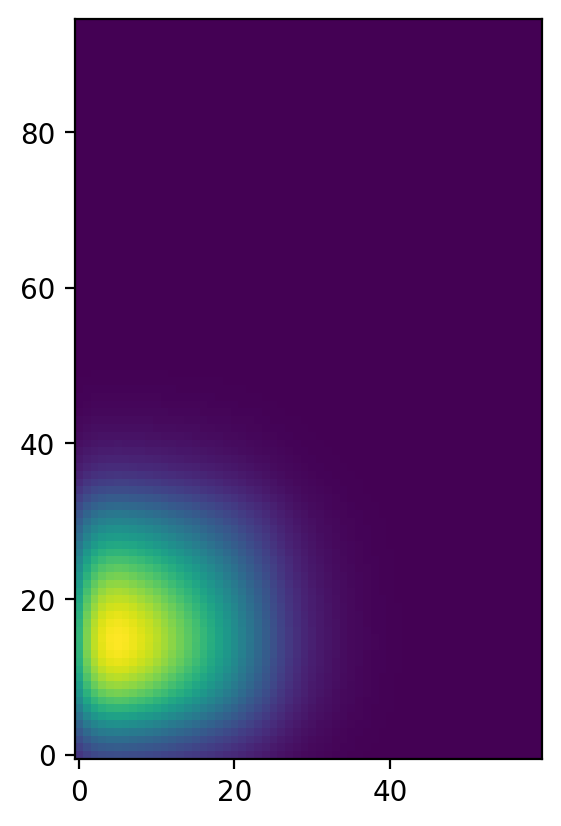

In [79]:
plt.imshow(np.roll(RF_omega_pre_all[0], omega_indices[0], axis = 1), origin = 'lower')


[-1.16046608 -1.68007618 -2.96232301]


/tmp/ipykernel_1384805/2188914047.py:25: RuntimeWarning: overflow encountered in exp
  eps_eigenchannel = np.exp(log_eps[i])
/tmp/ipykernel_1384805/2188914047.py:130: RuntimeWarning: overflow encountered in scalar power
  eig_power = filter_power(10**log_eps[i], fixed_freq, indices, klims, i, fixed_type)


[  -1.92183298   -2.86720563 1510.91958874]


/tmp/ipykernel_1384805/321888458.py:57: RuntimeWarning: overflow encountered in scalar power
  vv = filter_k(fixed_omega, k_indices, 10**log_eps[i], 'temporal', i)(k_indices)


[-2.71575753 -3.36255508 13.2328201 ]
[-2.91009158 -3.44745936 -5.96201977]


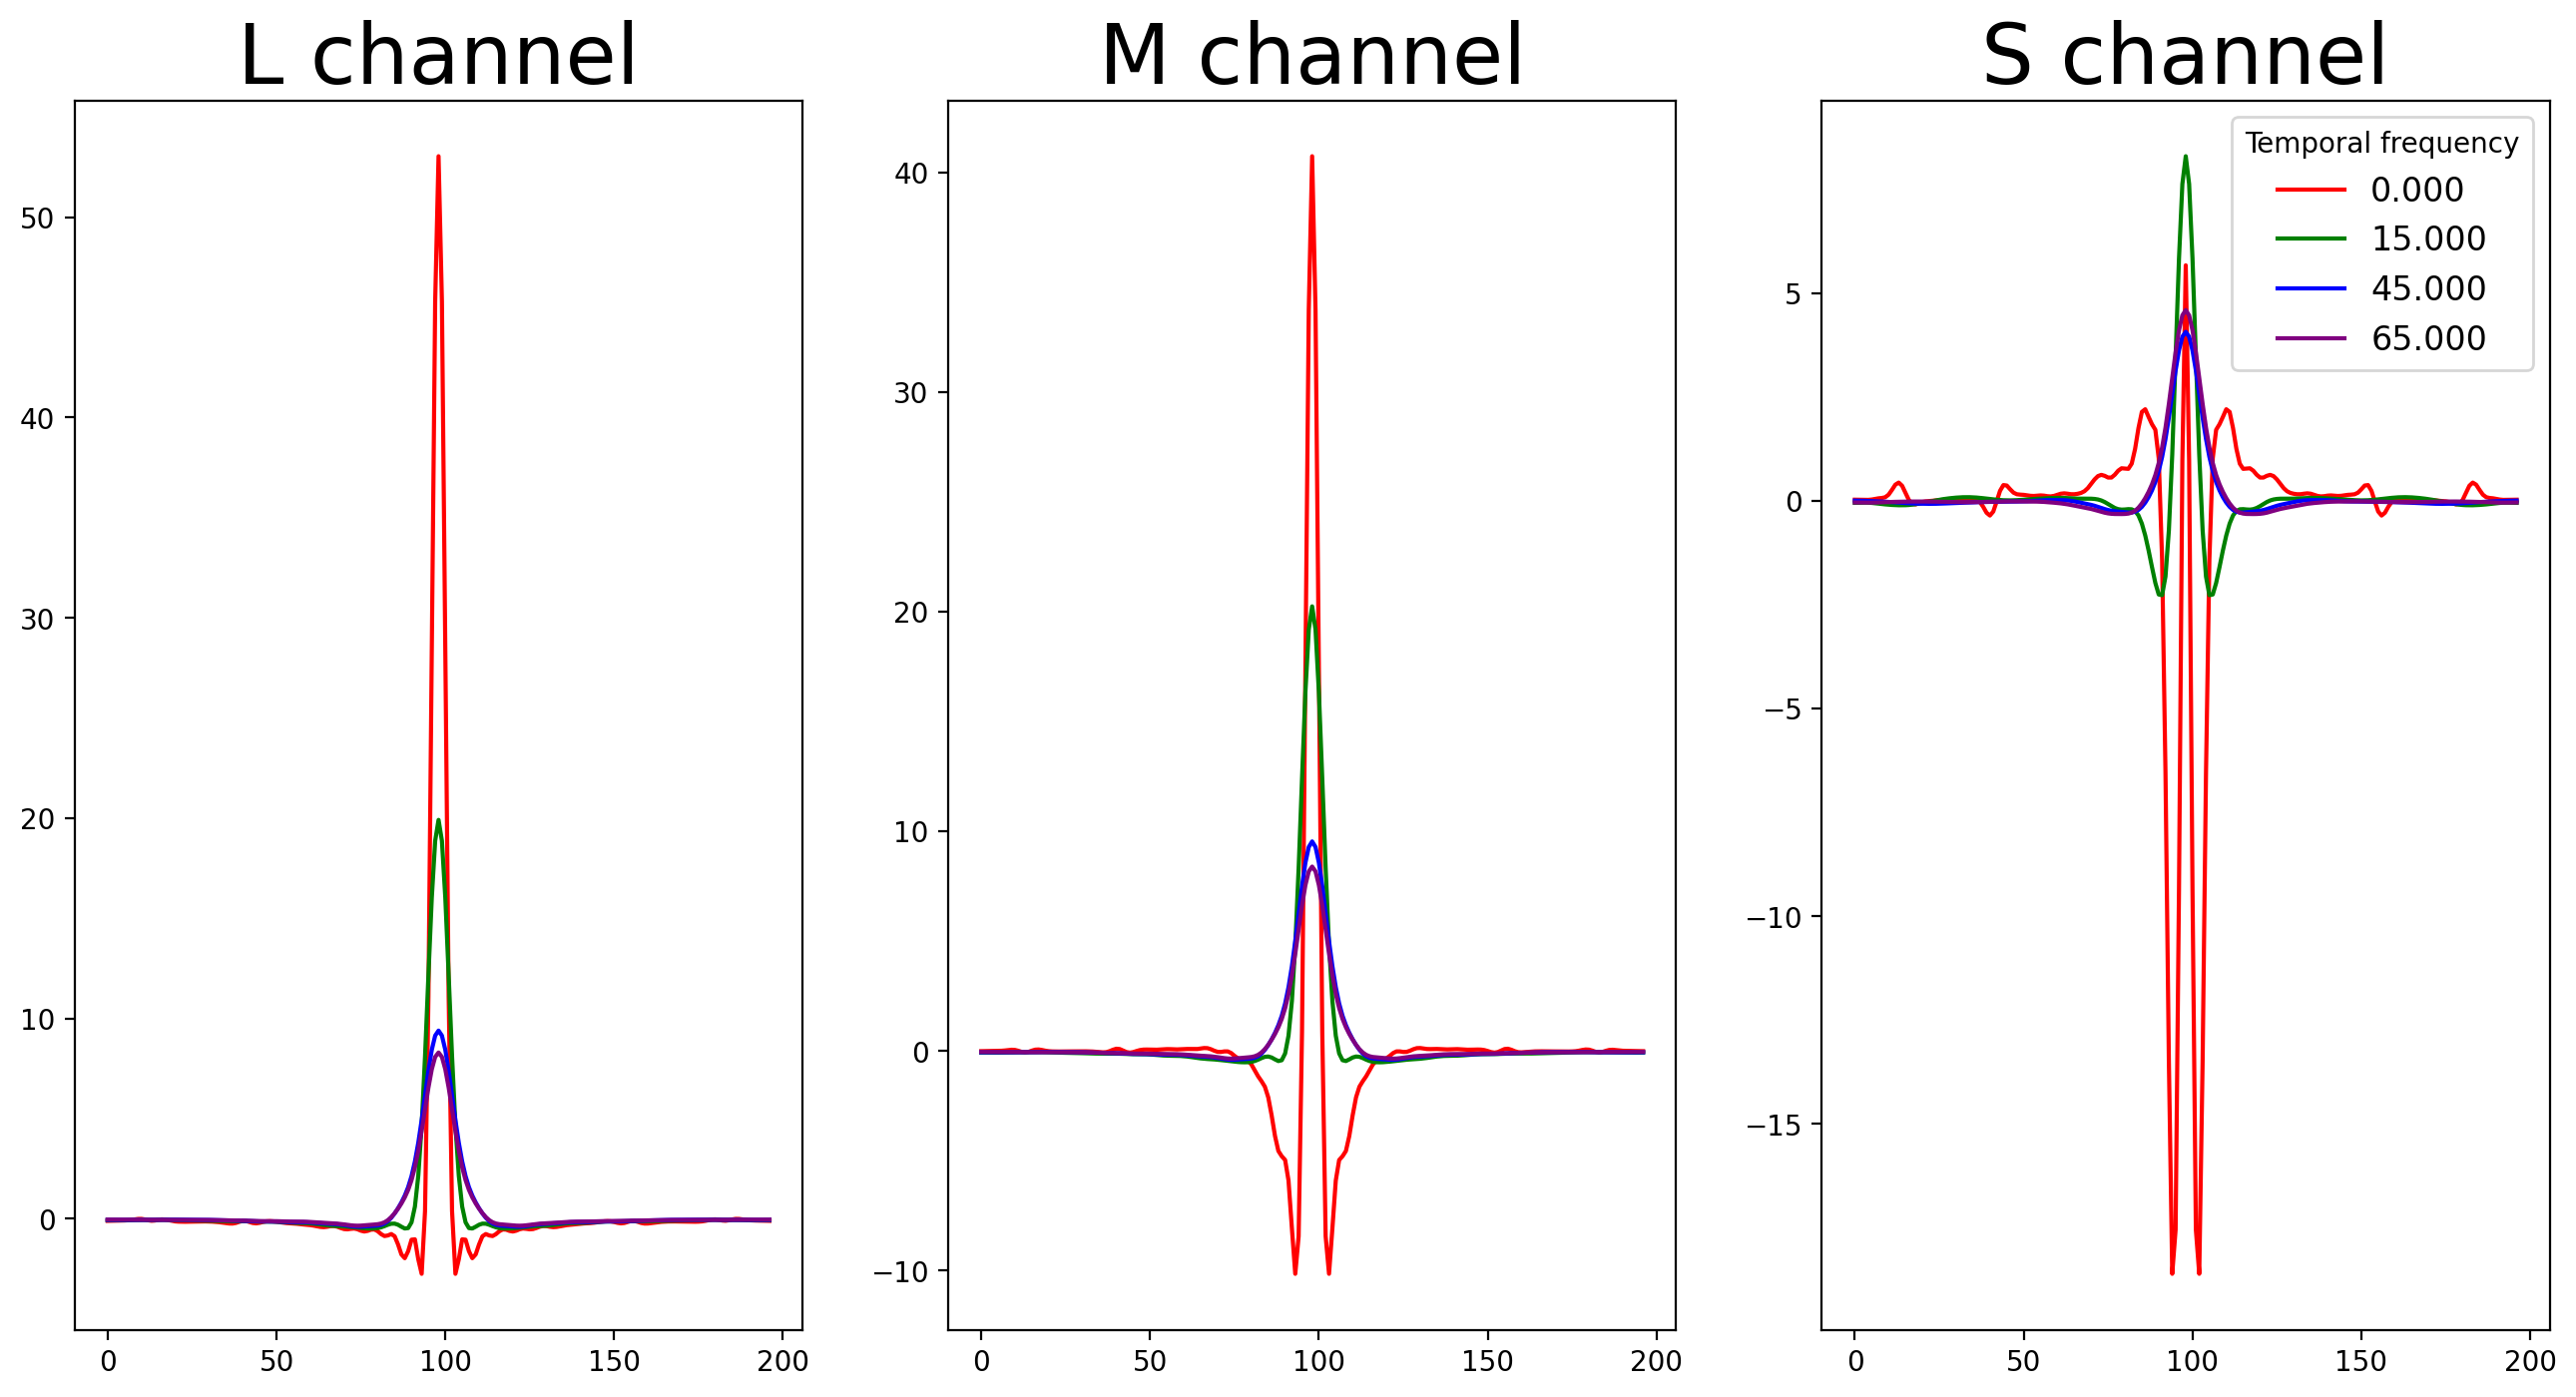

In [121]:
if lms_space:
    v_temp = np.zeros(vv.shape[0])
    for j in range(n_channels):
        v_temp += vv*U[:,fixed_omega,j,i]
    vv = v_temp

fig, ax = plt.subplots(1, 3, figsize=(16, 8))
P = 1
#dz = 1e-4
N = Cx.shape[0]
dz = 1#Cx.shape[0]/N

#In hindsight, these should be indices instead of frequencies!!! *IMPORTANT
#John: dz = 1/n_pixels 
#Lower frequency is 2*pi/L

#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
#freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)

k_min = 0
k_max = 98
k_indices = np.linspace(k_min, k_max -1, k_max - k_min)
#omega_indices = np.array([0,10,20,30])
omega_indices = np.array([0,15,45,65])

#freqs_k = (scipy.fft.fftfreq(N, d=dz) * np.pi)[0:N//2+1

#freqs_k = Cx.shape[0]*freqs_k[0:int(N/2)]/np.max(freqs_k[0:int(N/2)])


#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
L = (len(k_indices)//2) * dz
zz = np.linspace(-L/2, L/2, N)

# make a double exponential smoothing filter
fz = np.arange(-.2,.2, 0.01)
ff = np.exp(-20 * np.abs(fz))
ff /= np.sum(ff)
vv_all = []
vf_all = []
vvf_all = []
vspace_all = []
eig_RFs = []

colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'yellow', 'pink', 'darkred', 'olive']
c = 0
lines = []
channel_labels = ['L+M+S', 'L+M-S', 'L-M']

for fixed_omega in omega_indices:
    log_eps = optimal_logeps(fixed_omega, k_indices, None, P, 'temporal')
    #log_eps = log_eps[::-1]
    print(log_eps)
    vspace_omega = []
    vf_omega = []
    for i in range(n_channels):
        vv = filter_k(fixed_omega, k_indices, 10**log_eps[i], 'temporal', i)(k_indices)
        #vv = vv[:,0]
        #vv = vv[::-1]
        vv_all.append(vv)
        #if np.max(vv) > 0:
        #vf = np.convolve(vv[N//2:], ff, mode='same')
        #Remove negative frequencies from vv
        vv = vv[vv.shape[0]//2:]
        

        vf = np.convolve(vv, ff, mode = 'same')
        vf_omega.append(vf)
        vf_all.append(vf)
        #The bug is here :) in the fft convention~

        vvf = pad_and_reflect(vf, vf.shape[0]*2)
        #vvf = vf
        
        vvf_all.append(vvf)
        vspace = np.real(scipy.fft.fft(vvf))
        vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
        vspace_omega.append(vspace)
    vspace_all.append(vspace_omega)
    eig_RFs.append(vf_omega)
eig_RFs = np.array(eig_RFs) # omegas x colors x space_freqs
lms_RFs = np.zeros(eig_RFs.shape)
omega_index = -1
lms_titles = ["L channel", "M channel", "S channel"]
for omega in omega_indices:
    omega_index += 1
    for eig_c in range(n_channels):
        lms_RFs[omega_index,:,:] += (eig_RFs[omega_index,eig_c,:,np.newaxis]*U[:,omega,:,eig_c]).T
    for color in range(n_channels):
        vvf = pad_and_reflect(lms_RFs[omega_index,color,:], lms_RFs.shape[2]*2)
        vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
        line, = ax[color].plot(vspace, color = colors[omega_index], label = str(('{:.3f}').format(omega)))
        ax[color].set_title(lms_titles[color], size = 30)
    lines.append(line)
ax[2].legend(handles=lines, title = "Temporal frequency", fontsize = 12)

In [108]:
print(lms_RFs.shape)

(4, 3, 98)


In [16]:
def filter(A, sigin, sigout, nu, k_lims=None, o_lims=None):
    def v_opt(k, omega, i):
        sqrt_piece = np.sqrt(1 + (4/nu) * (sigin**2/sigout**2) * k**alpha * omega**2/A[i])
        print(k.shape, omega.shape)
        v2 = 0.5 * (sqrt_piece + 1) * A[i] / (A[i] + sigin**2 * k**alpha * omega**2) - 1
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2/sigin**2)
        
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        if o_lims:
            unit_cell_o = soft_bandpass(o_lims[0], o_lims[1], omega)
            v2 *= unit_cell_o
            
        return v2
    return v_opt

And redefine functions so that the filter can be bandwidth-constrained:

In [166]:
freqs_k = scipy.fft.fftfreq(N, d=dz) * np.pi
freqs_omega = scipy.fft.fftfreq(M, d=dt) * np.pi

freqs_k_small = freqs_k[(freqs_k > 0)]
freqs_omega_small = freqs_omega[(freqs_omega > 0)]

oo, kk = np.meshgrid(freqs_omega_small, freqs_k_small)

In [167]:
nu = 1e-3
vfun = filter(A, sigin, sigout, nu)

/tmp/ipykernel_237771/3363473031.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.contour(np.log(oo), np.log(kk), np.log10(v), levels=11)


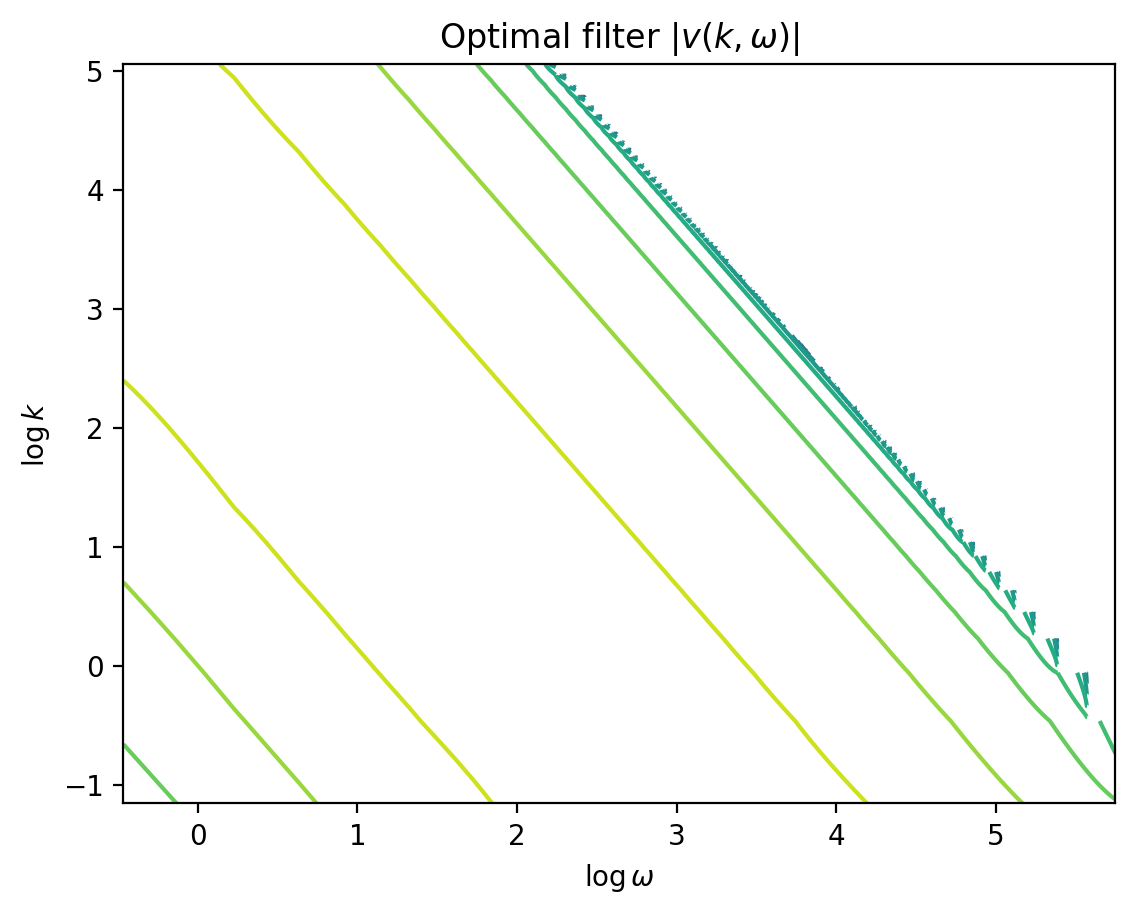

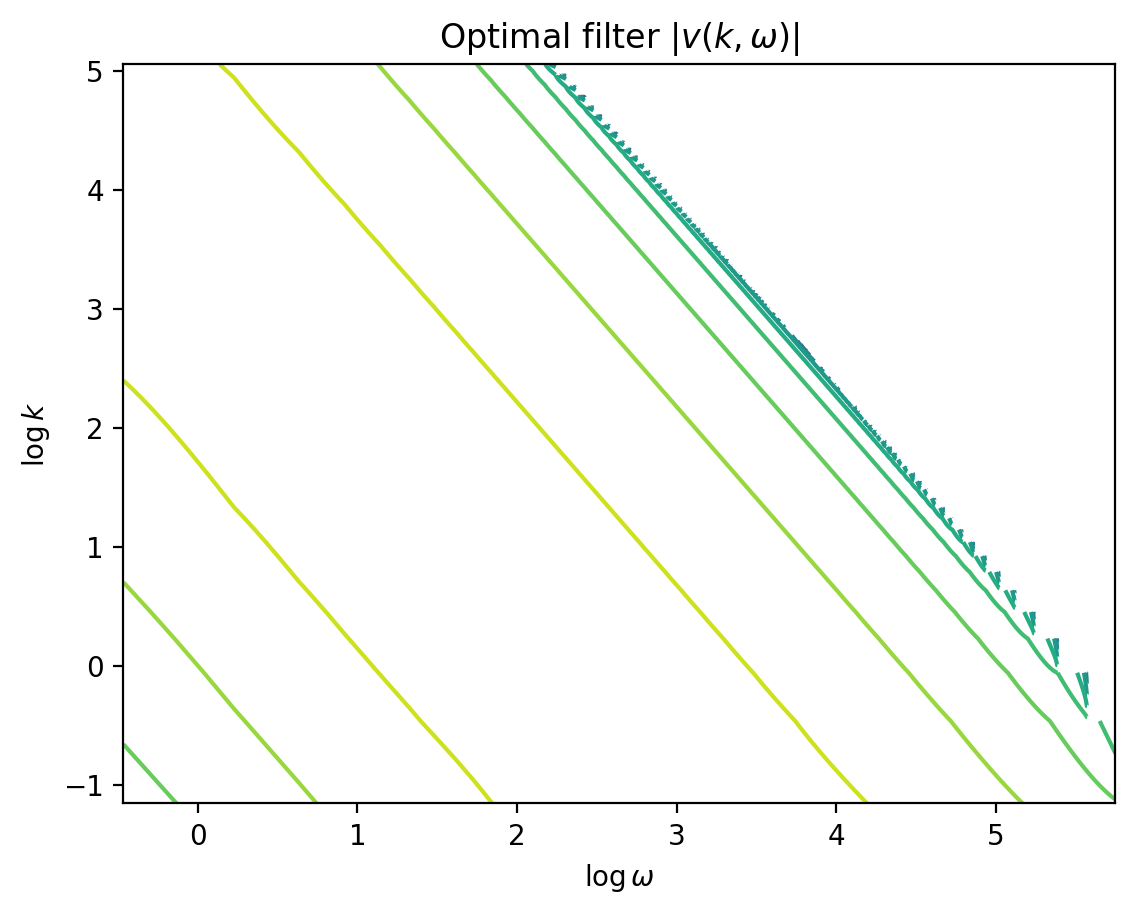

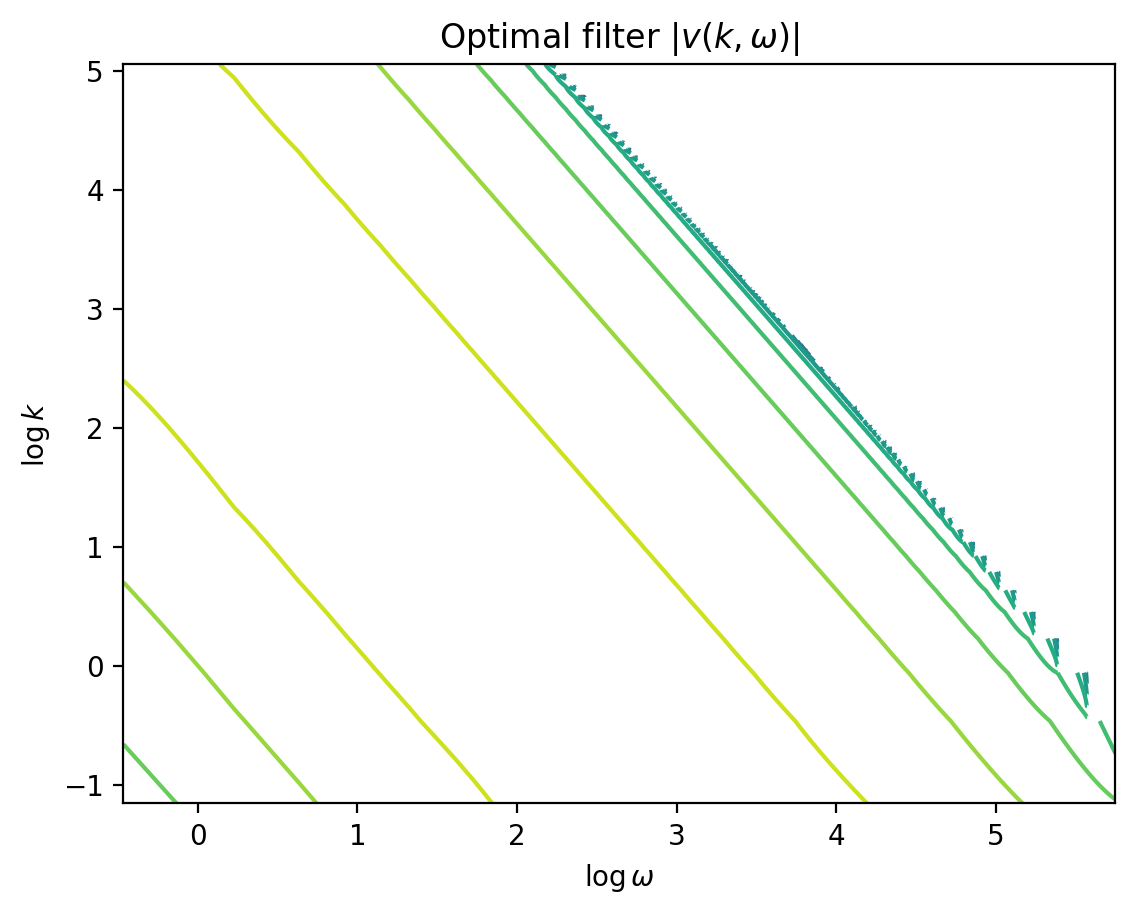

In [168]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
for i in range(A.shape[0]):
    v = vfun(kk, oo, i)
    Ck = C(kk, oo, i)
    plt.figure()
    plt.contour(np.log(oo), np.log(kk), np.log10(v), levels=11)
    plt.title(r"Optimal filter $|v(k, \omega)|$")
    plt.ylabel(r"$\log k$")
    plt.xlabel(r"$\log \omega$");

# Power as a function of $\nu$

In [169]:
def filter_power(nu, omega0, k_lims, i):
    vfun = filter(A, sigin, sigout, nu)
    func = lambda k: k * (vfun(k, omega0,i)**2) * (C(k, omega0, i) + sigin**2)/(2 * np.pi)**2
    return scipy.integrate.quad(func, k_lims[0], k_lims[1])[0]

def filter_power_log_k(nu, omega0, log_k_lims):
    """Integrate power in psi = log k space."""
    vfun = filter(A, sigin, sigout, nu)
    func = lambda psi: np.exp(2 * psi) * vfun(np.exp(psi), omega0**2) * (C(np.exp(psi), omega0) + sigin**2)/(2 * np.pi)**2
    return scipy.integrate.quad(func, log_k_lims[0], log_k_lims[1])[0]

In [170]:
%%time
nu_list = np.logspace(-10, 0, 50) #[1e-6 , 1e-5, 1e-4, 0.005, 0.01, 0.05]

k_lims = (1e-3, 1e3)
omega0 = 10**1.2
pow_list = [filter_power(nu, omega0, k_lims, 0) for nu in nu_list]

CPU times: user 111 ms, sys: 2 ms, total: 113 ms
Wall time: 112 ms


# Bringing it all together

/tmp/ipykernel_237771/3810808532.py:16: RuntimeWarning: divide by zero encountered in log10
  ax[0, 0].plot(np.log10(k_logrange), np.log10(v2), color='k')
/tmp/ipykernel_237771/3810808532.py:27: RuntimeWarning: divide by zero encountered in log10
  ax[0, 0].fill_between(np.log10(k_logrange[right_side]), np.log10(v2[right_side]), -11, color='orange', alpha=0.5, edgecolor='none')
/tmp/ipykernel_237771/3810808532.py:54: RuntimeWarning: divide by zero encountered in log10
  ax[0, 1].plot(np.log10(k_logrange), 10 * np.log10(power), label=np.around(np.log10(log_o), 1), color=cmap[idx])
/tmp/ipykernel_237771/3810808532.py:69: RuntimeWarning: divide by zero encountered in log10
  ax[1, 1].plot(np.log10(pow_list), np.log10(nu_list), color='k')


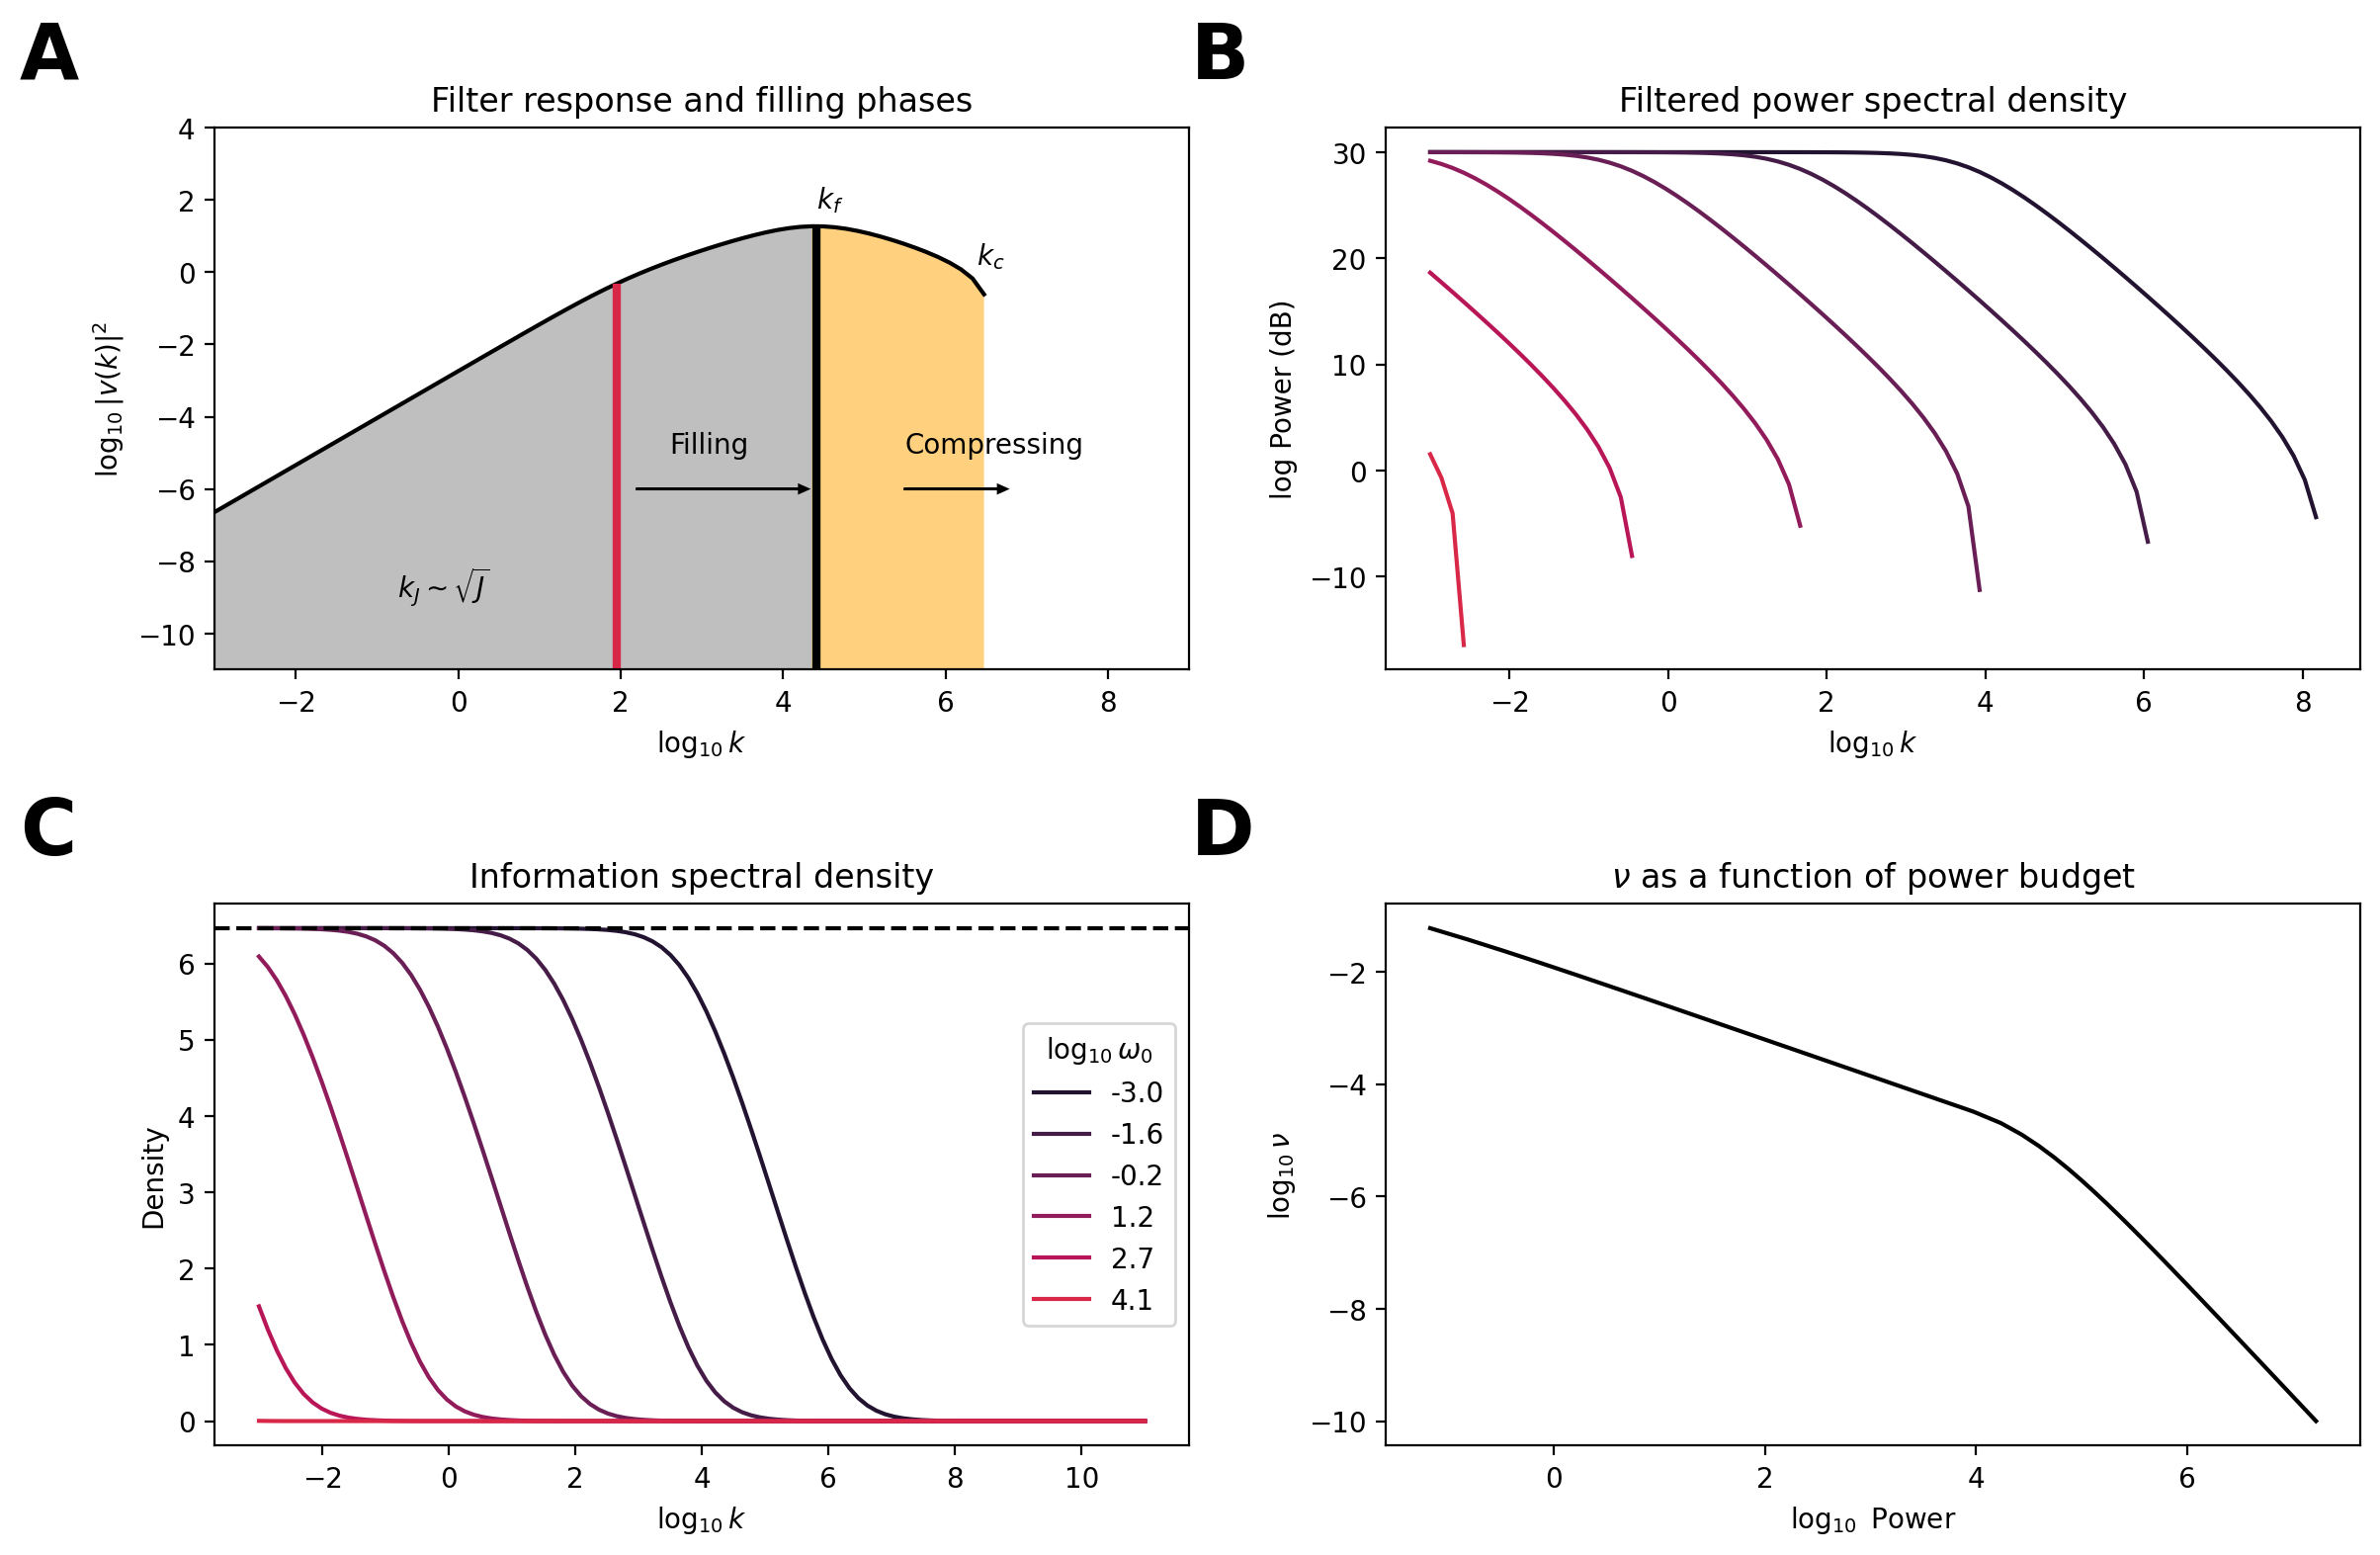

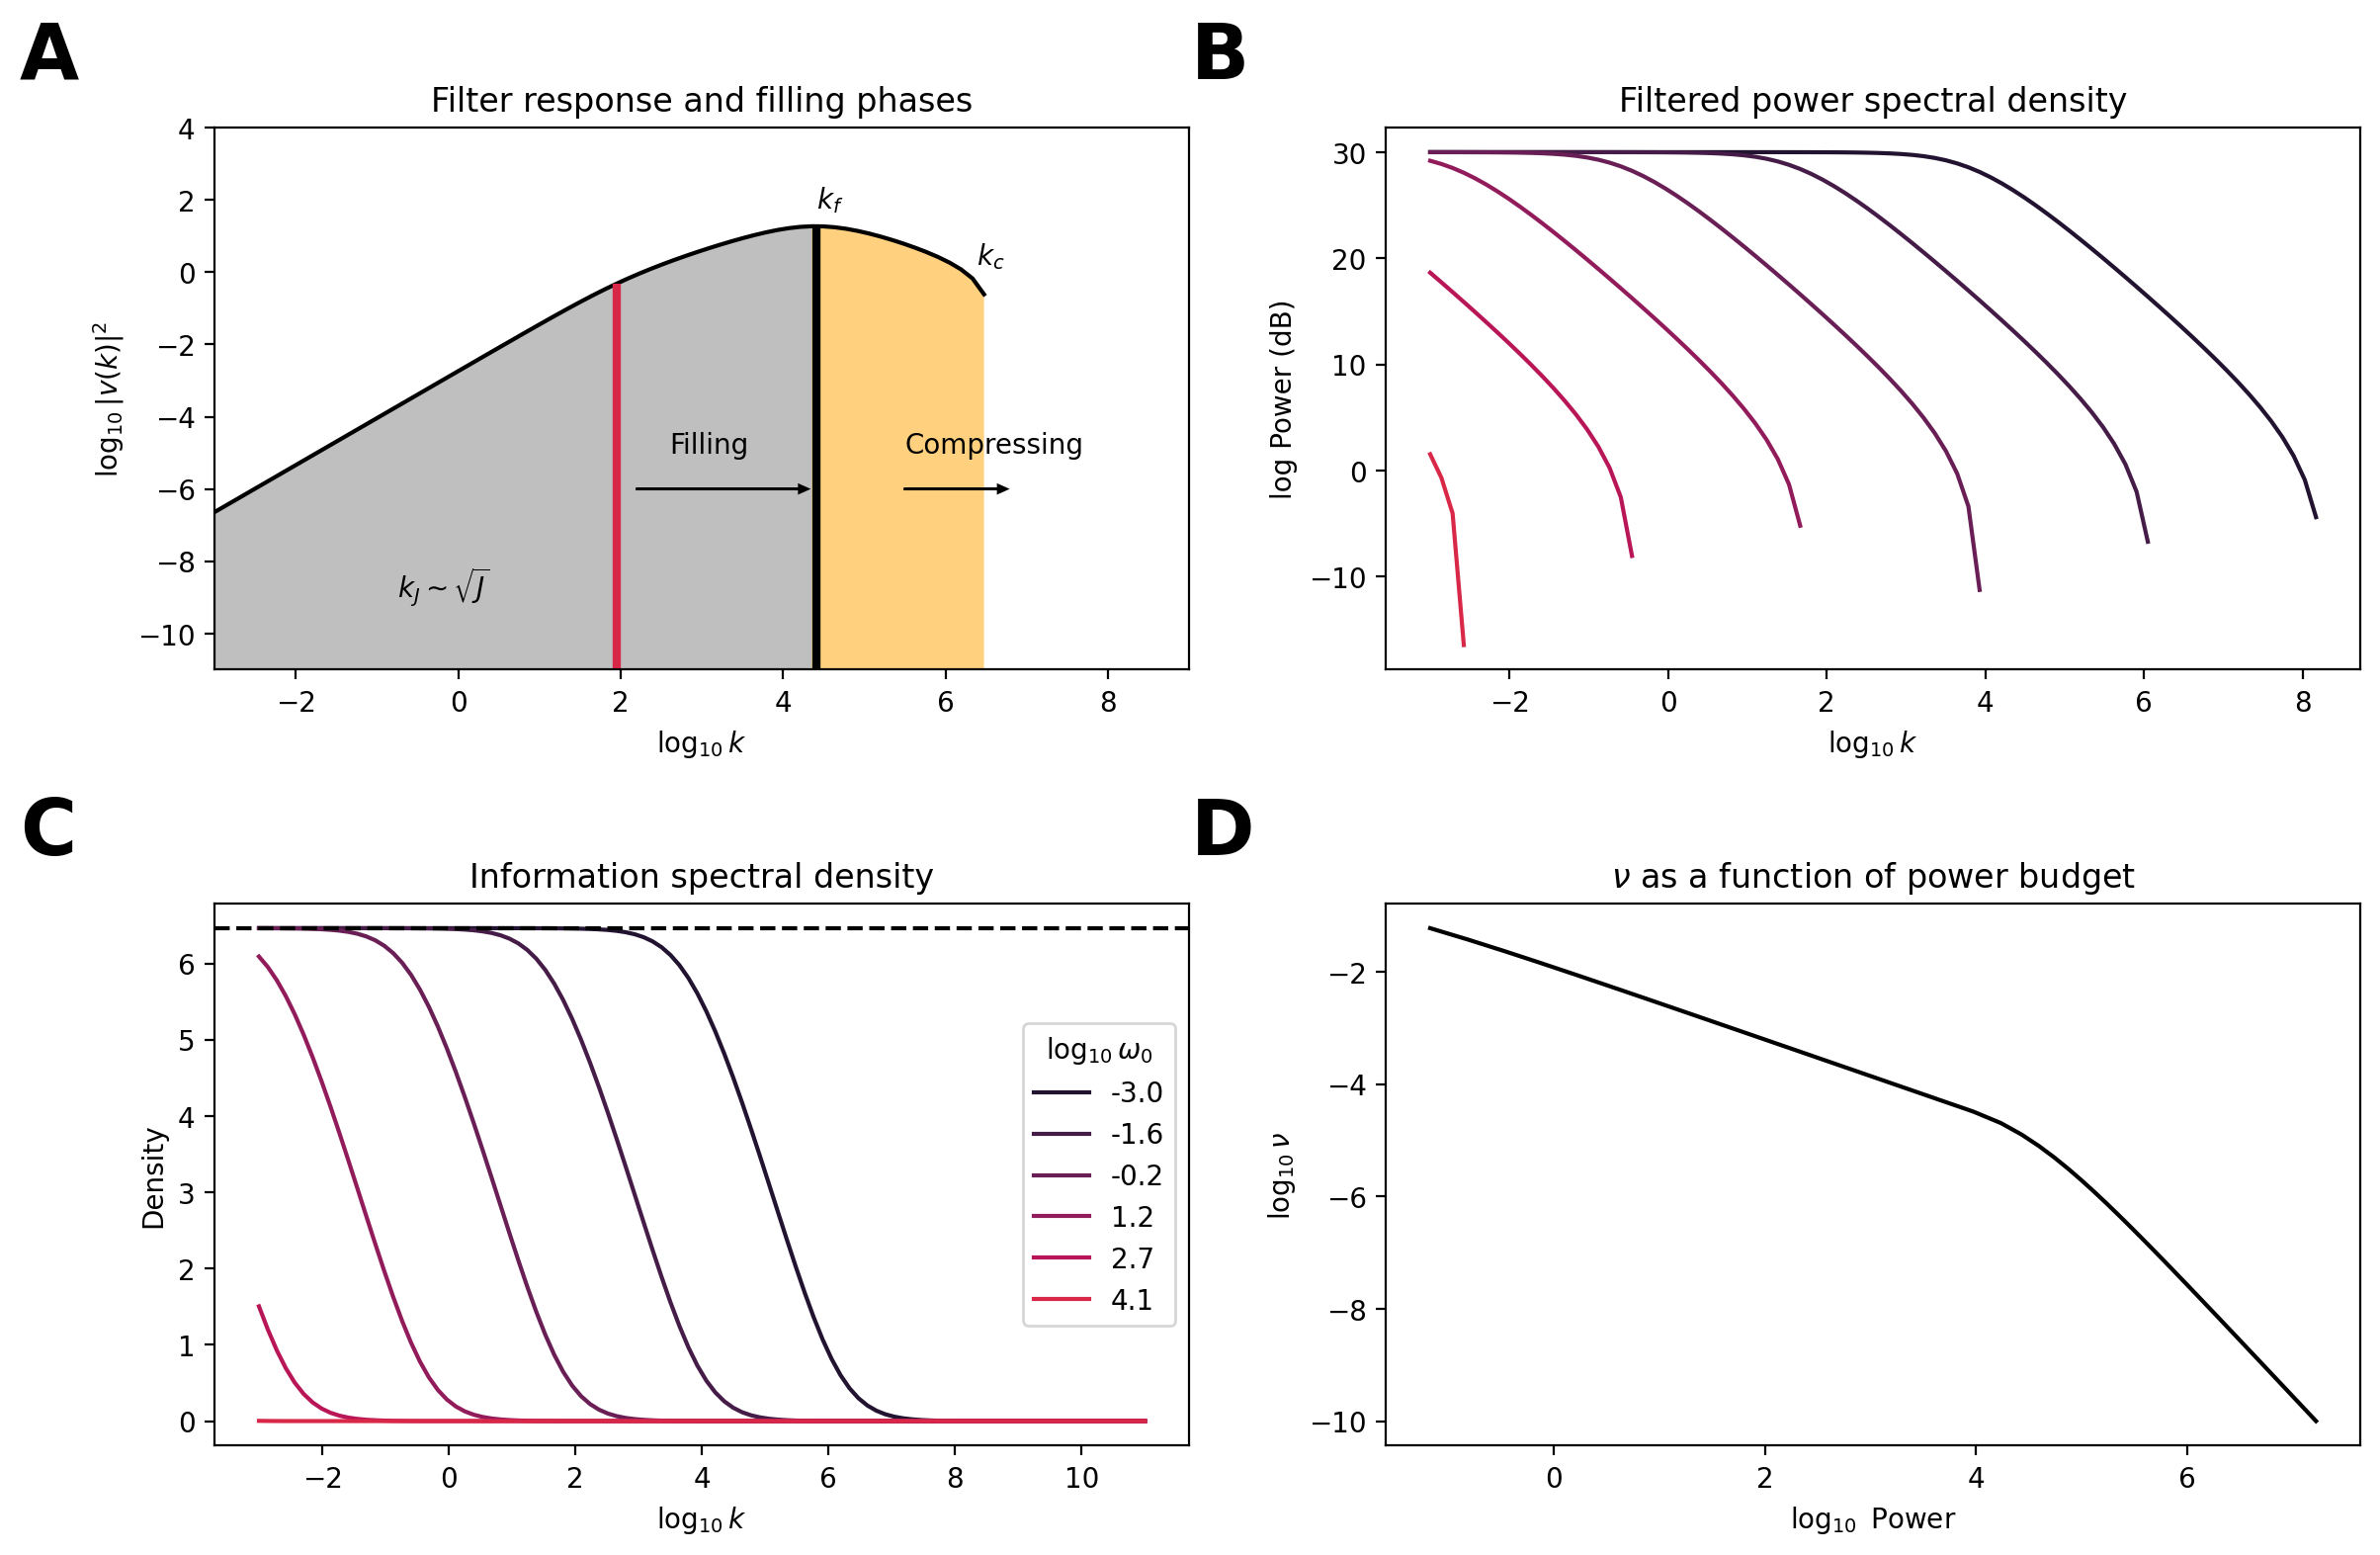

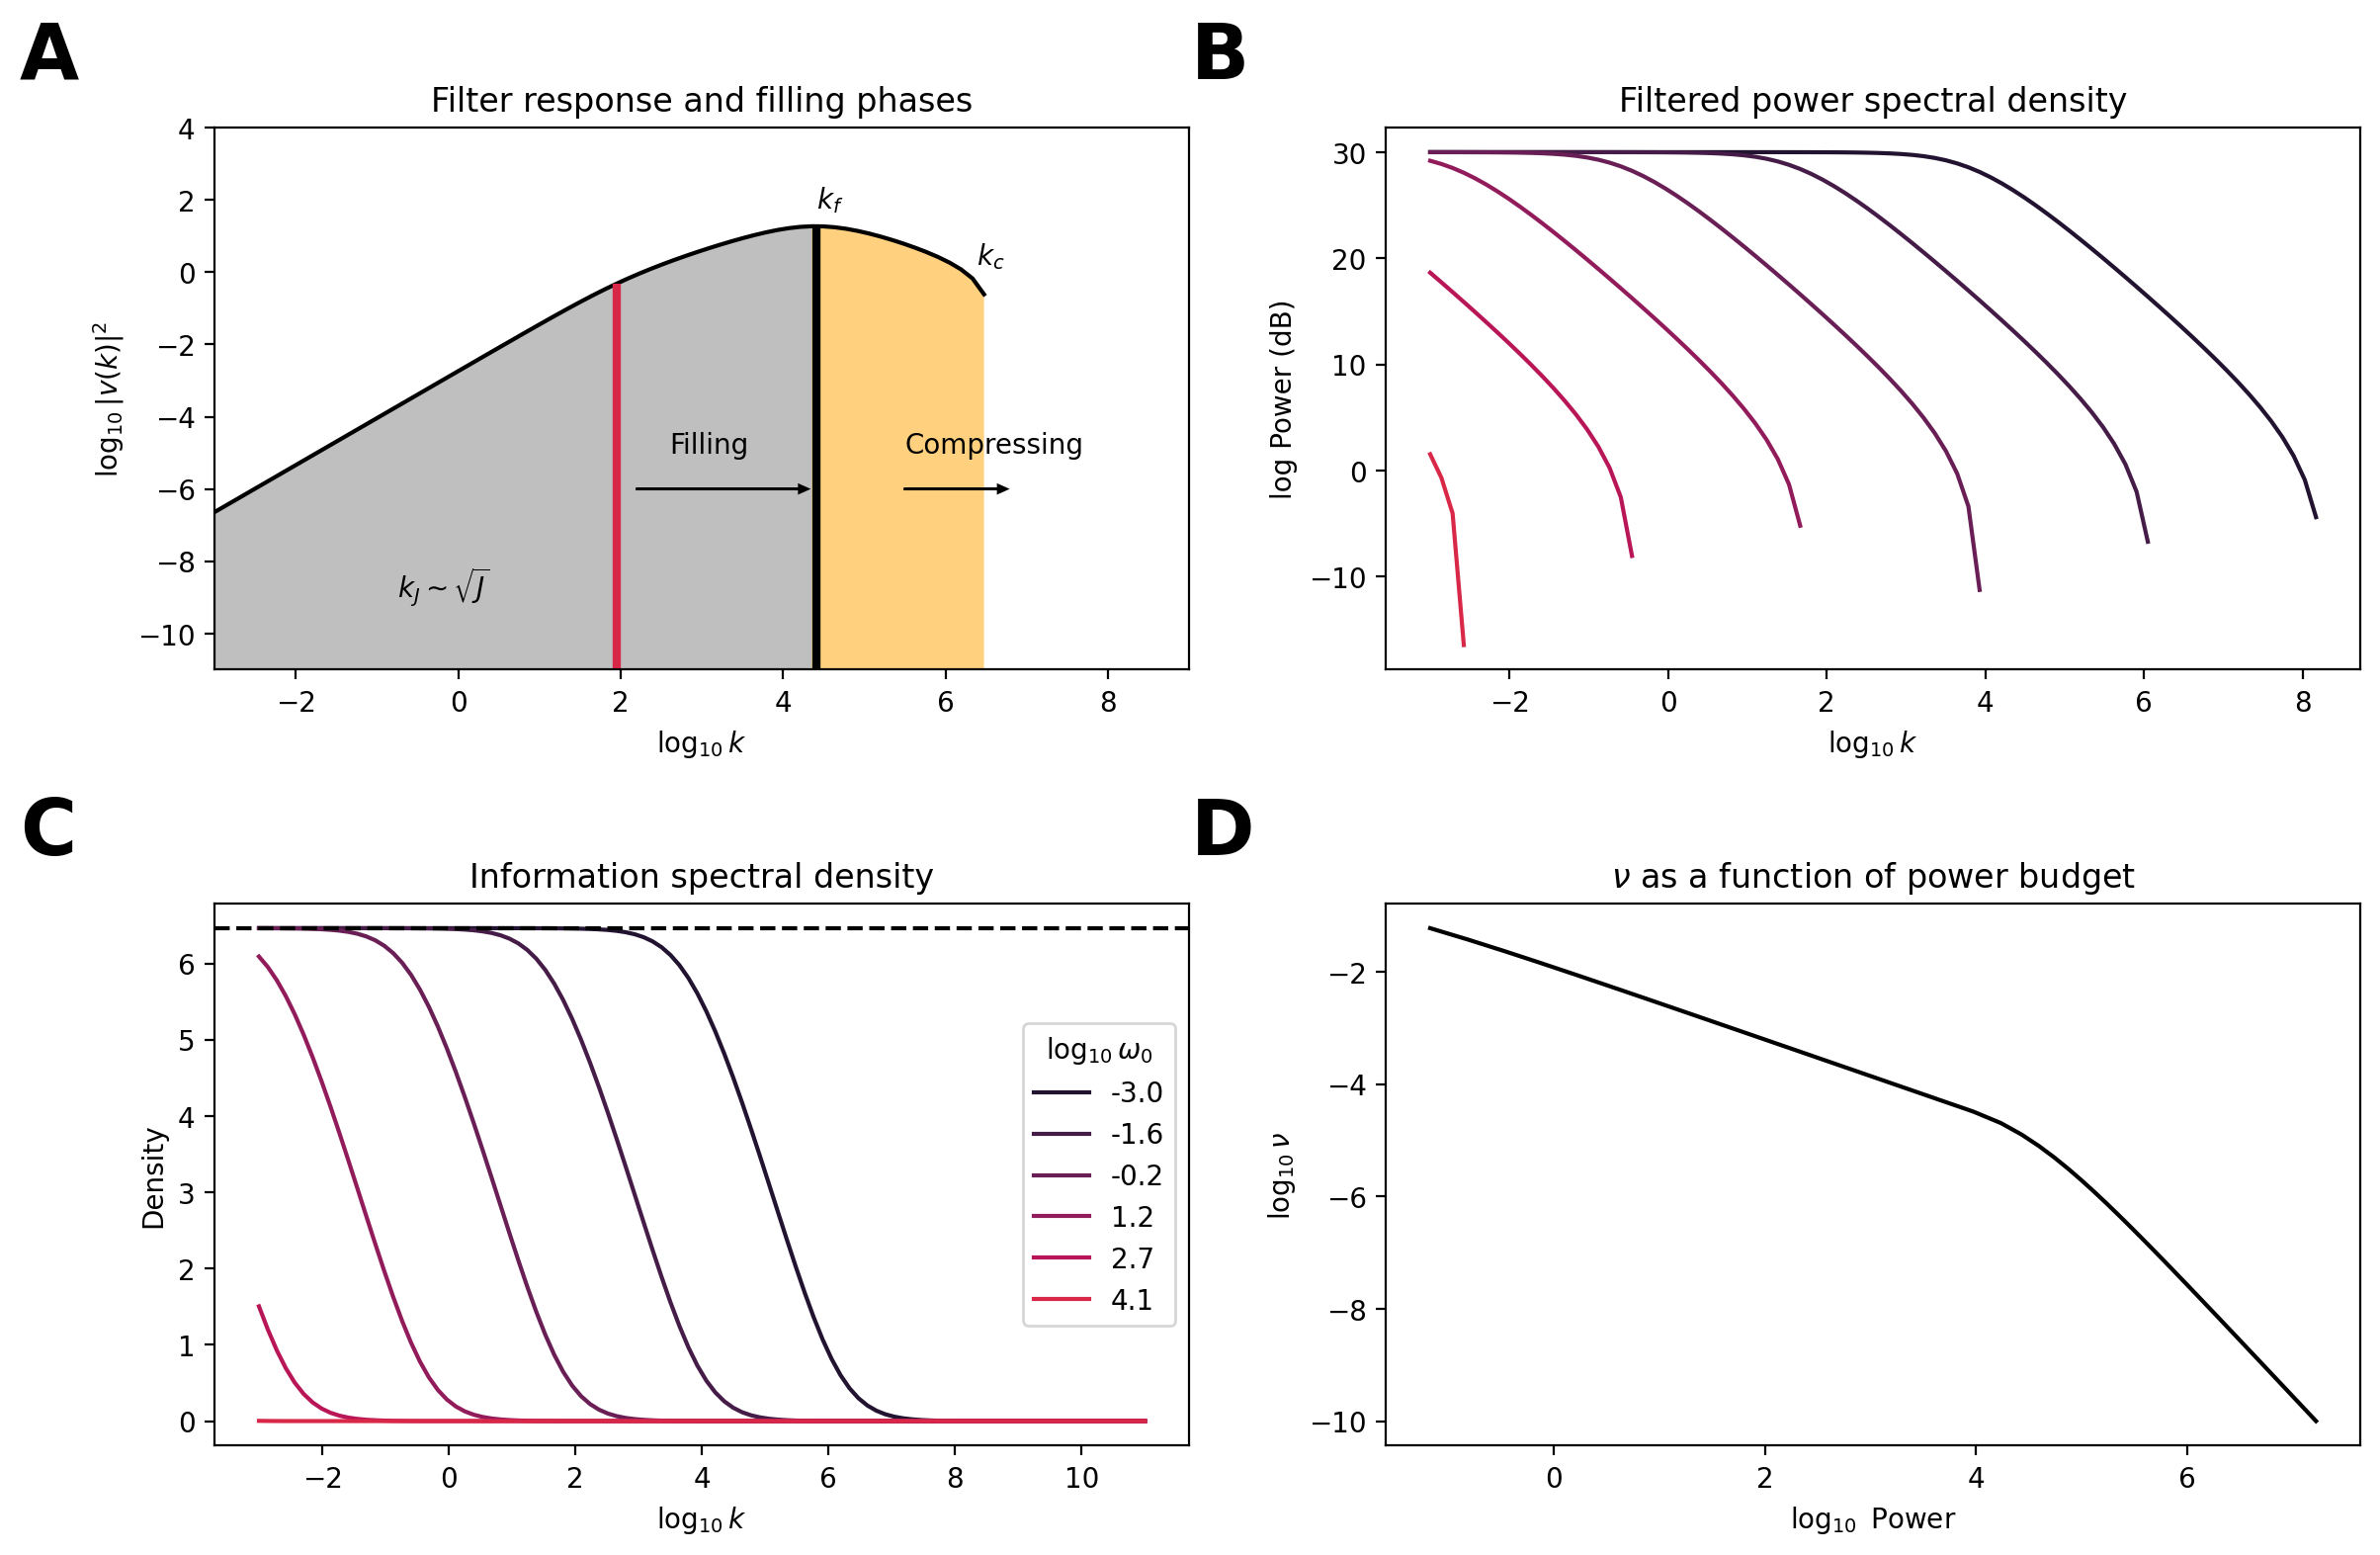

In [171]:

for i in range(A.shape[0]):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    cmap = sns.color_palette('rocket', 10)
    label_loc = (-0.2, 1.2)
    fontsize=28
    fontweight='heavy'
    
    k_logrange = np.logspace(-3, 11, 100)
    o_logrange = np.logspace(-3, 11, 100)
    
    idx = 8



    v2 = vfun(k_logrange, o_logrange[idx], i)**2
    ax[0, 0].plot(np.log10(k_logrange), np.log10(v2), color='k')
    log_kp = (np.log10(A[i]) - 2 * np.log10(sigin) - 2 * np.log10(o_logrange[idx]))/alpha
    log_v2_kp = 2 * np.log10(vfun(10**log_kp, o_logrange[idx], i))
    log_kc = log_kp - (np.log10(nu) + 2 * np.log(sigout))/alpha
    log_v2_kc = 2 * np.log10(vfun(10**log_kc, o_logrange[idx], i))
    
    ax[0, 0].vlines(log_kp, -11, log_v2_kp, color='k', linewidth=3)
    nearest_idx = np.argmin(np.abs(k_logrange - 10**log_kp))
    left_side = slice(0, nearest_idx + 1) #k_logrange[:nearest_idx] <= 10**log_kp
    right_side = slice(nearest_idx, -1) #k_logrange[nearest_idx:] >= 10**log_kp
    ax[0, 0].fill_between(np.log10(k_logrange[left_side]), np.log10(v2[left_side]), -11, color='gray', alpha=0.5, edgecolor='none')
    ax[0, 0].fill_between(np.log10(k_logrange[right_side]), np.log10(v2[right_side]), -11, color='orange', alpha=0.5, edgecolor='none')
    ax[0, 0].set_xlim(-3, 9)
    ax[0, 0].set_ylim(-11, 4)
    ax[0, 0].annotate(r"Filling", (2.6, -5))
    ax[0, 0].arrow(2.2, -6, 2, 0, head_width=0.2, head_length=0.1, color='k')
    lower_idx, upper_idx = 35, 70
    linecolor = cmap[5] #(227/255, 74/255, 51/255)
    ax[0, 0].vlines(np.log10(k_logrange[lower_idx]), -11, np.log10(v2[lower_idx]), color=linecolor, linewidth=3, zorder=2)
    # ax[0, 0].vlines(np.log10(k_logrange[upper_idx]), -3.55, np.log10(v2[upper_idx]), color=linecolor, linewidth=3, zorder=1)
    # ax[0, 0].vlines(np.log10(k_logrange[upper_idx]), -11, -5.8, color=linecolor, linewidth=3, zorder=1)
    ax[0, 0].annotate(r"$k_J \sim \sqrt{J}$", (np.log10(k_logrange[lower_idx]) - 2.7, -9))
    ax[0, 0].annotate(r"Compressing", (5.5, -5))
    # ax[0, 0].annotate(r"$\frac{\pi}{\Delta z(J)}$", (np.log10(k_logrange[upper_idx]) + .5, -9))
    ax[0, 0].arrow(5.5, -6, 1.15, 0, head_width=0.2, head_length=0.1, color='k')
    ax[0, 0].annotate(r"$k_f$", (log_kp, log_v2_kp + 0.5))
    ax[0, 0].annotate(r"$k_c$", (log_kc, log_v2_kc + 0.5))
    ax[0, 0].set_title(r"Filter response and filling phases")
    ax[0, 0].set_xlabel(r"$\log_{10} k$")
    ax[0, 0].set_ylabel(r"$\log_{10} |v(k)|^2$");
    ax[0, 0].text(*label_loc, "A", transform=ax[0, 0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
    
    for idx, log_o in enumerate(o_logrange[:60:10]):
        numer = vfun(k_logrange, log_o, i)**2 * (C(k_logrange, log_o, i) + sigin**2) + sigout**2
        denom = vfun(k_logrange, log_o, i)**2 * (sigin**2) + sigout**2
        power = vfun(k_logrange, log_o, i)**2 * (C(k_logrange, log_o, i) + sigin**2)
        v2 = vfun(k_logrange, log_o, i)**2
        ax[0, 1].plot(np.log10(k_logrange), 10 * np.log10(power), label=np.around(np.log10(log_o), 1), color=cmap[idx])
        ax[1, 0].plot(np.log10(k_logrange), np.log(numer) - np.log(denom), label=np.around(np.log10(log_o), 1), color=cmap[idx])
    
    ax[0, 1].set_xlabel(r"$\log_{10} k$")
    ax[0, 1].set_ylabel(r"log Power (dB)");
    ax[0, 1].set_title(r"Filtered power spectral density");
    ax[0, 1].text(*label_loc, "B", transform=ax[0, 1].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
    ax[1, 0].axhline(-np.log(nu) - np.log(sigout**2), color='k', linestyle='--')
    ax[1, 0].set_xlabel(r"$\log_{10} k$")
    ax[1, 0].set_ylabel(r"Density")
    ax[1, 0].set_title(r"Information spectral density")
    ax[1, 0].legend(title=r"$\log_{10} \omega_0$")
    ax[1, 0].text(*label_loc, "C", transform=ax[1, 0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
    ax[1, 1].plot(np.log10(pow_list), np.log10(nu_list), color='k')
    ax[1, 1].set_xlabel(r"$\log_{10}$ Power")
    ax[1, 1].set_ylabel(r"$\log_{10} \nu$")
    ax[1, 1].set_title(r"$\nu$ as a function of power budget")
    ax[1, 1].text(*label_loc, "D", transform=ax[1, 1].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
    
    plt.tight_layout()
#plt.savefig("figures/k_scaling.pdf")

# Optimal $\nu$ and information as a function of $\omega$:

In [172]:
omega0 = 10**1.2
k = (2 * np.pi/L) * np.array([[0, 0], [1, 0], [1, 0]])
nu = 1e-4

def make_k(J):
    """k is J x 2, with J the number of neurons/frequencies"""
    M = int(np.sqrt(J))  # find biggest square array that fits inside
    m1, m2 = np.meshgrid(range(M), range(M))
    mm = np.stack([m1.ravel(), m2.ravel()], axis=1)
    return (2 * np.pi/L) * mm

def filter_power_discrete(nu, omega0, J, i):
    k = make_k(J)
    #print(np.linalg.norm(k,axis=1), "that's what I think is wrong")
    ktilde = np.linalg.norm(k, axis=1)**alpha * sigin**2 * omega0**2/A[i]
    #print(ktilde, "ktilde", omega0, A, np.linalg.norm(k,axis=1))
    Invalid_value = 1+4*ktilde/(nu + sigout**2)
    if np.min(Invalid_value) < 0:
        print("Invalid value", Invalid_value, "nu", nu)
    Pj = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-16)) * (np.sqrt(1 + 4 * ktilde/(nu * sigout**2)) - 1) - sigout**2)
    return np.sum(Pj)

In [173]:
#I want filter_power_discrete to take 1 nu, but lognu to be an array for scipy.minimize. 
def excess_power(lognus, omega0, J, P):
    power_sum = []
    i = 0
    for lognu in lognus:
        #filter_power = filter_power_discrete(np.exp(lognu), omega0, J)
        #print(filter_power, "filter_power", J, P)
        power =  np.max([filter_power_discrete(np.exp(lognu), omega0, J, i), 1e-32])
        power_sum.append(power)
        i += 1
    power_constraint = np.log(P/np.sum(power_sum))
    #print(power_constraint)
    return power_constraint

def optimal_lognu(omega0, J, P):
    power_constraint = {'type': 'ineq', 'fun': excess_power, 'args': (omega0, J, P)}
    nu_fun = create_information_nu(omega0,J,P)
    
    res = opt.minimize(nu_fun, np.array([-np.log(omega0), -np.log(omega0), -np.log(omega0)]), #bounds=[(1e-16, np.inf)], 
                       constraints=[power_constraint])
    #Original version that only minimizes lognu
    #res = opt.minimize(lambda lognu: lognu, -np.log(omega0), #bounds=[(1e-16, np.inf)], 
    #                   constraints=[power_constraint])
    if res.success:
        #print("Optimal log nu", res.x)
        print("Excess power: ", excess_power(res.x, omega0, J, P))
        return res.x
    else:
        print("Optimizer failed to converge!")
        print(omega0, J, P)
        return None

#Function created by David. Returns information as a function of nu. Will be used in optimal_lognu
def create_information_nu(omega0,J,P):
    def information_nu(log_nu):
        k_local = make_k(J)
        infos = []
        for i in range(A.shape[0]):
            nu_eigenchannel = np.exp(log_nu[i])
            ktilde = np.linalg.norm(k_local, axis=1)**alpha * sigin**2 * omega0**2/A[i]
            #nu_j = np.repeat(nu[np.newaxis], ktilde.shape[0], axis = 0)
            #print(ktilde.shape, nu.shape)
            numer = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-32)) * (np.sqrt(1 + 4 * ktilde/(nu_eigenchannel * sigout**2)) - 1) - sigout**2) + sigout**2
            denom = np.maximum(0, sigout**2 /(2 * (ktilde + 1)) * (np.sqrt(1 + 4 * ktilde/(nu_eigenchannel * sigout**2)) + 1) - sigout**2) + sigout**2
            info = np.sum(np.log(numer) - np.log(denom))
            infos.append(info)
        #print("read here", numer, denom, info)
        return np.sum(infos)*-1
    return information_nu

def plot_information_nu(omega0, J, P):
    log_nus = np.linspace(-5, 1, 200)
    infos = []
    powers = []
    for log_nu in log_nus:
        nu_fun = create_information_nu(omega0,J,P)
        info = nu_fun(log_nu)
        power = np.log(filter_power_discrete(np.exp(log_nu), omega0, J))
        #power = excess_power(np.array([log_nu]), omega0, J, P)
        infos.append(info)
        powers.append(power)
    plt.plot(log_nus, infos)
    plt.xlabel("Log(nu)", size = 40)
    plt.ylabel("Information (nats)")

    plt.figure()
    plt.plot(log_nus, powers)
    plt.xlabel("Log(nu)", size = 40)
    plt.ylabel("Power")
    
def information(omega0, J, P):
    log_nu = optimal_lognu(omega0, J, P)
    nu = np.exp(log_nu)
    
    k = make_k(J)
    infos = []
    for i in range(A.shape[0]):
        ktilde = np.linalg.norm(k, axis=1)**alpha * sigin**2 * omega0**2/A[i]
        
        numer = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-16)) * (np.sqrt(1 + 4 * ktilde/(nu[i] * sigout**2)) - 1) - sigout**2) + sigout**2
        
        denom = np.maximum(0, sigout**2 /(2 * (ktilde + 1)) * (np.sqrt(1 + 4 * ktilde/(nu[i] * sigout**2)) + 1) - sigout**2) + sigout**2
        info = np.sum(np.log(numer) - np.log(denom))
        infos.append(info)
    return np.sum(infos)

In [174]:
#plot_information_nu(omega0,4,6)

## How do we allocate new neurons across mosaics?

Excess power:  1.7035928223518065e-11
Excess power:  2.315671304156048e-07
Excess power:  5.419018565741544e-10
Excess power:  3.506265878008155e-07
Excess power:  5.3715347392911965e-08
Excess power:  2.588218528354148e-11
Excess power:  4.227080907002991e-08
Excess power:  -9.416840765664552e-07
Excess power:  7.00146607333e-11
Excess power:  5.332845276470257e-12
Excess power:  -3.542366400273736e-11
Excess power:  2.9045776852593197e-09
Excess power:  8.058202990519186e-10
Excess power:  -3.8267500280419487e-11
Excess power:  -1.4386503100962807e-10
Excess power:  2.102813478678088e-10
Excess power:  -5.850897544406233e-11
Excess power:  1.7869350442192222e-10
Excess power:  3.1548097467698684e-12
Excess power:  3.3619773631133845e-11
Excess power:  4.920461937491807e-07
Excess power:  6.285018929974709e-09
Excess power:  9.277023593763505e-13
Excess power:  4.3672960792395034e-07
Excess power:  1.7045481838768894e-07
Excess power:  1.609445909865153e-11
Excess power:  4.1581388800

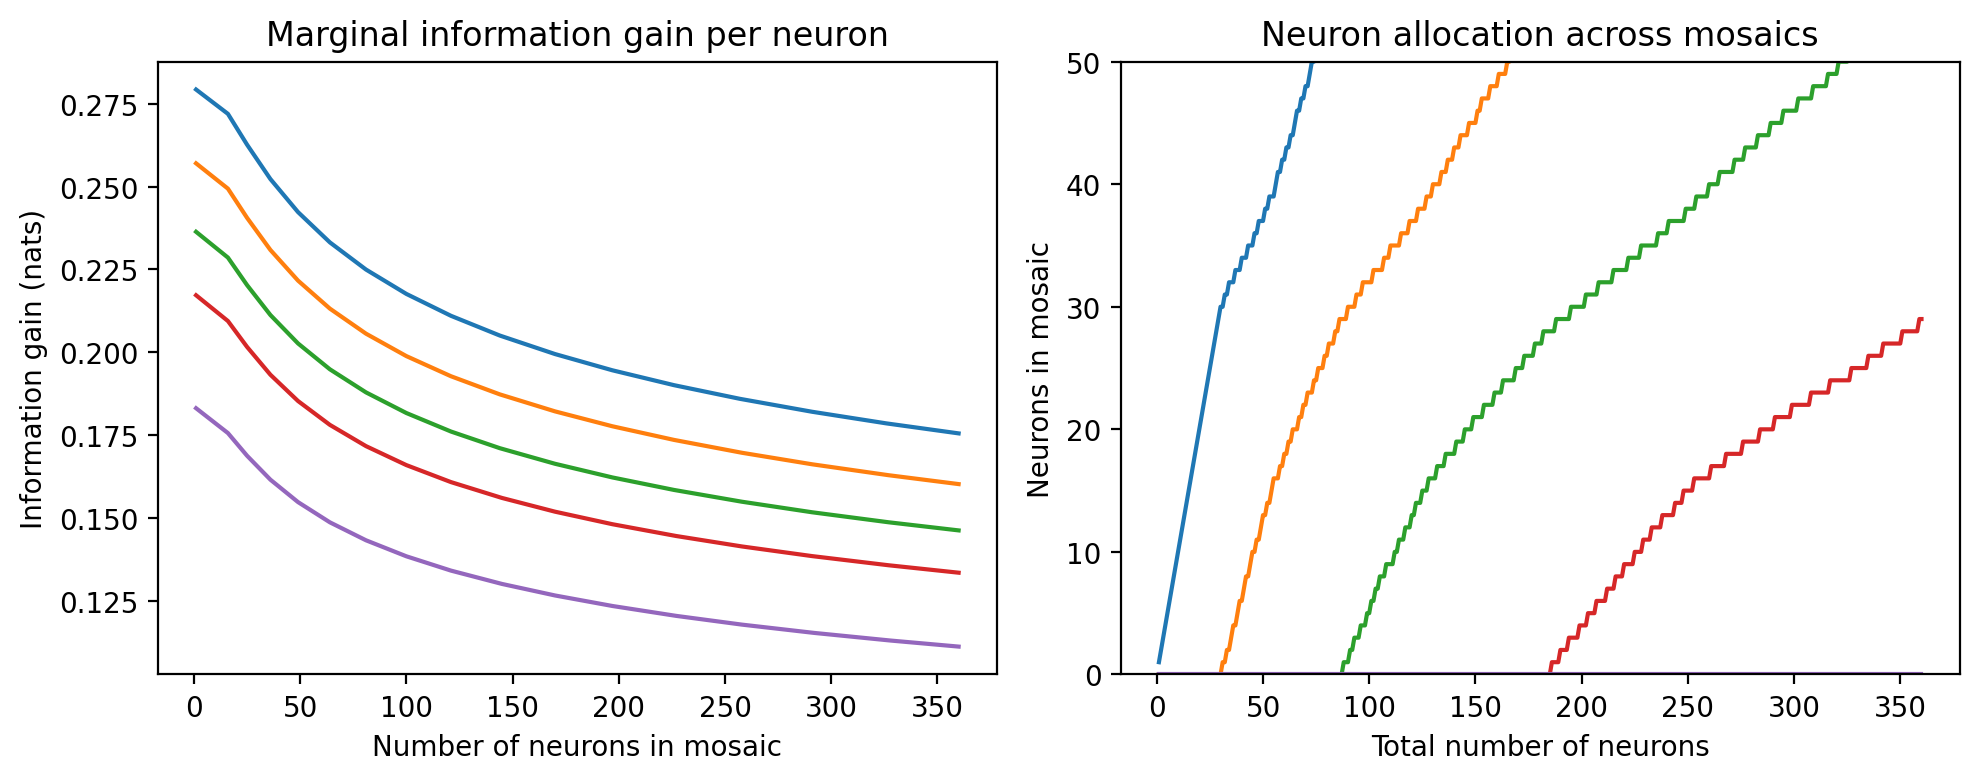

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4)) 

omega0_list = [10**x for x in [1.5, 1.52, 1.54, 1.56, 1.6]]
P0 = 1.5
J_list = [m**2 for m in range(2, 20)]
all_J_list = range(1, J_list[-1])

diff_info_fn_list = []
for omega0 in omega0_list:
    info = [information(omega0, J, J * P0) for J in J_list]
    
    # now interpolate for non-square J
    all_diff_info = interp1d(J_list[1:], np.diff(info), fill_value='extrapolate')
    diff_info_fn_list.append(all_diff_info)
    ax[0].plot(all_J_list, all_diff_info(all_J_list))

ax[0].set_title("Marginal information gain per neuron")
ax[0].set_xlabel("Number of neurons in mosaic")
ax[0].set_ylabel("Information gain (nats)")
    
marginal_allocation = np.zeros((len(all_J_list), len(omega0_list)))
for idx, J in enumerate(all_J_list):
    current_allocation = np.cumsum(marginal_allocation, axis=0)[idx]
    marginal_values = np.array([fun(A + 1) for A, fun in zip(current_allocation, diff_info_fn_list)])
    marginal_allocation[idx, np.argmax(marginal_values)] = 1
    
ax[1].plot(all_J_list, np.cumsum(marginal_allocation, axis=0))
ax[1].set_ylim(0, 50)
ax[1].set_title("Neuron allocation across mosaics")
ax[1].set_xlabel("Total number of neurons")
ax[1].set_ylabel("Neurons in mosaic")

plt.tight_layout()
#plt.savefig("figures/mosaic_allocation.pdf")

# Redefine some things to work in the continuous case

We'll define the filter using some different conventions more applicable in the continuous case.

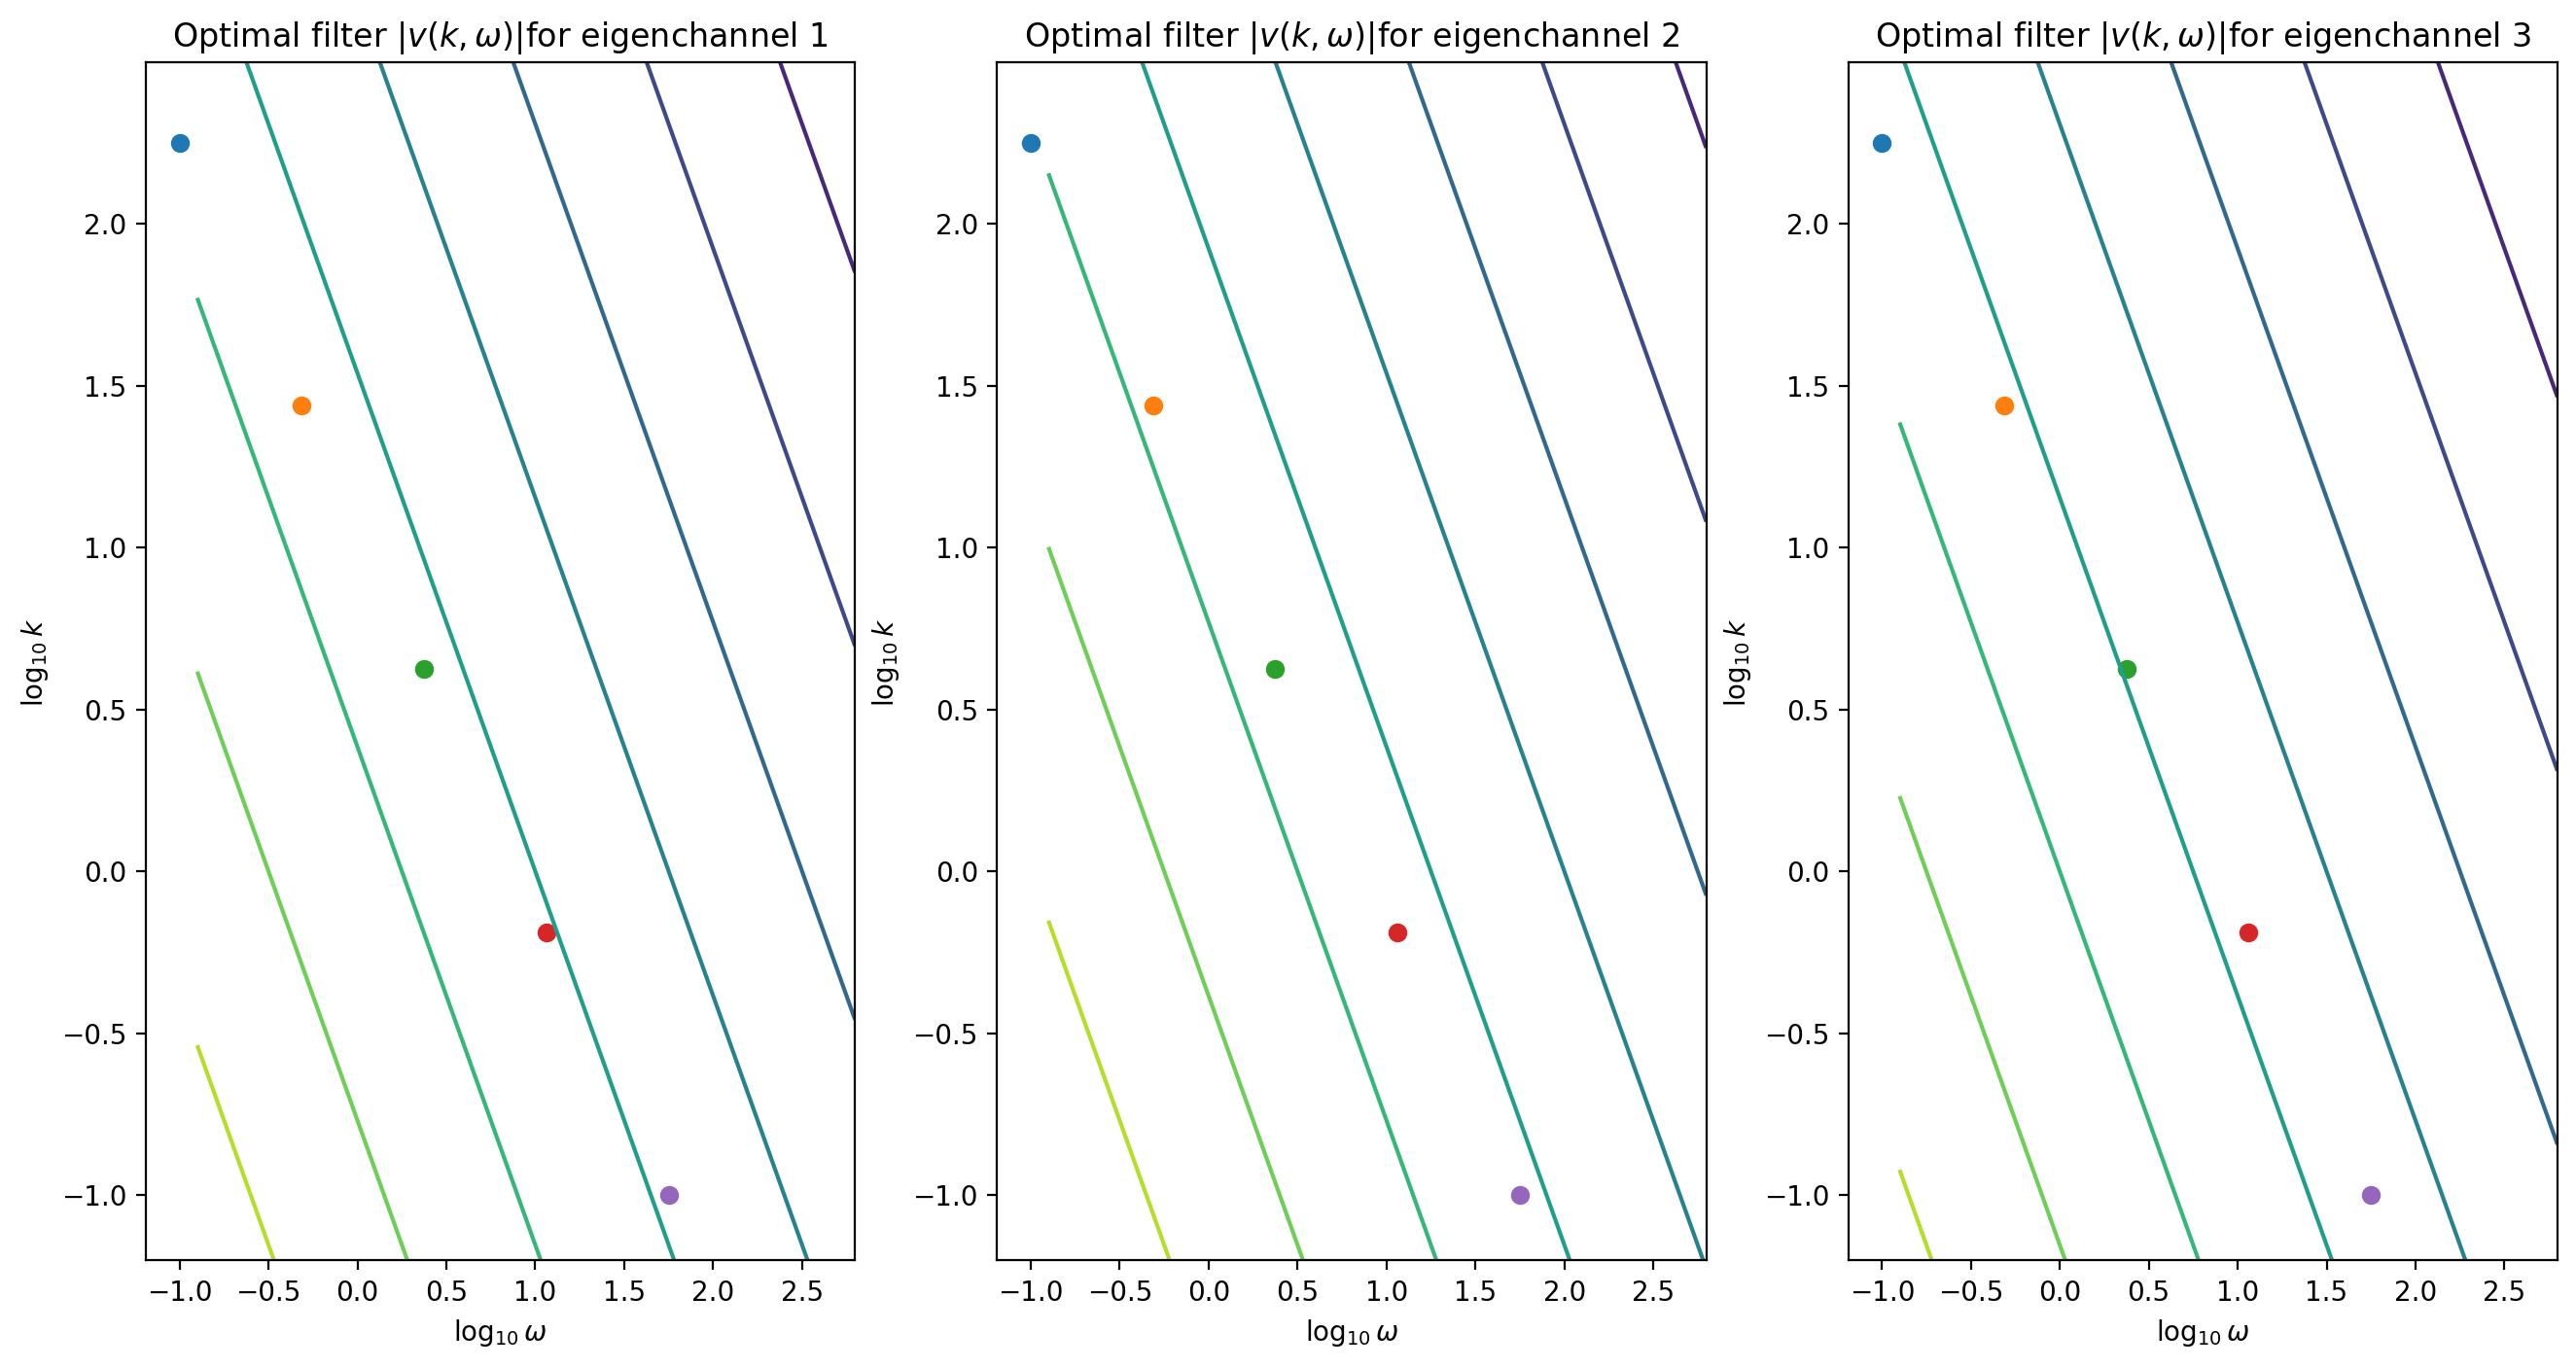

Excess power:  -1.6636669819547478e-10
[ 0.13022092  0.0200157  -0.21659407]


/tmp/ipykernel_237771/1305895702.py:27: RuntimeWarning: invalid value encountered in divide
  vspace /= np.linalg.norm(vspace)


Excess power:  -3.856880392838491e-08
[ 0.15943378 -0.00351002 -0.64780581]
Excess power:  -4.489075777769358e-11
[-0.00441807 -0.79513633 -1.08561461]
Excess power:  -9.48960177105107e-08
[-0.99189864 -1.25016909 -0.63330859]
Excess power:  -2.963759460072879e-09
[-1.79690838 -0.97202492 -1.834296  ]


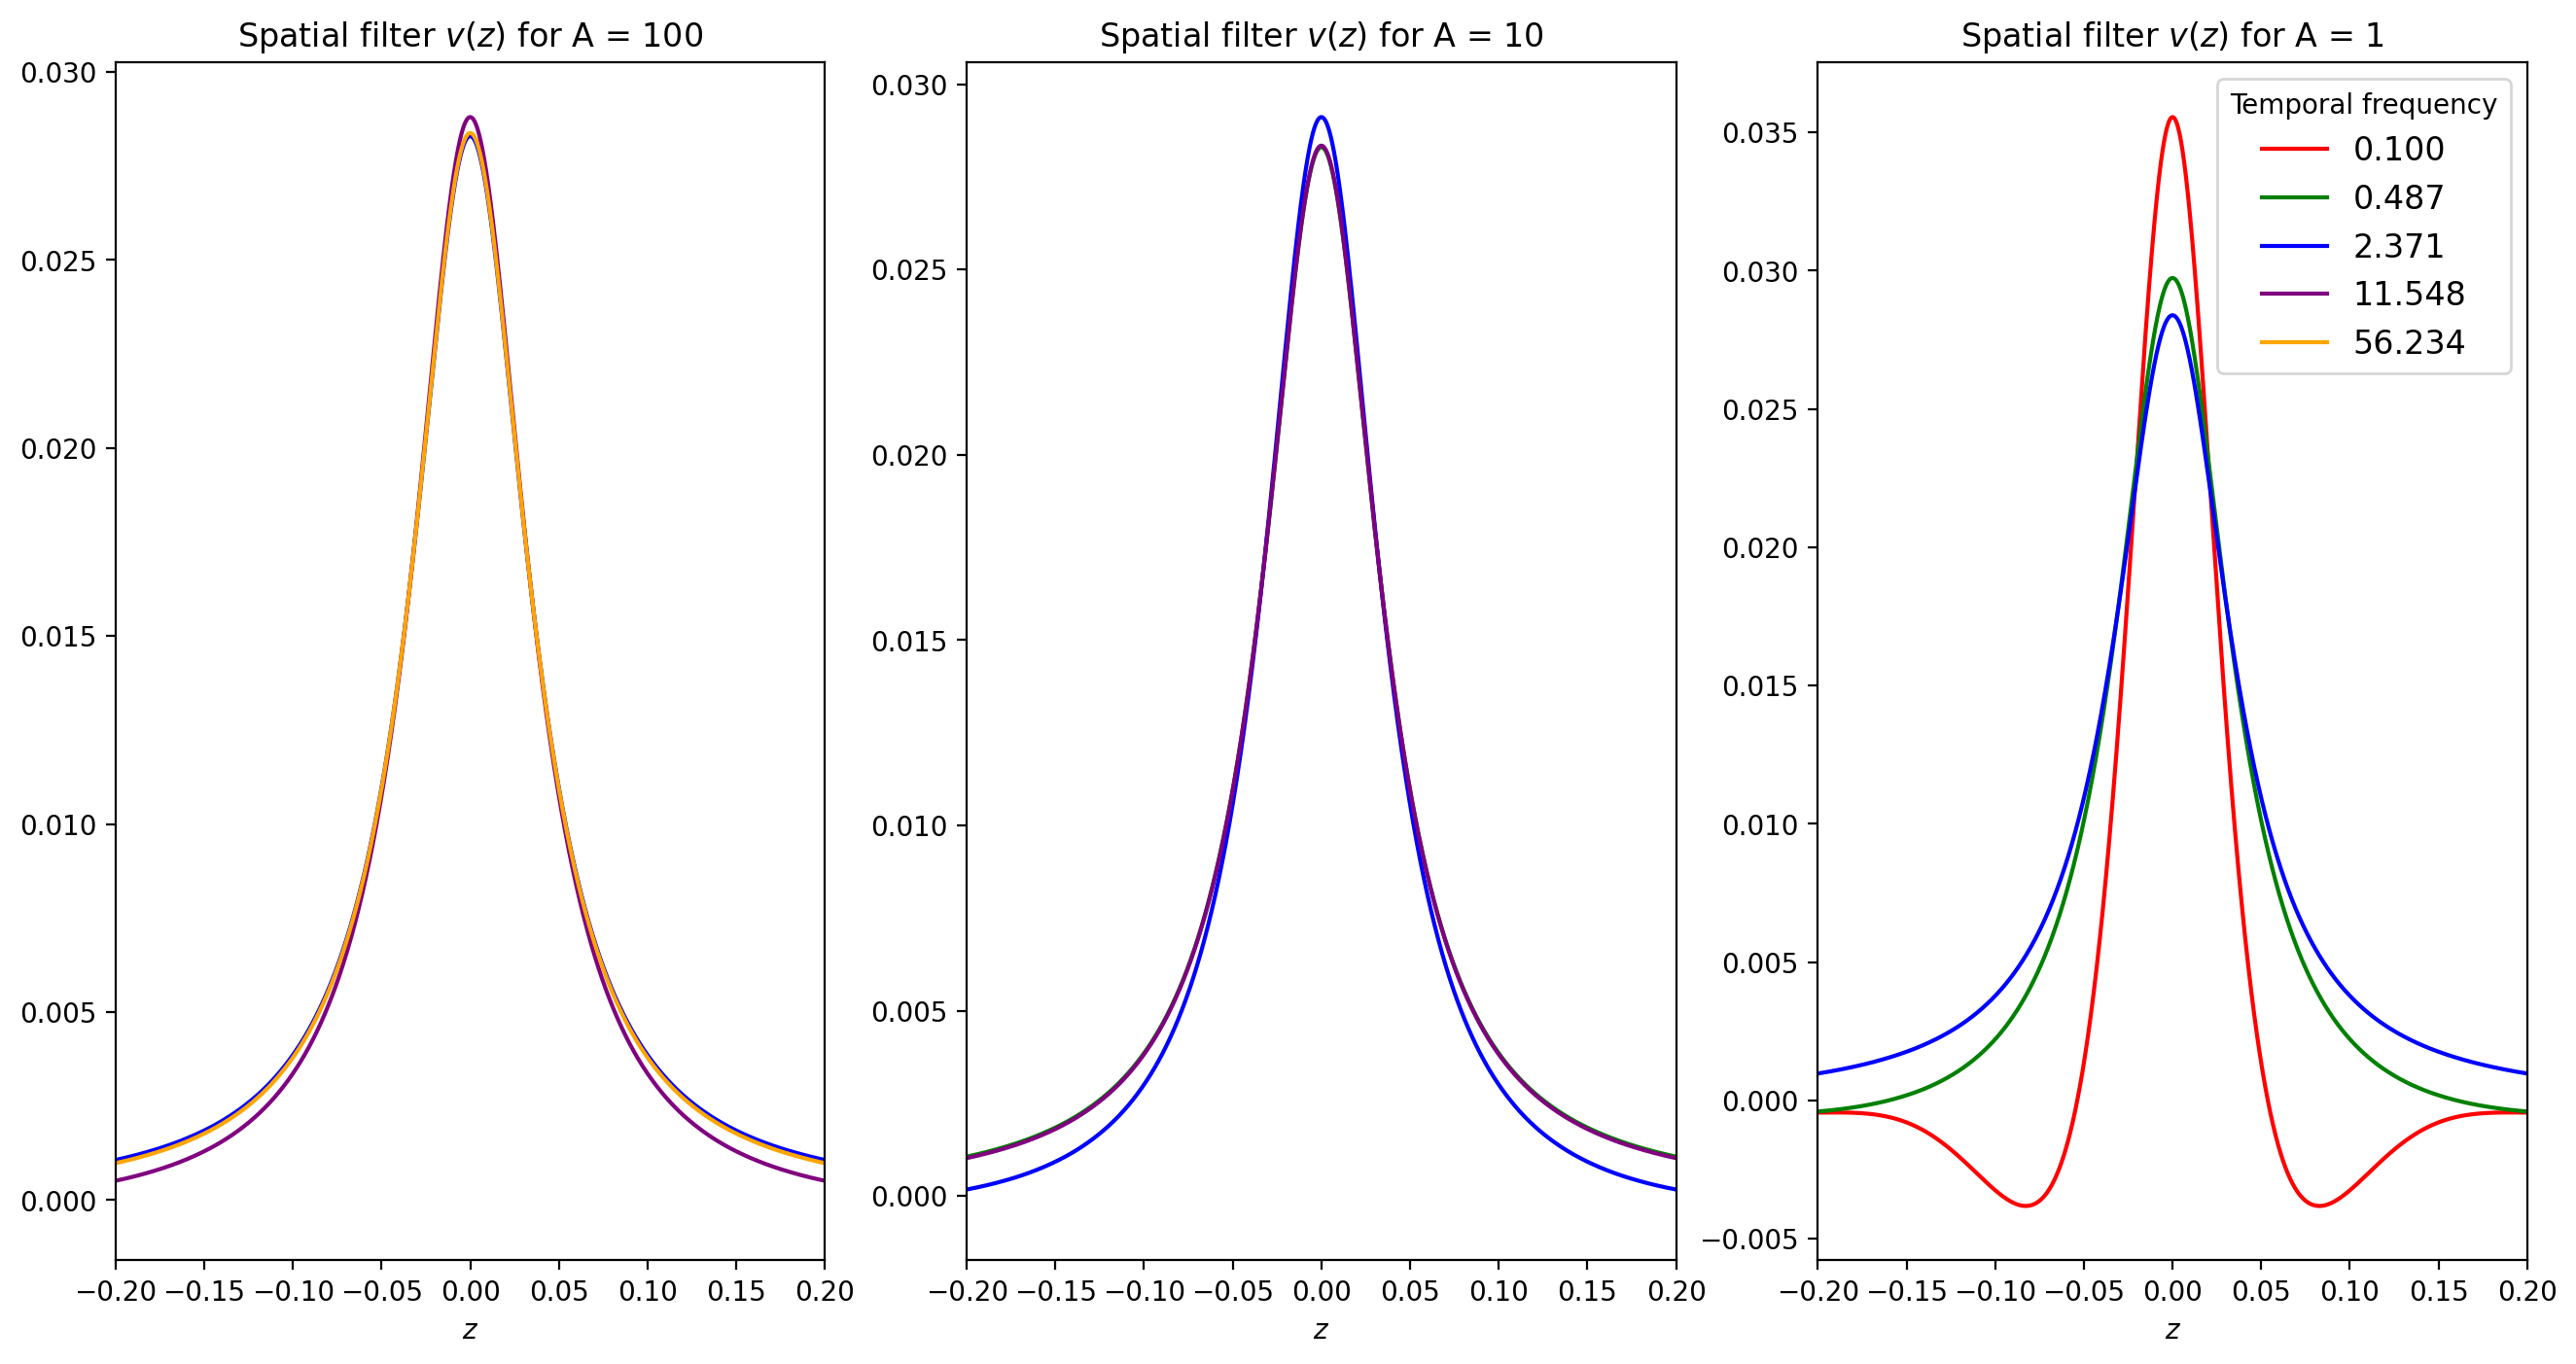

In [229]:
test = []
test.append([0,1])
test.append([2,3])
print(test[:])

[[0, 1], [2, 3]]


Excess power:  -8.141982865694786e-09
log_eps:  [-1.36055383 -1.56065216 -1.68151206]


/tmp/ipykernel_237771/471616026.py:66: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')


Excess power:  -8.025424547142279e-09
log_eps:  [-0.63327041 -0.90460451 -1.15504771]
Excess power:  -2.580158309228864e-13
log_eps:  [ 1.92710392e-01 -4.91933308e-04 -8.61701835e-01]
Excess power:  -4.2787995369053533e-13
log_eps:  [ 0.13406944 -0.01761852 -0.3446948 ]
Excess power:  -3.087075040042464e-10
log_eps:  [ 0.0805309   0.07237286 -0.11092124]


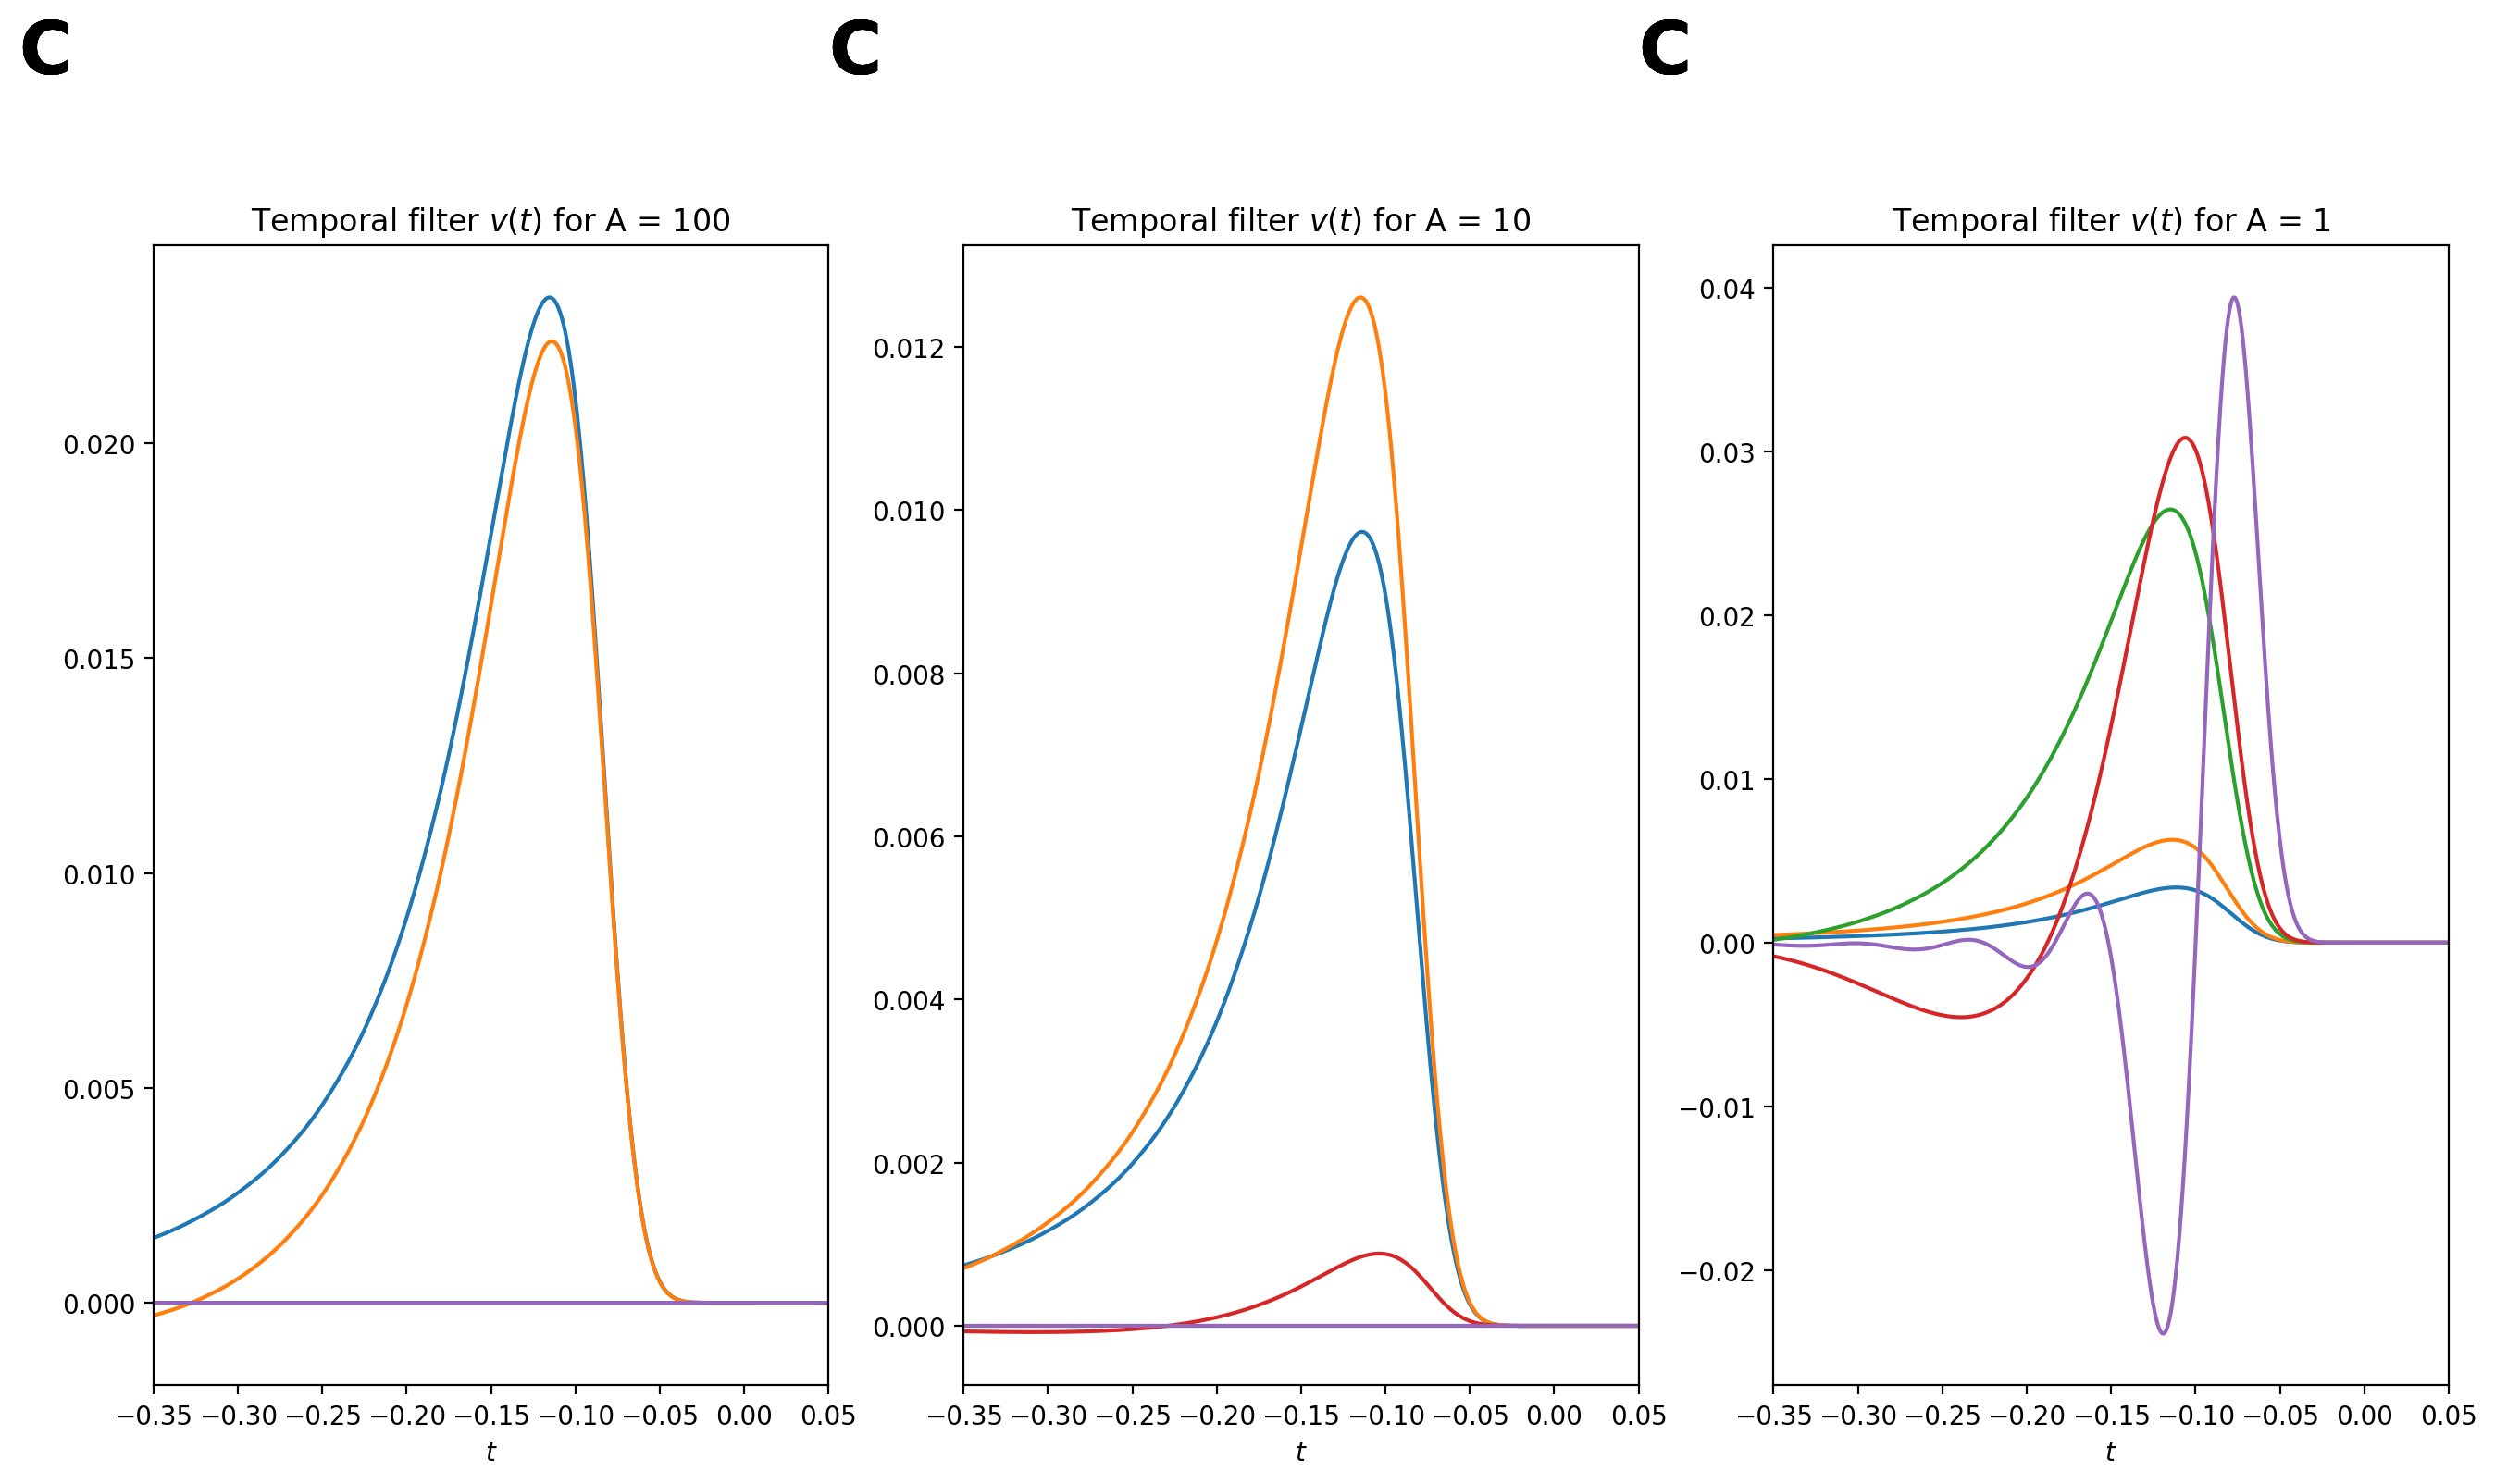

/tmp/ipykernel_237771/471616026.py:66: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')


False

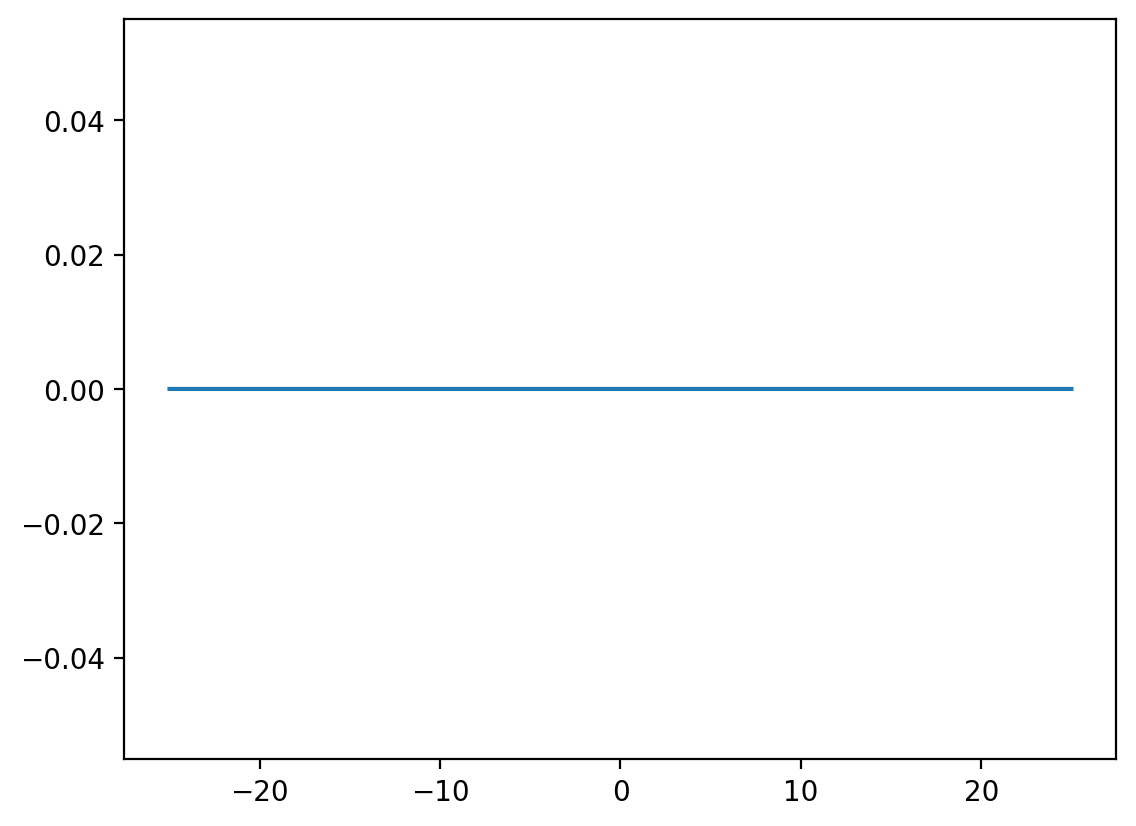

In [349]:
#This snippet is for debugging purposes 

M = 1000001
T = (M//2) * dt
tt = np.linspace(-T/2, T/2, M)
vv = vv_all[2]
vf = np.convolve(vv[M//2:], ff, mode='same')
log_v = extrap_and_reflect(vf, M, return_log=True)
log_v_a = np.conj(ssig.hilbert(log_v))
vt_prenorm = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(np.exp(log_v_a)))))
vt = vt_prenorm/np.linalg.norm(vt_prenorm)
#plt.plot(tt,  vv_all[2])
plt.plot(tt, vv)
np.max(vv) > 0
#plt.xlim(-0.35,0.05)

In [352]:
omega_range_mul

4

In [157]:
k0_list = [10**k0 for k0 in np.linspace(2.25, -1, 5)]
o0_list = [10**o0 for o0 in np.linspace(-0.25*omega_range_mul, 1.75, 5)]

kf_list_noA = [(sigin**2/o0**2)**(1/alpha) for o0 in o0_list]
of_list_noA = [np.sqrt(sigin**2/k0**alpha) for k0 in k0_list]
np.array(kf_list_noA)*(100**(1/alpha))
np.array(of_list_noA)*np.sqrt(100)

array([ 0.34474661,  1.16312128,  3.92418976, 13.23960414, 44.66835922])

In [188]:
omega_range_mul

4

In [ ]:
cmap = sns.color_palette('rocket')
kf = 50

J_list = [1, 4, 9, 16, 25]
for idx, J in enumerate(J_list):
    k_lims = (0, np.sqrt(J) * 8)
    log_eps = optimal_logeps(kf, freqs_k, k_lims, alpha, P)
    vv = filter_k(kf, 10**log_eps, k_lims)(freqs_k)
    vf = np.convolve(vv[N//2:], ff, mode='same')
    vvf = pad_and_reflect(vf, N)
    vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
    vspace /= np.linalg.norm(vspace)    
    ax[1, 0].plot(zz, vspace, color=cmap[idx], label=J)

ax[1, 0].set_xlim(-0.2, 0.2)
ax[1, 0].set_yticks([])
ax[1, 0].set_xlabel(r"$z$")
ax[1, 0].set_title(r"Spatial filter $v(z)$")
ax[1, 0].legend(title="Neurons", loc='upper right')
ax[1, 0].text(*label_loc, r'\textbf{D}', transform=ax[1, 0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')



for idx in range(len(diff_info_fn_list)):
    all_diff_info = diff_info_fn_list[idx]
    ax[1, 1].plot(all_J_list, all_diff_info(all_J_list))

ax[1, 1].set_title("Marginal information gain per neuron")
ax[1, 1].set_xlabel("Number of neurons in mosaic")
ax[1, 1].set_ylabel("Information gain (nats)")
ax[1, 1].text(*label_loc, r'\textbf{E}', transform=ax[1, 1].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    

Excess power:  -1.7180000044803023e-07
[ 0.34820823 -0.00302869 -0.49629691]


/tmp/ipykernel_237771/3867812646.py:48: RuntimeWarning: invalid value encountered in divide
  vspace /= np.linalg.norm(vspace)


(1000001,) (1000001,)
Excess power:  -9.7757264061471e-07
[-1.16016489e-03 -9.26053616e-01 -1.18579582e+00]
(1000001,) (1000001,)
Excess power:  -1.0263746608174529e-07
[-1.50309244 -0.38950636 -1.41164287]
(1000001,) (1000001,)
Excess power:  0.9834975803101909
[-2. -2. -2.]
(1000001,) (1000001,)
Excess power:  1.0
[-2. -2. -2.]
(1000001,) (1000001,)
Excess power:  -1.7180000044803023e-07
[ 0.34820823 -0.00302869 -0.49629691]
(1000001,) (1000001,)
Excess power:  -9.7757264061471e-07
[-1.16016489e-03 -9.26053616e-01 -1.18579582e+00]
(1000001,) (1000001,)
Excess power:  -1.0263746608174529e-07
[-1.50309244 -0.38950636 -1.41164287]
(1000001,) (1000001,)
Excess power:  0.9834975803101909
[-2. -2. -2.]
(1000001,) (1000001,)
Excess power:  1.0
[-2. -2. -2.]
(1000001,) (1000001,)
Excess power:  -1.7180000044803023e-07
[ 0.34820823 -0.00302869 -0.49629691]
(1000001,) (1000001,)
Excess power:  -9.7757264061471e-07
[-1.16016489e-03 -9.26053616e-01 -1.18579582e+00]
(1000001,) (1000001,)
Excess p

NameError: name 'of_list' is not defined

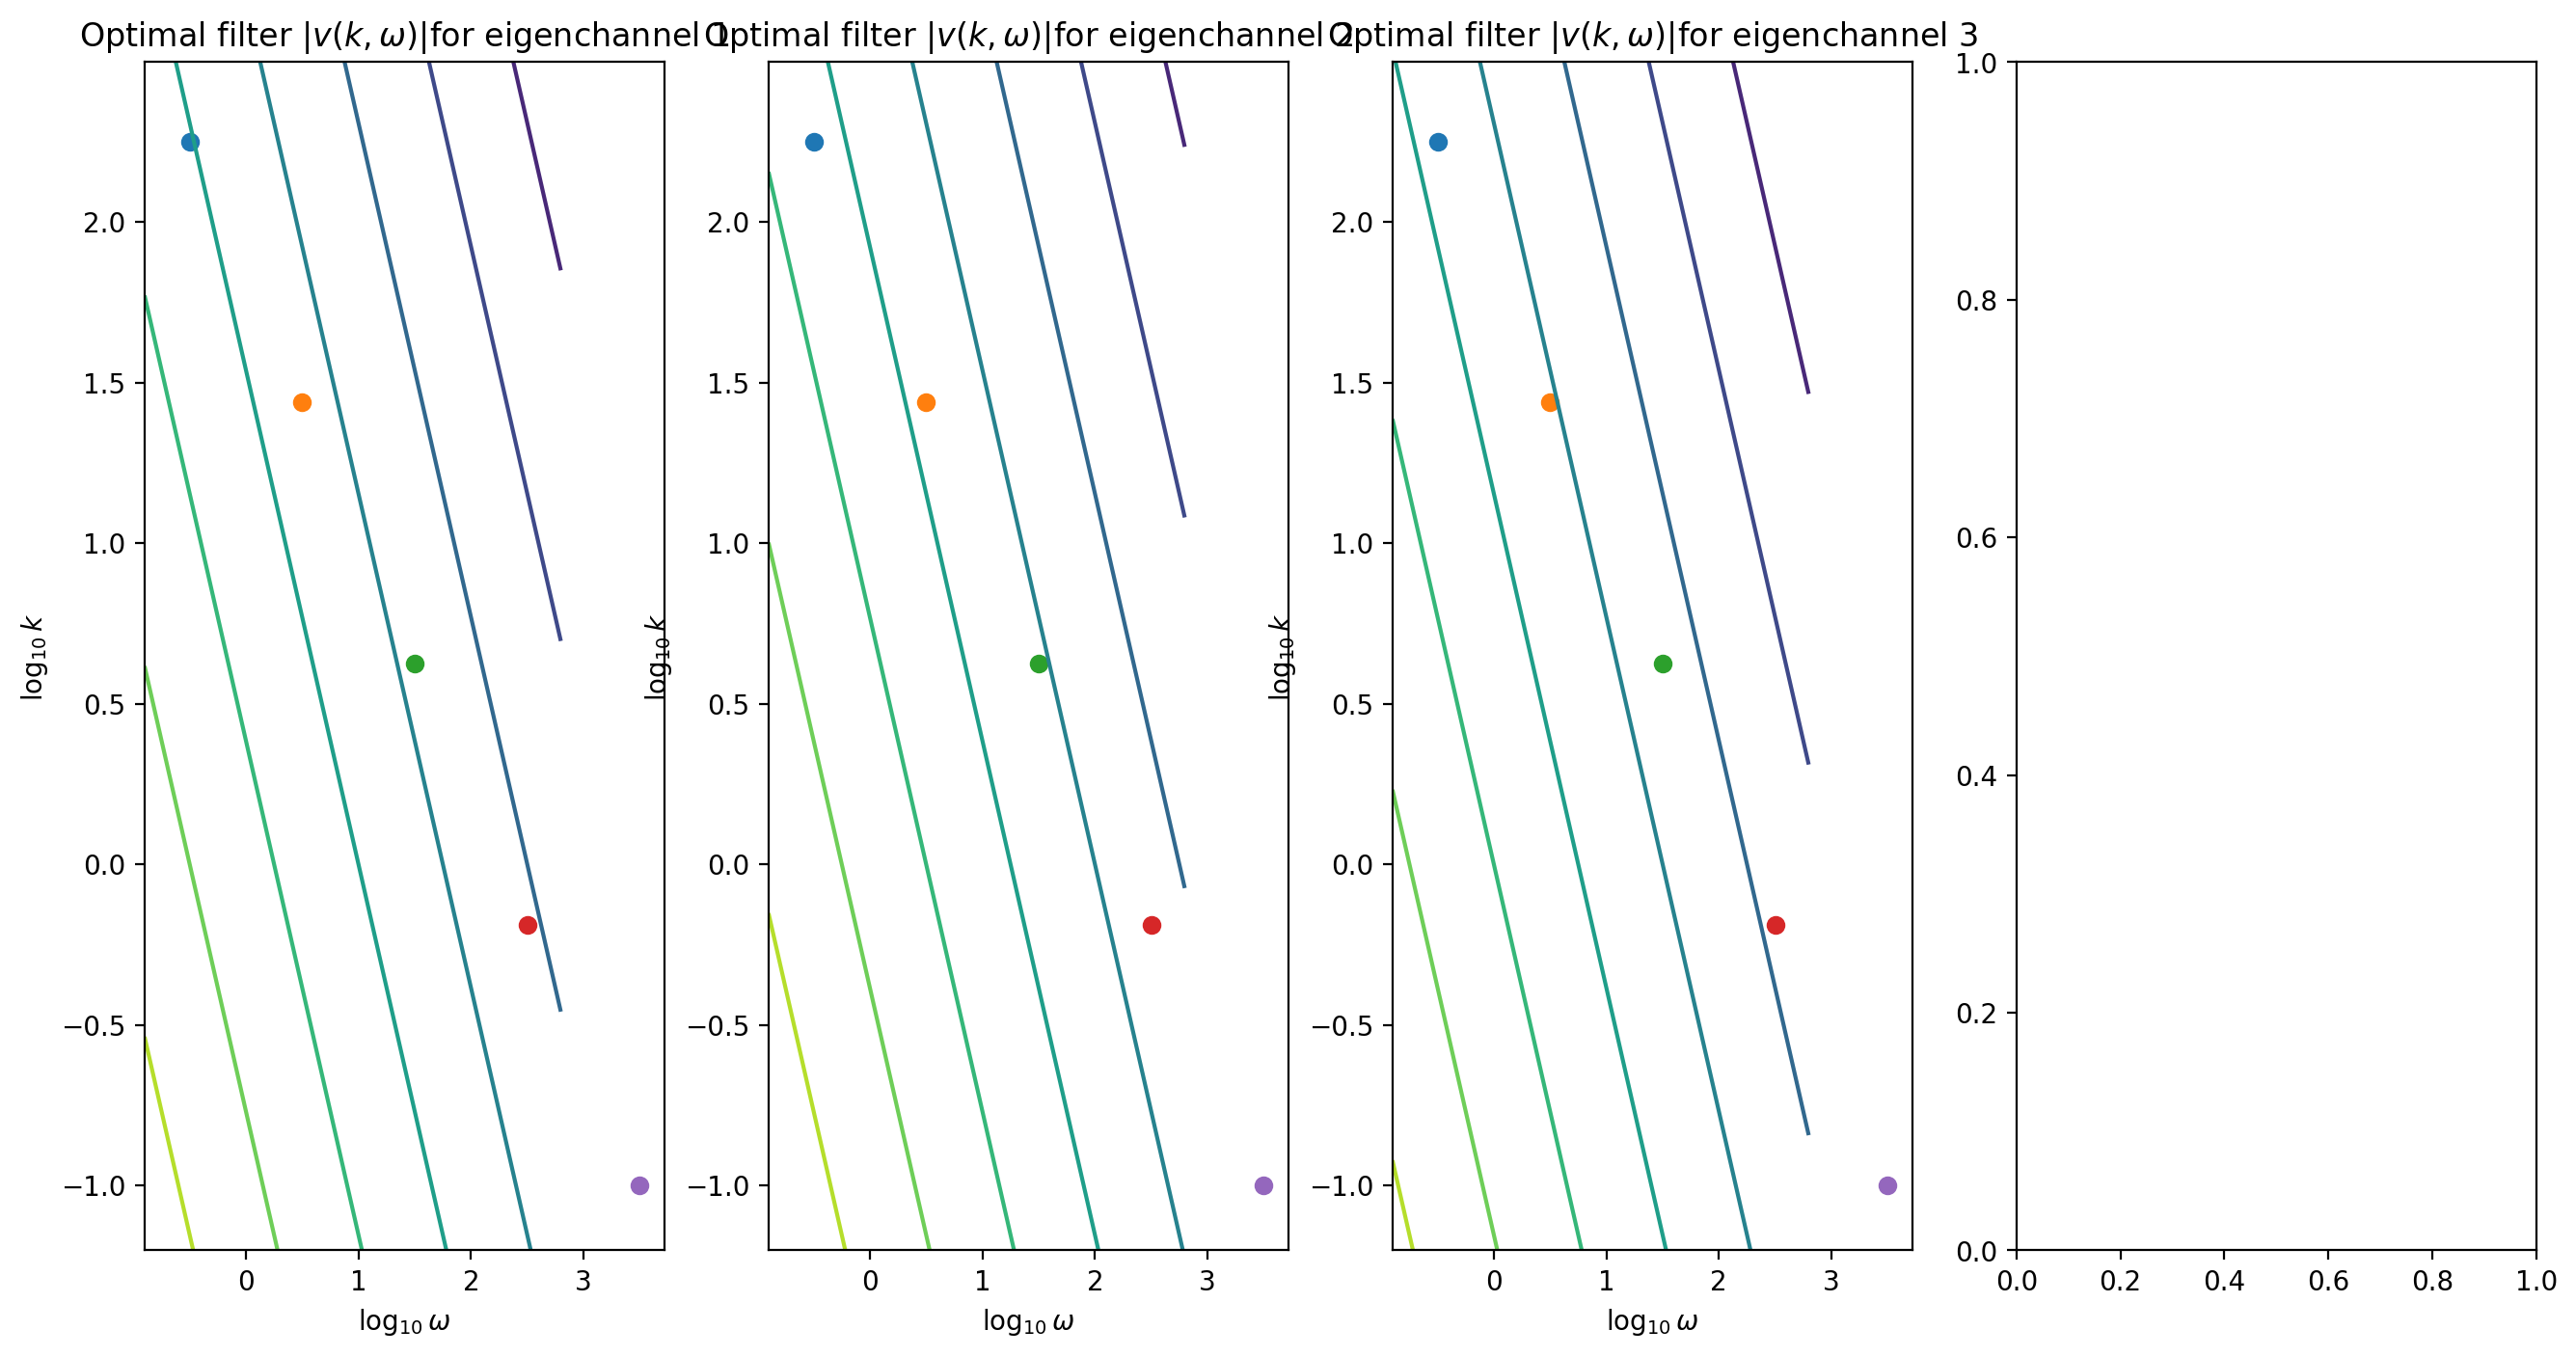

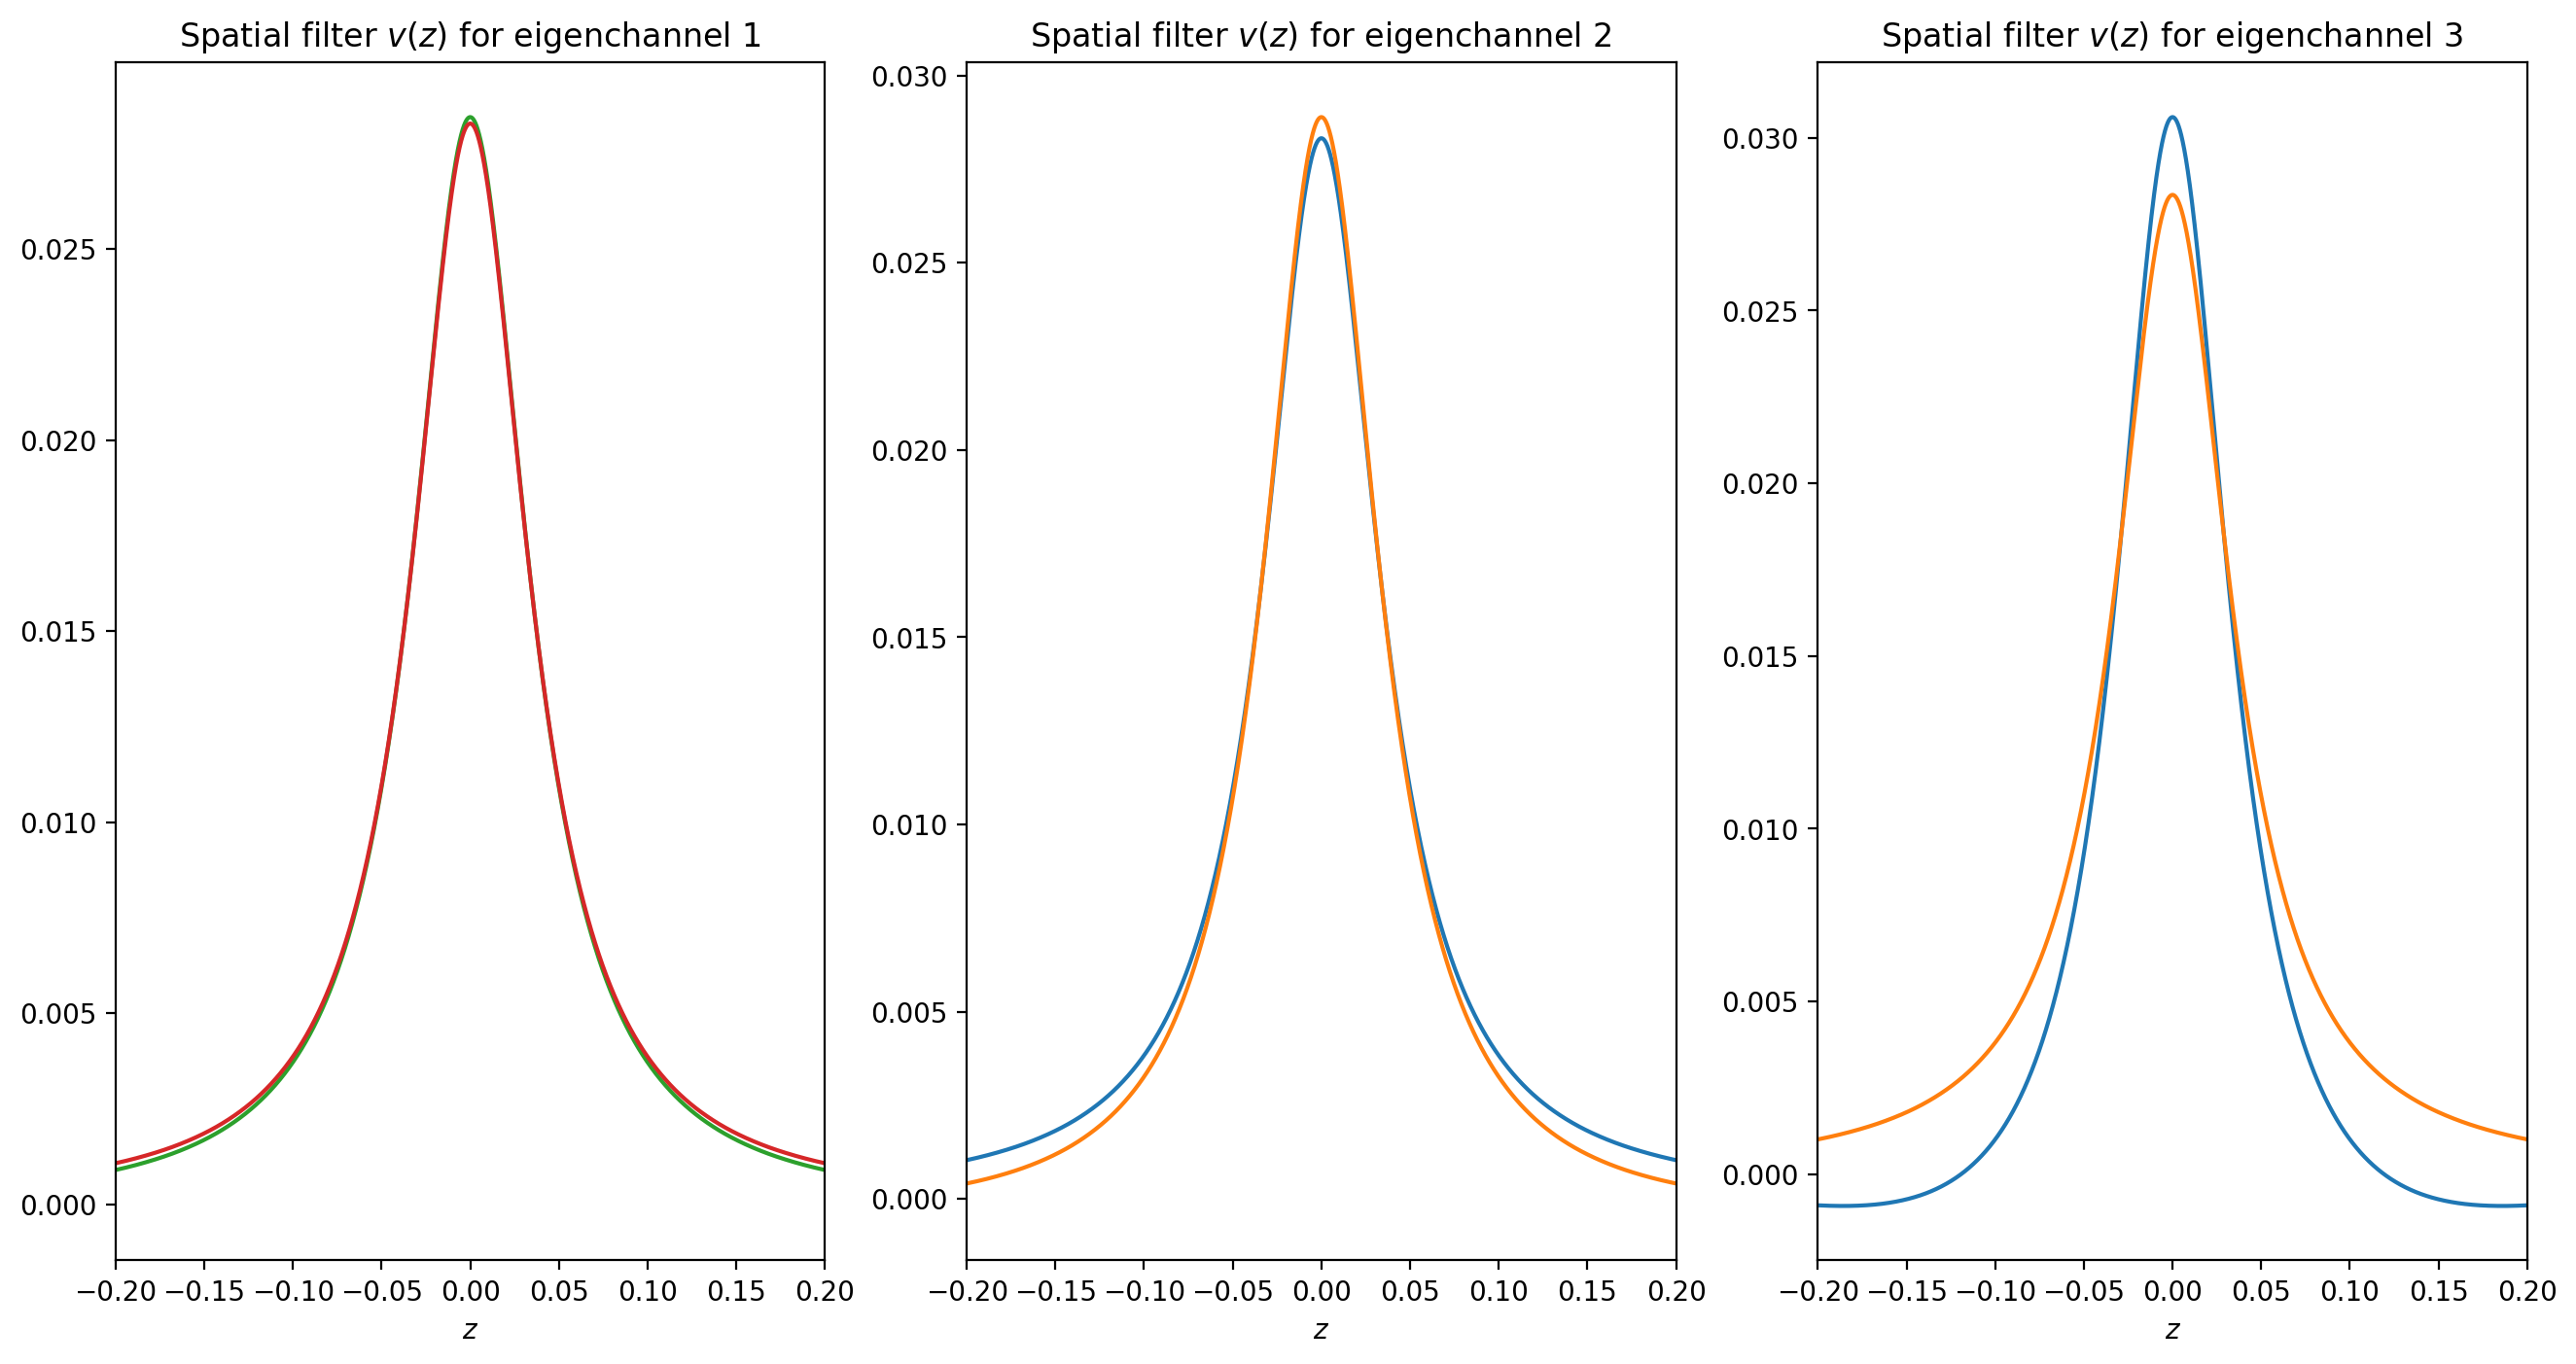

In [114]:

ax[1, 2].plot(all_J_list, np.cumsum(marginal_allocation, axis=0))
ax[1, 2].set_ylim(0, 50)
ax[1, 2].set_title("Neuron allocation across mosaics")
ax[1, 2].set_xlabel("Total number of neurons")
ax[1, 2].set_ylabel("Neurons in mosaic")
ax[1, 2].text(*label_loc, r'\textbf{F}', transform=ax[1, 2].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')

plt.tight_layout()
plt.savefig("figures/optimal_linear_spacetime.pdf")

In [99]:
kf_noA*(A[0]**(1/alpha))

0.07017038286703829

In [113]:
vspace

array([nan, nan, nan, ..., nan, nan, nan])